In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics, preprocessing, model_selection
import lightgbm as lgb

import gc
gc.enable()
gc.collect()

pd.options.display.max_columns = 100
%matplotlib inline

In [2]:
train = pd.read_csv('./training.csv')
test = pd.read_csv('./test.csv')
train.shape, test.shape

((95662, 16), (45019, 15))

In [3]:
train['TransactionStartTime'] = train['TransactionStartTime'].str.replace('T', ' ')
train['TransactionStartTime'] = train['TransactionStartTime'].str.replace('Z', '')

test['TransactionStartTime'] = test['TransactionStartTime'].str.replace('T', ' ')
test['TransactionStartTime'] = test['TransactionStartTime'].str.replace('Z', '')

In [4]:
train['TransactionStartTime'] = pd.to_datetime(train['TransactionStartTime'], infer_datetime_format=True) 
test['TransactionStartTime'] = pd.to_datetime(test['TransactionStartTime'], infer_datetime_format=True) 

In [5]:
train['Year'] = train['TransactionStartTime'].dt.year
train['Month'] = train['TransactionStartTime'].dt.month
train['Day'] = train['TransactionStartTime'].dt.day
train['Hour'] = train['TransactionStartTime'].dt.hour
train['Minute'] = train['TransactionStartTime'].dt.minute
train['Seconds'] = train['TransactionStartTime'].dt.second
train['week'] = train['TransactionStartTime'].dt.week
train['weekday'] = train['TransactionStartTime'].dt.weekday

test['Year'] = test['TransactionStartTime'].dt.year
test['Month'] = test['TransactionStartTime'].dt.month
test['Day'] = test['TransactionStartTime'].dt.day
test['Hour'] = test['TransactionStartTime'].dt.hour
test['Minute'] = test['TransactionStartTime'].dt.minute
test['Seconds'] = test['TransactionStartTime'].dt.second
test['week'] = test['TransactionStartTime'].dt.week
test['weekday'] = test['TransactionStartTime'].dt.weekday

In [6]:
for col in train.columns:
    if train[col].dtype == 'object' and col not in ['TransactionId', 'FraudResult']:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
        train[col] = lbl.fit_transform(list(train[col].values.astype('str')))
        test[col] = lbl.fit_transform(list(test[col].values.astype('str')))

BatchId
AccountId
SubscriptionId
CustomerId
CurrencyCode
ProviderId
ProductId
ProductCategory
ChannelId


In [7]:
train.loc[train['Amount'] > 0, 'Debit'] = 1
train.loc[train['Amount'] < 0, 'Debit'] = 0

test.loc[test['Amount'] > 0, 'Debit'] = 1
test.loc[test['Amount'] < 0, 'Debit'] = 0

train['Debit'] = train['Debit'].astype('int')
test['Debit'] = test['Debit'].astype('int')

In [8]:
for col in [
            "CustomerId", ["AccountId", "TransactionStartTime"],
            ["Debit", "TransactionStartTime"],
            ["CustomerId", "Year"],
            ["CustomerId", "Month"],
            ["AccountId", "Year"],
            ["AccountId", "Month"],
            ["AccountId", "Year", "Month"],
    
            ["AccountId", "TransactionStartTime"],
    
            ["AccountId", "Debit", "Year", "week"],
            ["AccountId", "Debit", "Year", "week"],
            ["AccountId", "Debit", "Year", "Month"],

           ]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = pd.concat([train[["TransactionId"]+ col], test[["TransactionId"]+ col]])
    gdf = all_df.groupby(col)["TransactionId"].count().reset_index()
    gdf.columns = col + [col_name+"_count"]
    train = pd.merge(train, gdf, on=col, how="left")
    test = pd.merge(test, gdf, on=col, how="left")

In [9]:
feat_df = pd.read_csv('./Feat_v3.csv')
train = pd.merge(train, feat_df, on='TransactionId', how='left')
test = pd.merge(test, feat_df, on='TransactionId', how='left')
del feat_df
gc.collect()

574

In [10]:
#train.to_csv('train_for_models.csv', index=False)
#test.to_csv('test_for_models.csv', index=False)

In [11]:
#pd.DataFrame(train.corr()['FraudResult'].sort_values(ascending=False))

In [12]:
#train.fillna(-999, inplace=True)
#test.fillna(-999, inplace=True)

In [13]:
cols_to_exclude = ['CustomerId', 'TransactionId', 'FraudResult', 'TransactionStartTime', 'CurrencyCode', 
                   'CountryCode']
cols_to_use = [col for col in train.columns if col not in cols_to_exclude]
X_train = train[cols_to_use]
y_train = train['FraudResult']
X_test = test[cols_to_use]

In [17]:
#from imblearn.over_sampling import SMOTE
#smote = SMOTE(ratio='majority', k_neighbors=9)
#X_train, y_train = smote.fit_sample(X_train, y_train)
#from sklearn.utils import resample

#X = pd.concat([X_train, y_train], axis=1)

#fraud = X[X['FraudResult'] == 1]
#not_fraud = X[X['FraudResult'] == 0]

#over_sampled = resample(fraud, 
#                        replace=True, 
#                        n_samples=len(not_fraud), 
#                        random_state=27)

#over_sampled = pd.concat([not_fraud, over_sampled])
#over_sampled.FraudResult.value_counts()
#del X

In [17]:
from imblearn.over_sampling import RandomOverSampler

X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

In [55]:
import xgboost as xgb

clf = xgb.XGBClassifier(n_estimators=1000,
                        n_jobs=4,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9)
clf.fit(X_train, y_train)
xgb_pred = clf.predict(np.array(X_test))

In [61]:
#X_train = over_sampled.drop('FraudResult', axis=1)
#y_train = over_sampled['FraudResult']
#X_train.shape, y_train.shape

In [271]:
import xgboost as xgb

full_pred = 0
n_splits = 3
folds = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=101)

for train_index, val_index  in folds.split(X_train, y_train.values):
    dev_X, dev_y = X_train.iloc[train_index, :], y_train[train_index]
    val_X, val_y = X_train.iloc[val_index, :], y_train[val_index]

    pred_val = 0

    dev_X, dev_y = RandomOverSampler().fit_resample(dev_X, dev_y)
    
    clf = xgb.XGBClassifier(n_estimators=1000,
                            n_jobs=4,
                            max_depth=9,
                            learning_rate=0.05,
                            subsample=0.9,
                            colsample_bytree=0.9
                           )
    clf.fit(dev_X, dev_y)
    pred_val = clf.predict(np.array(val_X))
    print(metrics.mean_squared_error(val_y, pred_val))
    full_pred  += clf.predict(np.array(X_test)) / n_splits

0.0006271951831409935
0.0004076896540910089
0.0005331326245805501


In [28]:
#xgb_pred = clf.predict(np.array(X_test))

In [305]:
classifier = catboost.CatBoostClassifier(iterations = 10000,
                                #task_type = 'GPU',
                                eval_metric='F1',
                                loss_function= 'Logloss',
                                #cat_features=[3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22],
                                #learning_rate=0.003
                                scale_pos_weight = 1.55,
                                #depth=7
                                )

In [306]:
classifier.fit(X_train, y_train)

Learning rate set to 0.00952
0:	learn: 0.9980037	total: 135ms	remaining: 22m 30s
1:	learn: 0.9986065	total: 249ms	remaining: 20m 45s
2:	learn: 0.9990683	total: 376ms	remaining: 20m 54s
3:	learn: 0.9992032	total: 498ms	remaining: 20m 45s
4:	learn: 0.9991357	total: 628ms	remaining: 20m 55s
5:	learn: 0.9991695	total: 745ms	remaining: 20m 41s
6:	learn: 0.9991155	total: 876ms	remaining: 20m 51s
7:	learn: 0.9990548	total: 994ms	remaining: 20m 41s
8:	learn: 0.9991121	total: 1.12s	remaining: 20m 44s
9:	learn: 0.9990615	total: 1.23s	remaining: 20m 27s
10:	learn: 0.9991054	total: 1.35s	remaining: 20m 27s
11:	learn: 0.9990514	total: 1.46s	remaining: 20m 17s
12:	learn: 0.9990885	total: 1.58s	remaining: 20m 17s
13:	learn: 0.9990750	total: 1.7s	remaining: 20m 13s
14:	learn: 0.9990481	total: 1.82s	remaining: 20m 11s
15:	learn: 0.9990683	total: 1.93s	remaining: 20m 2s
16:	learn: 0.9989941	total: 2.06s	remaining: 20m 11s
17:	learn: 0.9990649	total: 2.18s	remaining: 20m 7s
18:	learn: 0.9990953	total: 2.

156:	learn: 0.9995744	total: 18.6s	remaining: 19m 25s
157:	learn: 0.9995744	total: 18.7s	remaining: 19m 23s
158:	learn: 0.9995744	total: 18.8s	remaining: 19m 21s
159:	learn: 0.9995711	total: 18.9s	remaining: 19m 22s
160:	learn: 0.9995711	total: 19s	remaining: 19m 20s
161:	learn: 0.9995711	total: 19.1s	remaining: 19m 20s
162:	learn: 0.9995711	total: 19.2s	remaining: 19m 19s
163:	learn: 0.9995711	total: 19.3s	remaining: 19m 17s
164:	learn: 0.9995711	total: 19.4s	remaining: 19m 16s
165:	learn: 0.9995677	total: 19.5s	remaining: 19m 14s
166:	learn: 0.9995677	total: 19.6s	remaining: 19m 13s
167:	learn: 0.9995677	total: 19.7s	remaining: 19m 12s
168:	learn: 0.9995677	total: 19.8s	remaining: 19m 11s
169:	learn: 0.9995677	total: 19.9s	remaining: 19m 10s
170:	learn: 0.9995677	total: 20s	remaining: 19m 10s
171:	learn: 0.9995677	total: 20.1s	remaining: 19m 8s
172:	learn: 0.9995677	total: 20.2s	remaining: 19m 6s
173:	learn: 0.9995677	total: 20.3s	remaining: 19m 5s
174:	learn: 0.9995677	total: 20.4s	

310:	learn: 0.9995778	total: 33s	remaining: 17m 8s
311:	learn: 0.9995778	total: 33.1s	remaining: 17m 7s
312:	learn: 0.9995778	total: 33.2s	remaining: 17m 6s
313:	learn: 0.9995778	total: 33.3s	remaining: 17m 6s
314:	learn: 0.9995778	total: 33.3s	remaining: 17m 5s
315:	learn: 0.9995778	total: 33.4s	remaining: 17m 4s
316:	learn: 0.9995778	total: 33.5s	remaining: 17m 3s
317:	learn: 0.9995778	total: 33.6s	remaining: 17m 2s
318:	learn: 0.9995778	total: 33.7s	remaining: 17m 1s
319:	learn: 0.9995778	total: 33.7s	remaining: 17m
320:	learn: 0.9995778	total: 33.8s	remaining: 17m
321:	learn: 0.9995778	total: 34s	remaining: 17m 1s
322:	learn: 0.9995812	total: 34.1s	remaining: 17m 1s
323:	learn: 0.9995812	total: 34.2s	remaining: 17m
324:	learn: 0.9995812	total: 34.3s	remaining: 17m
325:	learn: 0.9995812	total: 34.4s	remaining: 16m 59s
326:	learn: 0.9995812	total: 34.5s	remaining: 16m 59s
327:	learn: 0.9995812	total: 34.5s	remaining: 16m 58s
328:	learn: 0.9995812	total: 34.6s	remaining: 16m 57s
329:	

464:	learn: 0.9996318	total: 47s	remaining: 16m 4s
465:	learn: 0.9996318	total: 47.1s	remaining: 16m 4s
466:	learn: 0.9996318	total: 47.2s	remaining: 16m 3s
467:	learn: 0.9996318	total: 47.3s	remaining: 16m 2s
468:	learn: 0.9996352	total: 47.4s	remaining: 16m 2s
469:	learn: 0.9996352	total: 47.4s	remaining: 16m 2s
470:	learn: 0.9996386	total: 47.5s	remaining: 16m 1s
471:	learn: 0.9996386	total: 47.6s	remaining: 16m 1s
472:	learn: 0.9996386	total: 47.7s	remaining: 16m
473:	learn: 0.9996386	total: 47.8s	remaining: 16m 1s
474:	learn: 0.9996386	total: 48s	remaining: 16m 2s
475:	learn: 0.9996386	total: 48.1s	remaining: 16m 1s
476:	learn: 0.9996420	total: 48.2s	remaining: 16m 1s
477:	learn: 0.9996420	total: 48.2s	remaining: 16m
478:	learn: 0.9996420	total: 48.3s	remaining: 16m
479:	learn: 0.9996420	total: 48.4s	remaining: 16m
480:	learn: 0.9996420	total: 48.5s	remaining: 15m 59s
481:	learn: 0.9996420	total: 48.6s	remaining: 15m 59s
482:	learn: 0.9996420	total: 48.7s	remaining: 15m 58s
483:	l

620:	learn: 0.9996656	total: 1m 2s	remaining: 15m 43s
621:	learn: 0.9996656	total: 1m 2s	remaining: 15m 43s
622:	learn: 0.9996656	total: 1m 2s	remaining: 15m 43s
623:	learn: 0.9996656	total: 1m 2s	remaining: 15m 43s
624:	learn: 0.9996656	total: 1m 2s	remaining: 15m 43s
625:	learn: 0.9996656	total: 1m 2s	remaining: 15m 42s
626:	learn: 0.9996656	total: 1m 3s	remaining: 15m 42s
627:	learn: 0.9996656	total: 1m 3s	remaining: 15m 42s
628:	learn: 0.9996656	total: 1m 3s	remaining: 15m 42s
629:	learn: 0.9996656	total: 1m 3s	remaining: 15m 42s
630:	learn: 0.9996656	total: 1m 3s	remaining: 15m 42s
631:	learn: 0.9996656	total: 1m 3s	remaining: 15m 42s
632:	learn: 0.9996656	total: 1m 3s	remaining: 15m 42s
633:	learn: 0.9996656	total: 1m 3s	remaining: 15m 41s
634:	learn: 0.9996656	total: 1m 3s	remaining: 15m 41s
635:	learn: 0.9996656	total: 1m 3s	remaining: 15m 41s
636:	learn: 0.9996656	total: 1m 4s	remaining: 15m 41s
637:	learn: 0.9996656	total: 1m 4s	remaining: 15m 41s
638:	learn: 0.9996656	total:

773:	learn: 0.9996926	total: 1m 17s	remaining: 15m 25s
774:	learn: 0.9996926	total: 1m 17s	remaining: 15m 25s
775:	learn: 0.9996926	total: 1m 17s	remaining: 15m 24s
776:	learn: 0.9996926	total: 1m 17s	remaining: 15m 24s
777:	learn: 0.9996926	total: 1m 17s	remaining: 15m 24s
778:	learn: 0.9996926	total: 1m 18s	remaining: 15m 24s
779:	learn: 0.9996960	total: 1m 18s	remaining: 15m 24s
780:	learn: 0.9996926	total: 1m 18s	remaining: 15m 23s
781:	learn: 0.9996926	total: 1m 18s	remaining: 15m 23s
782:	learn: 0.9996960	total: 1m 18s	remaining: 15m 23s
783:	learn: 0.9996994	total: 1m 18s	remaining: 15m 23s
784:	learn: 0.9996994	total: 1m 18s	remaining: 15m 23s
785:	learn: 0.9996994	total: 1m 18s	remaining: 15m 22s
786:	learn: 0.9996994	total: 1m 18s	remaining: 15m 22s
787:	learn: 0.9997027	total: 1m 18s	remaining: 15m 22s
788:	learn: 0.9997027	total: 1m 18s	remaining: 15m 22s
789:	learn: 0.9997061	total: 1m 19s	remaining: 15m 21s
790:	learn: 0.9997061	total: 1m 19s	remaining: 15m 21s
791:	learn

925:	learn: 0.9997365	total: 1m 31s	remaining: 14m 51s
926:	learn: 0.9997365	total: 1m 31s	remaining: 14m 51s
927:	learn: 0.9997365	total: 1m 31s	remaining: 14m 51s
928:	learn: 0.9997365	total: 1m 31s	remaining: 14m 51s
929:	learn: 0.9997365	total: 1m 31s	remaining: 14m 51s
930:	learn: 0.9997365	total: 1m 31s	remaining: 14m 50s
931:	learn: 0.9997365	total: 1m 31s	remaining: 14m 50s
932:	learn: 0.9997365	total: 1m 31s	remaining: 14m 50s
933:	learn: 0.9997365	total: 1m 31s	remaining: 14m 49s
934:	learn: 0.9997399	total: 1m 31s	remaining: 14m 49s
935:	learn: 0.9997365	total: 1m 31s	remaining: 14m 49s
936:	learn: 0.9997365	total: 1m 31s	remaining: 14m 49s
937:	learn: 0.9997365	total: 1m 32s	remaining: 14m 49s
938:	learn: 0.9997399	total: 1m 32s	remaining: 14m 49s
939:	learn: 0.9997399	total: 1m 32s	remaining: 14m 49s
940:	learn: 0.9997399	total: 1m 32s	remaining: 14m 49s
941:	learn: 0.9997399	total: 1m 32s	remaining: 14m 49s
942:	learn: 0.9997399	total: 1m 32s	remaining: 14m 49s
943:	learn

1074:	learn: 0.9997838	total: 1m 47s	remaining: 14m 49s
1075:	learn: 0.9997838	total: 1m 47s	remaining: 14m 49s
1076:	learn: 0.9997838	total: 1m 47s	remaining: 14m 49s
1077:	learn: 0.9997838	total: 1m 47s	remaining: 14m 49s
1078:	learn: 0.9997838	total: 1m 47s	remaining: 14m 50s
1079:	learn: 0.9997838	total: 1m 47s	remaining: 14m 50s
1080:	learn: 0.9997838	total: 1m 47s	remaining: 14m 50s
1081:	learn: 0.9997838	total: 1m 48s	remaining: 14m 50s
1082:	learn: 0.9997838	total: 1m 48s	remaining: 14m 50s
1083:	learn: 0.9997838	total: 1m 48s	remaining: 14m 50s
1084:	learn: 0.9997838	total: 1m 48s	remaining: 14m 50s
1085:	learn: 0.9997838	total: 1m 48s	remaining: 14m 50s
1086:	learn: 0.9997838	total: 1m 48s	remaining: 14m 51s
1087:	learn: 0.9997838	total: 1m 48s	remaining: 14m 51s
1088:	learn: 0.9997838	total: 1m 49s	remaining: 14m 52s
1089:	learn: 0.9997838	total: 1m 49s	remaining: 14m 52s
1090:	learn: 0.9997838	total: 1m 49s	remaining: 14m 52s
1091:	learn: 0.9997838	total: 1m 49s	remaining: 

1222:	learn: 0.9998108	total: 2m 4s	remaining: 14m 51s
1223:	learn: 0.9998108	total: 2m 4s	remaining: 14m 51s
1224:	learn: 0.9998108	total: 2m 4s	remaining: 14m 51s
1225:	learn: 0.9998108	total: 2m 4s	remaining: 14m 51s
1226:	learn: 0.9998108	total: 2m 4s	remaining: 14m 51s
1227:	learn: 0.9998108	total: 2m 4s	remaining: 14m 51s
1228:	learn: 0.9998108	total: 2m 5s	remaining: 14m 52s
1229:	learn: 0.9998108	total: 2m 5s	remaining: 14m 51s
1230:	learn: 0.9998108	total: 2m 5s	remaining: 14m 51s
1231:	learn: 0.9998108	total: 2m 5s	remaining: 14m 51s
1232:	learn: 0.9998108	total: 2m 5s	remaining: 14m 51s
1233:	learn: 0.9998108	total: 2m 5s	remaining: 14m 51s
1234:	learn: 0.9998108	total: 2m 5s	remaining: 14m 51s
1235:	learn: 0.9998108	total: 2m 5s	remaining: 14m 51s
1236:	learn: 0.9998108	total: 2m 5s	remaining: 14m 51s
1237:	learn: 0.9998108	total: 2m 5s	remaining: 14m 51s
1238:	learn: 0.9998108	total: 2m 6s	remaining: 14m 50s
1239:	learn: 0.9998108	total: 2m 6s	remaining: 14m 50s
1240:	lear

1371:	learn: 0.9998412	total: 2m 20s	remaining: 14m 41s
1372:	learn: 0.9998412	total: 2m 20s	remaining: 14m 41s
1373:	learn: 0.9998412	total: 2m 20s	remaining: 14m 41s
1374:	learn: 0.9998412	total: 2m 20s	remaining: 14m 42s
1375:	learn: 0.9998412	total: 2m 20s	remaining: 14m 42s
1376:	learn: 0.9998412	total: 2m 20s	remaining: 14m 42s
1377:	learn: 0.9998412	total: 2m 21s	remaining: 14m 42s
1378:	learn: 0.9998446	total: 2m 21s	remaining: 14m 43s
1379:	learn: 0.9998446	total: 2m 21s	remaining: 14m 43s
1380:	learn: 0.9998446	total: 2m 21s	remaining: 14m 43s
1381:	learn: 0.9998446	total: 2m 21s	remaining: 14m 43s
1382:	learn: 0.9998446	total: 2m 21s	remaining: 14m 44s
1383:	learn: 0.9998446	total: 2m 22s	remaining: 14m 44s
1384:	learn: 0.9998446	total: 2m 22s	remaining: 14m 44s
1385:	learn: 0.9998446	total: 2m 22s	remaining: 14m 44s
1386:	learn: 0.9998446	total: 2m 22s	remaining: 14m 45s
1387:	learn: 0.9998446	total: 2m 22s	remaining: 14m 45s
1388:	learn: 0.9998446	total: 2m 22s	remaining: 

1519:	learn: 0.9998649	total: 2m 39s	remaining: 14m 50s
1520:	learn: 0.9998649	total: 2m 39s	remaining: 14m 50s
1521:	learn: 0.9998649	total: 2m 39s	remaining: 14m 50s
1522:	learn: 0.9998649	total: 2m 39s	remaining: 14m 50s
1523:	learn: 0.9998649	total: 2m 40s	remaining: 14m 50s
1524:	learn: 0.9998649	total: 2m 40s	remaining: 14m 50s
1525:	learn: 0.9998649	total: 2m 40s	remaining: 14m 50s
1526:	learn: 0.9998649	total: 2m 40s	remaining: 14m 50s
1527:	learn: 0.9998649	total: 2m 40s	remaining: 14m 50s
1528:	learn: 0.9998649	total: 2m 40s	remaining: 14m 50s
1529:	learn: 0.9998649	total: 2m 40s	remaining: 14m 50s
1530:	learn: 0.9998649	total: 2m 40s	remaining: 14m 49s
1531:	learn: 0.9998649	total: 2m 40s	remaining: 14m 49s
1532:	learn: 0.9998649	total: 2m 41s	remaining: 14m 49s
1533:	learn: 0.9998649	total: 2m 41s	remaining: 14m 49s
1534:	learn: 0.9998649	total: 2m 41s	remaining: 14m 49s
1535:	learn: 0.9998649	total: 2m 41s	remaining: 14m 49s
1536:	learn: 0.9998649	total: 2m 41s	remaining: 

1667:	learn: 0.9998851	total: 2m 55s	remaining: 14m 34s
1668:	learn: 0.9998851	total: 2m 55s	remaining: 14m 35s
1669:	learn: 0.9998851	total: 2m 55s	remaining: 14m 35s
1670:	learn: 0.9998851	total: 2m 55s	remaining: 14m 35s
1671:	learn: 0.9998851	total: 2m 55s	remaining: 14m 35s
1672:	learn: 0.9998851	total: 2m 55s	remaining: 14m 35s
1673:	learn: 0.9998851	total: 2m 55s	remaining: 14m 35s
1674:	learn: 0.9998851	total: 2m 56s	remaining: 14m 35s
1675:	learn: 0.9998851	total: 2m 56s	remaining: 14m 35s
1676:	learn: 0.9998851	total: 2m 56s	remaining: 14m 35s
1677:	learn: 0.9998851	total: 2m 56s	remaining: 14m 34s
1678:	learn: 0.9998851	total: 2m 56s	remaining: 14m 34s
1679:	learn: 0.9998851	total: 2m 56s	remaining: 14m 34s
1680:	learn: 0.9998851	total: 2m 56s	remaining: 14m 34s
1681:	learn: 0.9998851	total: 2m 56s	remaining: 14m 34s
1682:	learn: 0.9998851	total: 2m 56s	remaining: 14m 34s
1683:	learn: 0.9998851	total: 2m 57s	remaining: 14m 34s
1684:	learn: 0.9998885	total: 2m 57s	remaining: 

1817:	learn: 0.9998986	total: 3m 11s	remaining: 14m 20s
1818:	learn: 0.9998986	total: 3m 11s	remaining: 14m 19s
1819:	learn: 0.9998986	total: 3m 11s	remaining: 14m 19s
1820:	learn: 0.9998986	total: 3m 11s	remaining: 14m 19s
1821:	learn: 0.9998986	total: 3m 11s	remaining: 14m 19s
1822:	learn: 0.9999020	total: 3m 11s	remaining: 14m 19s
1823:	learn: 0.9999020	total: 3m 11s	remaining: 14m 19s
1824:	learn: 0.9999020	total: 3m 11s	remaining: 14m 19s
1825:	learn: 0.9999020	total: 3m 11s	remaining: 14m 19s
1826:	learn: 0.9999020	total: 3m 12s	remaining: 14m 19s
1827:	learn: 0.9999020	total: 3m 12s	remaining: 14m 19s
1828:	learn: 0.9999020	total: 3m 12s	remaining: 14m 19s
1829:	learn: 0.9999020	total: 3m 12s	remaining: 14m 19s
1830:	learn: 0.9999020	total: 3m 12s	remaining: 14m 19s
1831:	learn: 0.9999020	total: 3m 12s	remaining: 14m 19s
1832:	learn: 0.9999020	total: 3m 12s	remaining: 14m 19s
1833:	learn: 0.9999020	total: 3m 12s	remaining: 14m 18s
1834:	learn: 0.9999020	total: 3m 13s	remaining: 

1965:	learn: 0.9999122	total: 3m 26s	remaining: 14m 4s
1966:	learn: 0.9999122	total: 3m 26s	remaining: 14m 4s
1967:	learn: 0.9999122	total: 3m 26s	remaining: 14m 4s
1968:	learn: 0.9999122	total: 3m 27s	remaining: 14m 4s
1969:	learn: 0.9999122	total: 3m 27s	remaining: 14m 4s
1970:	learn: 0.9999122	total: 3m 27s	remaining: 14m 4s
1971:	learn: 0.9999122	total: 3m 27s	remaining: 14m 4s
1972:	learn: 0.9999122	total: 3m 27s	remaining: 14m 3s
1973:	learn: 0.9999122	total: 3m 27s	remaining: 14m 3s
1974:	learn: 0.9999122	total: 3m 27s	remaining: 14m 3s
1975:	learn: 0.9999122	total: 3m 27s	remaining: 14m 3s
1976:	learn: 0.9999122	total: 3m 27s	remaining: 14m 3s
1977:	learn: 0.9999122	total: 3m 27s	remaining: 14m 3s
1978:	learn: 0.9999122	total: 3m 28s	remaining: 14m 3s
1979:	learn: 0.9999122	total: 3m 28s	remaining: 14m 3s
1980:	learn: 0.9999122	total: 3m 28s	remaining: 14m 3s
1981:	learn: 0.9999155	total: 3m 28s	remaining: 14m 3s
1982:	learn: 0.9999155	total: 3m 28s	remaining: 14m 3s
1983:	lear

2113:	learn: 0.9999189	total: 3m 42s	remaining: 13m 50s
2114:	learn: 0.9999189	total: 3m 42s	remaining: 13m 50s
2115:	learn: 0.9999189	total: 3m 42s	remaining: 13m 50s
2116:	learn: 0.9999189	total: 3m 43s	remaining: 13m 50s
2117:	learn: 0.9999189	total: 3m 43s	remaining: 13m 50s
2118:	learn: 0.9999189	total: 3m 43s	remaining: 13m 50s
2119:	learn: 0.9999189	total: 3m 43s	remaining: 13m 50s
2120:	learn: 0.9999189	total: 3m 43s	remaining: 13m 49s
2121:	learn: 0.9999189	total: 3m 43s	remaining: 13m 49s
2122:	learn: 0.9999189	total: 3m 43s	remaining: 13m 49s
2123:	learn: 0.9999189	total: 3m 43s	remaining: 13m 49s
2124:	learn: 0.9999189	total: 3m 43s	remaining: 13m 49s
2125:	learn: 0.9999189	total: 3m 43s	remaining: 13m 49s
2126:	learn: 0.9999189	total: 3m 44s	remaining: 13m 49s
2127:	learn: 0.9999189	total: 3m 44s	remaining: 13m 49s
2128:	learn: 0.9999223	total: 3m 44s	remaining: 13m 49s
2129:	learn: 0.9999223	total: 3m 44s	remaining: 13m 49s
2130:	learn: 0.9999223	total: 3m 44s	remaining: 

2261:	learn: 0.9999358	total: 4m	remaining: 13m 41s
2262:	learn: 0.9999392	total: 4m	remaining: 13m 41s
2263:	learn: 0.9999392	total: 4m	remaining: 13m 41s
2264:	learn: 0.9999392	total: 4m	remaining: 13m 41s
2265:	learn: 0.9999392	total: 4m	remaining: 13m 41s
2266:	learn: 0.9999392	total: 4m	remaining: 13m 40s
2267:	learn: 0.9999392	total: 4m	remaining: 13m 40s
2268:	learn: 0.9999392	total: 4m	remaining: 13m 40s
2269:	learn: 0.9999392	total: 4m	remaining: 13m 40s
2270:	learn: 0.9999392	total: 4m 1s	remaining: 13m 40s
2271:	learn: 0.9999392	total: 4m 1s	remaining: 13m 40s
2272:	learn: 0.9999392	total: 4m 1s	remaining: 13m 40s
2273:	learn: 0.9999392	total: 4m 1s	remaining: 13m 40s
2274:	learn: 0.9999392	total: 4m 1s	remaining: 13m 40s
2275:	learn: 0.9999392	total: 4m 1s	remaining: 13m 39s
2276:	learn: 0.9999392	total: 4m 1s	remaining: 13m 39s
2277:	learn: 0.9999392	total: 4m 1s	remaining: 13m 39s
2278:	learn: 0.9999392	total: 4m 1s	remaining: 13m 39s
2279:	learn: 0.9999392	total: 4m 2s	r

2411:	learn: 0.9999426	total: 4m 18s	remaining: 13m 34s
2412:	learn: 0.9999426	total: 4m 18s	remaining: 13m 33s
2413:	learn: 0.9999426	total: 4m 18s	remaining: 13m 33s
2414:	learn: 0.9999426	total: 4m 19s	remaining: 13m 33s
2415:	learn: 0.9999426	total: 4m 19s	remaining: 13m 33s
2416:	learn: 0.9999426	total: 4m 19s	remaining: 13m 33s
2417:	learn: 0.9999426	total: 4m 19s	remaining: 13m 33s
2418:	learn: 0.9999426	total: 4m 19s	remaining: 13m 33s
2419:	learn: 0.9999426	total: 4m 19s	remaining: 13m 33s
2420:	learn: 0.9999426	total: 4m 19s	remaining: 13m 33s
2421:	learn: 0.9999426	total: 4m 20s	remaining: 13m 33s
2422:	learn: 0.9999426	total: 4m 20s	remaining: 13m 33s
2423:	learn: 0.9999426	total: 4m 20s	remaining: 13m 33s
2424:	learn: 0.9999426	total: 4m 20s	remaining: 13m 33s
2425:	learn: 0.9999426	total: 4m 20s	remaining: 13m 33s
2426:	learn: 0.9999426	total: 4m 20s	remaining: 13m 32s
2427:	learn: 0.9999426	total: 4m 20s	remaining: 13m 32s
2428:	learn: 0.9999426	total: 4m 20s	remaining: 

2558:	learn: 0.9999459	total: 4m 35s	remaining: 13m 21s
2559:	learn: 0.9999459	total: 4m 35s	remaining: 13m 21s
2560:	learn: 0.9999459	total: 4m 35s	remaining: 13m 20s
2561:	learn: 0.9999459	total: 4m 35s	remaining: 13m 20s
2562:	learn: 0.9999459	total: 4m 35s	remaining: 13m 20s
2563:	learn: 0.9999459	total: 4m 36s	remaining: 13m 20s
2564:	learn: 0.9999459	total: 4m 36s	remaining: 13m 20s
2565:	learn: 0.9999459	total: 4m 36s	remaining: 13m 20s
2566:	learn: 0.9999459	total: 4m 36s	remaining: 13m 20s
2567:	learn: 0.9999459	total: 4m 36s	remaining: 13m 20s
2568:	learn: 0.9999459	total: 4m 36s	remaining: 13m 19s
2569:	learn: 0.9999459	total: 4m 36s	remaining: 13m 19s
2570:	learn: 0.9999459	total: 4m 36s	remaining: 13m 19s
2571:	learn: 0.9999459	total: 4m 36s	remaining: 13m 19s
2572:	learn: 0.9999459	total: 4m 36s	remaining: 13m 19s
2573:	learn: 0.9999459	total: 4m 36s	remaining: 13m 19s
2574:	learn: 0.9999459	total: 4m 37s	remaining: 13m 18s
2575:	learn: 0.9999459	total: 4m 37s	remaining: 

2706:	learn: 0.9999493	total: 4m 49s	remaining: 12m 59s
2707:	learn: 0.9999493	total: 4m 49s	remaining: 12m 59s
2708:	learn: 0.9999493	total: 4m 49s	remaining: 12m 59s
2709:	learn: 0.9999493	total: 4m 49s	remaining: 12m 59s
2710:	learn: 0.9999493	total: 4m 49s	remaining: 12m 58s
2711:	learn: 0.9999493	total: 4m 49s	remaining: 12m 58s
2712:	learn: 0.9999493	total: 4m 49s	remaining: 12m 58s
2713:	learn: 0.9999493	total: 4m 49s	remaining: 12m 58s
2714:	learn: 0.9999493	total: 4m 50s	remaining: 12m 58s
2715:	learn: 0.9999493	total: 4m 50s	remaining: 12m 58s
2716:	learn: 0.9999493	total: 4m 50s	remaining: 12m 57s
2717:	learn: 0.9999493	total: 4m 50s	remaining: 12m 57s
2718:	learn: 0.9999493	total: 4m 50s	remaining: 12m 57s
2719:	learn: 0.9999493	total: 4m 50s	remaining: 12m 57s
2720:	learn: 0.9999493	total: 4m 50s	remaining: 12m 57s
2721:	learn: 0.9999493	total: 4m 50s	remaining: 12m 57s
2722:	learn: 0.9999493	total: 4m 50s	remaining: 12m 56s
2723:	learn: 0.9999493	total: 4m 50s	remaining: 

2856:	learn: 0.9999561	total: 5m 1s	remaining: 12m 34s
2857:	learn: 0.9999561	total: 5m 2s	remaining: 12m 34s
2858:	learn: 0.9999561	total: 5m 2s	remaining: 12m 34s
2859:	learn: 0.9999561	total: 5m 2s	remaining: 12m 34s
2860:	learn: 0.9999561	total: 5m 2s	remaining: 12m 34s
2861:	learn: 0.9999561	total: 5m 2s	remaining: 12m 34s
2862:	learn: 0.9999561	total: 5m 2s	remaining: 12m 34s
2863:	learn: 0.9999561	total: 5m 2s	remaining: 12m 33s
2864:	learn: 0.9999561	total: 5m 2s	remaining: 12m 33s
2865:	learn: 0.9999561	total: 5m 2s	remaining: 12m 33s
2866:	learn: 0.9999561	total: 5m 2s	remaining: 12m 33s
2867:	learn: 0.9999561	total: 5m 2s	remaining: 12m 33s
2868:	learn: 0.9999561	total: 5m 2s	remaining: 12m 33s
2869:	learn: 0.9999561	total: 5m 3s	remaining: 12m 32s
2870:	learn: 0.9999561	total: 5m 3s	remaining: 12m 32s
2871:	learn: 0.9999561	total: 5m 3s	remaining: 12m 32s
2872:	learn: 0.9999561	total: 5m 3s	remaining: 12m 32s
2873:	learn: 0.9999561	total: 5m 3s	remaining: 12m 32s
2874:	lear

3004:	learn: 0.9999662	total: 5m 15s	remaining: 12m 13s
3005:	learn: 0.9999662	total: 5m 15s	remaining: 12m 13s
3006:	learn: 0.9999662	total: 5m 15s	remaining: 12m 13s
3007:	learn: 0.9999662	total: 5m 15s	remaining: 12m 13s
3008:	learn: 0.9999662	total: 5m 15s	remaining: 12m 13s
3009:	learn: 0.9999662	total: 5m 15s	remaining: 12m 13s
3010:	learn: 0.9999662	total: 5m 15s	remaining: 12m 13s
3011:	learn: 0.9999662	total: 5m 15s	remaining: 12m 12s
3012:	learn: 0.9999662	total: 5m 16s	remaining: 12m 12s
3013:	learn: 0.9999662	total: 5m 16s	remaining: 12m 12s
3014:	learn: 0.9999662	total: 5m 16s	remaining: 12m 12s
3015:	learn: 0.9999662	total: 5m 16s	remaining: 12m 12s
3016:	learn: 0.9999662	total: 5m 16s	remaining: 12m 12s
3017:	learn: 0.9999662	total: 5m 16s	remaining: 12m 12s
3018:	learn: 0.9999662	total: 5m 16s	remaining: 12m 12s
3019:	learn: 0.9999662	total: 5m 16s	remaining: 12m 11s
3020:	learn: 0.9999662	total: 5m 16s	remaining: 12m 11s
3021:	learn: 0.9999662	total: 5m 16s	remaining: 

3153:	learn: 0.9999730	total: 5m 29s	remaining: 11m 55s
3154:	learn: 0.9999730	total: 5m 29s	remaining: 11m 55s
3155:	learn: 0.9999730	total: 5m 29s	remaining: 11m 54s
3156:	learn: 0.9999730	total: 5m 29s	remaining: 11m 54s
3157:	learn: 0.9999730	total: 5m 29s	remaining: 11m 54s
3158:	learn: 0.9999730	total: 5m 29s	remaining: 11m 54s
3159:	learn: 0.9999730	total: 5m 30s	remaining: 11m 54s
3160:	learn: 0.9999730	total: 5m 30s	remaining: 11m 54s
3161:	learn: 0.9999730	total: 5m 30s	remaining: 11m 54s
3162:	learn: 0.9999730	total: 5m 30s	remaining: 11m 53s
3163:	learn: 0.9999763	total: 5m 30s	remaining: 11m 53s
3164:	learn: 0.9999763	total: 5m 30s	remaining: 11m 53s
3165:	learn: 0.9999763	total: 5m 30s	remaining: 11m 53s
3166:	learn: 0.9999763	total: 5m 30s	remaining: 11m 53s
3167:	learn: 0.9999763	total: 5m 30s	remaining: 11m 53s
3168:	learn: 0.9999730	total: 5m 30s	remaining: 11m 53s
3169:	learn: 0.9999763	total: 5m 30s	remaining: 11m 52s
3170:	learn: 0.9999763	total: 5m 30s	remaining: 

3300:	learn: 0.9999797	total: 5m 42s	remaining: 11m 34s
3301:	learn: 0.9999797	total: 5m 42s	remaining: 11m 34s
3302:	learn: 0.9999797	total: 5m 42s	remaining: 11m 33s
3303:	learn: 0.9999797	total: 5m 42s	remaining: 11m 33s
3304:	learn: 0.9999797	total: 5m 42s	remaining: 11m 33s
3305:	learn: 0.9999797	total: 5m 42s	remaining: 11m 33s
3306:	learn: 0.9999797	total: 5m 42s	remaining: 11m 33s
3307:	learn: 0.9999797	total: 5m 42s	remaining: 11m 33s
3308:	learn: 0.9999797	total: 5m 42s	remaining: 11m 33s
3309:	learn: 0.9999797	total: 5m 42s	remaining: 11m 32s
3310:	learn: 0.9999797	total: 5m 42s	remaining: 11m 32s
3311:	learn: 0.9999797	total: 5m 43s	remaining: 11m 32s
3312:	learn: 0.9999797	total: 5m 43s	remaining: 11m 32s
3313:	learn: 0.9999797	total: 5m 43s	remaining: 11m 32s
3314:	learn: 0.9999797	total: 5m 43s	remaining: 11m 32s
3315:	learn: 0.9999797	total: 5m 43s	remaining: 11m 32s
3316:	learn: 0.9999797	total: 5m 43s	remaining: 11m 31s
3317:	learn: 0.9999797	total: 5m 43s	remaining: 

3447:	learn: 0.9999797	total: 5m 54s	remaining: 11m 13s
3448:	learn: 0.9999797	total: 5m 54s	remaining: 11m 13s
3449:	learn: 0.9999797	total: 5m 54s	remaining: 11m 13s
3450:	learn: 0.9999797	total: 5m 54s	remaining: 11m 13s
3451:	learn: 0.9999797	total: 5m 54s	remaining: 11m 13s
3452:	learn: 0.9999797	total: 5m 55s	remaining: 11m 13s
3453:	learn: 0.9999797	total: 5m 55s	remaining: 11m 13s
3454:	learn: 0.9999797	total: 5m 55s	remaining: 11m 12s
3455:	learn: 0.9999797	total: 5m 55s	remaining: 11m 12s
3456:	learn: 0.9999797	total: 5m 55s	remaining: 11m 12s
3457:	learn: 0.9999797	total: 5m 55s	remaining: 11m 12s
3458:	learn: 0.9999797	total: 5m 55s	remaining: 11m 12s
3459:	learn: 0.9999797	total: 5m 55s	remaining: 11m 12s
3460:	learn: 0.9999797	total: 5m 55s	remaining: 11m 12s
3461:	learn: 0.9999797	total: 5m 55s	remaining: 11m 11s
3462:	learn: 0.9999797	total: 5m 55s	remaining: 11m 11s
3463:	learn: 0.9999797	total: 5m 56s	remaining: 11m 11s
3464:	learn: 0.9999797	total: 5m 56s	remaining: 

3599:	learn: 0.9999865	total: 6m 7s	remaining: 10m 53s
3600:	learn: 0.9999865	total: 6m 7s	remaining: 10m 53s
3601:	learn: 0.9999865	total: 6m 7s	remaining: 10m 53s
3602:	learn: 0.9999865	total: 6m 7s	remaining: 10m 53s
3603:	learn: 0.9999865	total: 6m 7s	remaining: 10m 52s
3604:	learn: 0.9999865	total: 6m 8s	remaining: 10m 52s
3605:	learn: 0.9999865	total: 6m 8s	remaining: 10m 52s
3606:	learn: 0.9999865	total: 6m 8s	remaining: 10m 52s
3607:	learn: 0.9999865	total: 6m 8s	remaining: 10m 52s
3608:	learn: 0.9999865	total: 6m 8s	remaining: 10m 52s
3609:	learn: 0.9999865	total: 6m 8s	remaining: 10m 52s
3610:	learn: 0.9999865	total: 6m 8s	remaining: 10m 52s
3611:	learn: 0.9999865	total: 6m 8s	remaining: 10m 51s
3612:	learn: 0.9999865	total: 6m 8s	remaining: 10m 51s
3613:	learn: 0.9999865	total: 6m 8s	remaining: 10m 51s
3614:	learn: 0.9999865	total: 6m 8s	remaining: 10m 51s
3615:	learn: 0.9999865	total: 6m 8s	remaining: 10m 51s
3616:	learn: 0.9999865	total: 6m 9s	remaining: 10m 51s
3617:	lear

3746:	learn: 0.9999865	total: 6m 19s	remaining: 10m 34s
3747:	learn: 0.9999865	total: 6m 20s	remaining: 10m 33s
3748:	learn: 0.9999865	total: 6m 20s	remaining: 10m 33s
3749:	learn: 0.9999865	total: 6m 20s	remaining: 10m 33s
3750:	learn: 0.9999865	total: 6m 20s	remaining: 10m 33s
3751:	learn: 0.9999865	total: 6m 20s	remaining: 10m 33s
3752:	learn: 0.9999865	total: 6m 20s	remaining: 10m 33s
3753:	learn: 0.9999865	total: 6m 20s	remaining: 10m 33s
3754:	learn: 0.9999865	total: 6m 20s	remaining: 10m 33s
3755:	learn: 0.9999865	total: 6m 20s	remaining: 10m 32s
3756:	learn: 0.9999865	total: 6m 20s	remaining: 10m 32s
3757:	learn: 0.9999865	total: 6m 20s	remaining: 10m 32s
3758:	learn: 0.9999865	total: 6m 21s	remaining: 10m 32s
3759:	learn: 0.9999865	total: 6m 21s	remaining: 10m 32s
3760:	learn: 0.9999865	total: 6m 21s	remaining: 10m 32s
3761:	learn: 0.9999865	total: 6m 21s	remaining: 10m 32s
3762:	learn: 0.9999865	total: 6m 21s	remaining: 10m 32s
3763:	learn: 0.9999865	total: 6m 21s	remaining: 

3895:	learn: 0.9999865	total: 6m 32s	remaining: 10m 15s
3896:	learn: 0.9999865	total: 6m 32s	remaining: 10m 15s
3897:	learn: 0.9999865	total: 6m 32s	remaining: 10m 15s
3898:	learn: 0.9999865	total: 6m 32s	remaining: 10m 14s
3899:	learn: 0.9999865	total: 6m 33s	remaining: 10m 14s
3900:	learn: 0.9999865	total: 6m 33s	remaining: 10m 14s
3901:	learn: 0.9999865	total: 6m 33s	remaining: 10m 14s
3902:	learn: 0.9999865	total: 6m 33s	remaining: 10m 14s
3903:	learn: 0.9999865	total: 6m 33s	remaining: 10m 14s
3904:	learn: 0.9999865	total: 6m 33s	remaining: 10m 14s
3905:	learn: 0.9999865	total: 6m 33s	remaining: 10m 13s
3906:	learn: 0.9999865	total: 6m 33s	remaining: 10m 13s
3907:	learn: 0.9999865	total: 6m 33s	remaining: 10m 13s
3908:	learn: 0.9999865	total: 6m 33s	remaining: 10m 13s
3909:	learn: 0.9999865	total: 6m 33s	remaining: 10m 13s
3910:	learn: 0.9999865	total: 6m 33s	remaining: 10m 13s
3911:	learn: 0.9999865	total: 6m 34s	remaining: 10m 13s
3912:	learn: 0.9999865	total: 6m 34s	remaining: 

4045:	learn: 0.9999865	total: 6m 45s	remaining: 9m 56s
4046:	learn: 0.9999865	total: 6m 45s	remaining: 9m 56s
4047:	learn: 0.9999865	total: 6m 45s	remaining: 9m 56s
4048:	learn: 0.9999865	total: 6m 45s	remaining: 9m 56s
4049:	learn: 0.9999865	total: 6m 45s	remaining: 9m 56s
4050:	learn: 0.9999865	total: 6m 45s	remaining: 9m 55s
4051:	learn: 0.9999865	total: 6m 45s	remaining: 9m 55s
4052:	learn: 0.9999865	total: 6m 45s	remaining: 9m 55s
4053:	learn: 0.9999865	total: 6m 46s	remaining: 9m 55s
4054:	learn: 0.9999865	total: 6m 46s	remaining: 9m 55s
4055:	learn: 0.9999865	total: 6m 46s	remaining: 9m 55s
4056:	learn: 0.9999865	total: 6m 46s	remaining: 9m 55s
4057:	learn: 0.9999865	total: 6m 46s	remaining: 9m 55s
4058:	learn: 0.9999865	total: 6m 46s	remaining: 9m 54s
4059:	learn: 0.9999865	total: 6m 46s	remaining: 9m 54s
4060:	learn: 0.9999865	total: 6m 46s	remaining: 9m 54s
4061:	learn: 0.9999865	total: 6m 46s	remaining: 9m 54s
4062:	learn: 0.9999865	total: 6m 46s	remaining: 9m 54s
4063:	lear

4195:	learn: 0.9999865	total: 6m 58s	remaining: 9m 38s
4196:	learn: 0.9999865	total: 6m 58s	remaining: 9m 38s
4197:	learn: 0.9999865	total: 6m 58s	remaining: 9m 38s
4198:	learn: 0.9999865	total: 6m 58s	remaining: 9m 37s
4199:	learn: 0.9999865	total: 6m 58s	remaining: 9m 37s
4200:	learn: 0.9999865	total: 6m 58s	remaining: 9m 37s
4201:	learn: 0.9999865	total: 6m 58s	remaining: 9m 37s
4202:	learn: 0.9999865	total: 6m 58s	remaining: 9m 37s
4203:	learn: 0.9999865	total: 6m 58s	remaining: 9m 37s
4204:	learn: 0.9999865	total: 6m 58s	remaining: 9m 37s
4205:	learn: 0.9999865	total: 6m 58s	remaining: 9m 37s
4206:	learn: 0.9999865	total: 6m 58s	remaining: 9m 36s
4207:	learn: 0.9999865	total: 6m 59s	remaining: 9m 36s
4208:	learn: 0.9999865	total: 6m 59s	remaining: 9m 36s
4209:	learn: 0.9999865	total: 6m 59s	remaining: 9m 36s
4210:	learn: 0.9999865	total: 6m 59s	remaining: 9m 36s
4211:	learn: 0.9999865	total: 6m 59s	remaining: 9m 36s
4212:	learn: 0.9999865	total: 6m 59s	remaining: 9m 36s
4213:	lear

4348:	learn: 0.9999932	total: 7m 10s	remaining: 9m 19s
4349:	learn: 0.9999932	total: 7m 10s	remaining: 9m 19s
4350:	learn: 0.9999932	total: 7m 11s	remaining: 9m 19s
4351:	learn: 0.9999932	total: 7m 11s	remaining: 9m 19s
4352:	learn: 0.9999932	total: 7m 11s	remaining: 9m 19s
4353:	learn: 0.9999932	total: 7m 11s	remaining: 9m 19s
4354:	learn: 0.9999932	total: 7m 11s	remaining: 9m 19s
4355:	learn: 0.9999932	total: 7m 11s	remaining: 9m 19s
4356:	learn: 0.9999932	total: 7m 11s	remaining: 9m 18s
4357:	learn: 0.9999932	total: 7m 11s	remaining: 9m 18s
4358:	learn: 0.9999932	total: 7m 11s	remaining: 9m 18s
4359:	learn: 0.9999932	total: 7m 11s	remaining: 9m 18s
4360:	learn: 0.9999932	total: 7m 11s	remaining: 9m 18s
4361:	learn: 0.9999932	total: 7m 12s	remaining: 9m 18s
4362:	learn: 0.9999932	total: 7m 12s	remaining: 9m 18s
4363:	learn: 0.9999932	total: 7m 12s	remaining: 9m 18s
4364:	learn: 0.9999932	total: 7m 12s	remaining: 9m 18s
4365:	learn: 0.9999932	total: 7m 12s	remaining: 9m 17s
4366:	lear

4501:	learn: 0.9999932	total: 7m 23s	remaining: 9m 2s
4502:	learn: 0.9999932	total: 7m 23s	remaining: 9m 1s
4503:	learn: 0.9999932	total: 7m 24s	remaining: 9m 1s
4504:	learn: 0.9999932	total: 7m 24s	remaining: 9m 1s
4505:	learn: 0.9999932	total: 7m 24s	remaining: 9m 1s
4506:	learn: 0.9999932	total: 7m 24s	remaining: 9m 1s
4507:	learn: 0.9999932	total: 7m 24s	remaining: 9m 1s
4508:	learn: 0.9999932	total: 7m 24s	remaining: 9m 1s
4509:	learn: 0.9999932	total: 7m 24s	remaining: 9m 1s
4510:	learn: 0.9999932	total: 7m 24s	remaining: 9m 1s
4511:	learn: 0.9999932	total: 7m 24s	remaining: 9m
4512:	learn: 0.9999932	total: 7m 24s	remaining: 9m
4513:	learn: 0.9999932	total: 7m 24s	remaining: 9m
4514:	learn: 0.9999932	total: 7m 24s	remaining: 9m
4515:	learn: 0.9999932	total: 7m 25s	remaining: 9m
4516:	learn: 0.9999932	total: 7m 25s	remaining: 9m
4517:	learn: 0.9999932	total: 7m 25s	remaining: 9m
4518:	learn: 0.9999932	total: 7m 25s	remaining: 9m
4519:	learn: 0.9999932	total: 7m 25s	remaining: 8m 5

4651:	learn: 0.9999966	total: 7m 36s	remaining: 8m 45s
4652:	learn: 0.9999966	total: 7m 36s	remaining: 8m 44s
4653:	learn: 0.9999966	total: 7m 36s	remaining: 8m 44s
4654:	learn: 0.9999966	total: 7m 37s	remaining: 8m 44s
4655:	learn: 0.9999966	total: 7m 37s	remaining: 8m 44s
4656:	learn: 0.9999966	total: 7m 37s	remaining: 8m 44s
4657:	learn: 0.9999966	total: 7m 37s	remaining: 8m 44s
4658:	learn: 0.9999966	total: 7m 37s	remaining: 8m 44s
4659:	learn: 0.9999966	total: 7m 37s	remaining: 8m 44s
4660:	learn: 0.9999966	total: 7m 37s	remaining: 8m 44s
4661:	learn: 0.9999966	total: 7m 37s	remaining: 8m 43s
4662:	learn: 0.9999966	total: 7m 37s	remaining: 8m 43s
4663:	learn: 0.9999966	total: 7m 37s	remaining: 8m 43s
4664:	learn: 0.9999966	total: 7m 37s	remaining: 8m 43s
4665:	learn: 0.9999966	total: 7m 37s	remaining: 8m 43s
4666:	learn: 0.9999966	total: 7m 38s	remaining: 8m 43s
4667:	learn: 0.9999966	total: 7m 38s	remaining: 8m 43s
4668:	learn: 0.9999966	total: 7m 38s	remaining: 8m 43s
4669:	lear

4801:	learn: 0.9999966	total: 7m 49s	remaining: 8m 27s
4802:	learn: 0.9999966	total: 7m 49s	remaining: 8m 27s
4803:	learn: 0.9999966	total: 7m 49s	remaining: 8m 27s
4804:	learn: 0.9999966	total: 7m 49s	remaining: 8m 27s
4805:	learn: 0.9999966	total: 7m 49s	remaining: 8m 27s
4806:	learn: 0.9999966	total: 7m 49s	remaining: 8m 27s
4807:	learn: 0.9999966	total: 7m 49s	remaining: 8m 27s
4808:	learn: 0.9999966	total: 7m 49s	remaining: 8m 27s
4809:	learn: 0.9999966	total: 7m 49s	remaining: 8m 27s
4810:	learn: 0.9999966	total: 7m 50s	remaining: 8m 26s
4811:	learn: 0.9999966	total: 7m 50s	remaining: 8m 26s
4812:	learn: 0.9999966	total: 7m 50s	remaining: 8m 26s
4813:	learn: 0.9999966	total: 7m 50s	remaining: 8m 26s
4814:	learn: 0.9999966	total: 7m 50s	remaining: 8m 26s
4815:	learn: 0.9999966	total: 7m 50s	remaining: 8m 26s
4816:	learn: 0.9999966	total: 7m 50s	remaining: 8m 26s
4817:	learn: 0.9999966	total: 7m 50s	remaining: 8m 26s
4818:	learn: 0.9999966	total: 7m 50s	remaining: 8m 26s
4819:	lear

4951:	learn: 0.9999966	total: 8m 2s	remaining: 8m 11s
4952:	learn: 0.9999966	total: 8m 2s	remaining: 8m 11s
4953:	learn: 0.9999966	total: 8m 2s	remaining: 8m 11s
4954:	learn: 0.9999966	total: 8m 2s	remaining: 8m 11s
4955:	learn: 0.9999966	total: 8m 2s	remaining: 8m 11s
4956:	learn: 0.9999966	total: 8m 2s	remaining: 8m 10s
4957:	learn: 0.9999966	total: 8m 2s	remaining: 8m 10s
4958:	learn: 0.9999966	total: 8m 2s	remaining: 8m 10s
4959:	learn: 0.9999966	total: 8m 2s	remaining: 8m 10s
4960:	learn: 0.9999966	total: 8m 2s	remaining: 8m 10s
4961:	learn: 0.9999966	total: 8m 2s	remaining: 8m 10s
4962:	learn: 0.9999966	total: 8m 3s	remaining: 8m 10s
4963:	learn: 0.9999966	total: 8m 3s	remaining: 8m 10s
4964:	learn: 0.9999966	total: 8m 3s	remaining: 8m 10s
4965:	learn: 0.9999966	total: 8m 3s	remaining: 8m 9s
4966:	learn: 0.9999966	total: 8m 3s	remaining: 8m 9s
4967:	learn: 0.9999966	total: 8m 3s	remaining: 8m 9s
4968:	learn: 0.9999966	total: 8m 3s	remaining: 8m 9s
4969:	learn: 0.9999966	total: 8m

5104:	learn: 1.0000000	total: 8m 14s	remaining: 7m 54s
5105:	learn: 1.0000000	total: 8m 14s	remaining: 7m 54s
5106:	learn: 1.0000000	total: 8m 14s	remaining: 7m 54s
5107:	learn: 1.0000000	total: 8m 15s	remaining: 7m 54s
5108:	learn: 1.0000000	total: 8m 15s	remaining: 7m 54s
5109:	learn: 1.0000000	total: 8m 15s	remaining: 7m 53s
5110:	learn: 1.0000000	total: 8m 15s	remaining: 7m 53s
5111:	learn: 1.0000000	total: 8m 15s	remaining: 7m 53s
5112:	learn: 1.0000000	total: 8m 15s	remaining: 7m 53s
5113:	learn: 1.0000000	total: 8m 15s	remaining: 7m 53s
5114:	learn: 1.0000000	total: 8m 15s	remaining: 7m 53s
5115:	learn: 1.0000000	total: 8m 15s	remaining: 7m 53s
5116:	learn: 1.0000000	total: 8m 15s	remaining: 7m 53s
5117:	learn: 1.0000000	total: 8m 15s	remaining: 7m 53s
5118:	learn: 1.0000000	total: 8m 15s	remaining: 7m 52s
5119:	learn: 1.0000000	total: 8m 16s	remaining: 7m 52s
5120:	learn: 1.0000000	total: 8m 16s	remaining: 7m 52s
5121:	learn: 1.0000000	total: 8m 16s	remaining: 7m 52s
5122:	lear

5255:	learn: 1.0000000	total: 8m 27s	remaining: 7m 38s
5256:	learn: 1.0000000	total: 8m 27s	remaining: 7m 38s
5257:	learn: 1.0000000	total: 8m 27s	remaining: 7m 37s
5258:	learn: 1.0000000	total: 8m 27s	remaining: 7m 37s
5259:	learn: 1.0000000	total: 8m 27s	remaining: 7m 37s
5260:	learn: 1.0000000	total: 8m 28s	remaining: 7m 37s
5261:	learn: 1.0000000	total: 8m 28s	remaining: 7m 37s
5262:	learn: 1.0000000	total: 8m 28s	remaining: 7m 37s
5263:	learn: 1.0000000	total: 8m 28s	remaining: 7m 37s
5264:	learn: 1.0000000	total: 8m 28s	remaining: 7m 37s
5265:	learn: 1.0000000	total: 8m 28s	remaining: 7m 37s
5266:	learn: 1.0000000	total: 8m 28s	remaining: 7m 37s
5267:	learn: 1.0000000	total: 8m 28s	remaining: 7m 36s
5268:	learn: 1.0000000	total: 8m 28s	remaining: 7m 36s
5269:	learn: 1.0000000	total: 8m 28s	remaining: 7m 36s
5270:	learn: 1.0000000	total: 8m 28s	remaining: 7m 36s
5271:	learn: 1.0000000	total: 8m 29s	remaining: 7m 36s
5272:	learn: 1.0000000	total: 8m 29s	remaining: 7m 36s
5273:	lear

5404:	learn: 1.0000000	total: 8m 40s	remaining: 7m 22s
5405:	learn: 1.0000000	total: 8m 40s	remaining: 7m 22s
5406:	learn: 1.0000000	total: 8m 40s	remaining: 7m 22s
5407:	learn: 1.0000000	total: 8m 40s	remaining: 7m 22s
5408:	learn: 1.0000000	total: 8m 40s	remaining: 7m 22s
5409:	learn: 1.0000000	total: 8m 40s	remaining: 7m 21s
5410:	learn: 1.0000000	total: 8m 40s	remaining: 7m 21s
5411:	learn: 1.0000000	total: 8m 41s	remaining: 7m 21s
5412:	learn: 1.0000000	total: 8m 41s	remaining: 7m 21s
5413:	learn: 1.0000000	total: 8m 41s	remaining: 7m 21s
5414:	learn: 1.0000000	total: 8m 41s	remaining: 7m 21s
5415:	learn: 1.0000000	total: 8m 41s	remaining: 7m 21s
5416:	learn: 1.0000000	total: 8m 41s	remaining: 7m 21s
5417:	learn: 1.0000000	total: 8m 41s	remaining: 7m 21s
5418:	learn: 1.0000000	total: 8m 41s	remaining: 7m 20s
5419:	learn: 1.0000000	total: 8m 41s	remaining: 7m 20s
5420:	learn: 1.0000000	total: 8m 41s	remaining: 7m 20s
5421:	learn: 1.0000000	total: 8m 41s	remaining: 7m 20s
5422:	lear

5554:	learn: 1.0000000	total: 8m 53s	remaining: 7m 6s
5555:	learn: 1.0000000	total: 8m 53s	remaining: 7m 6s
5556:	learn: 1.0000000	total: 8m 53s	remaining: 7m 6s
5557:	learn: 1.0000000	total: 8m 53s	remaining: 7m 6s
5558:	learn: 1.0000000	total: 8m 53s	remaining: 7m 6s
5559:	learn: 1.0000000	total: 8m 53s	remaining: 7m 6s
5560:	learn: 1.0000000	total: 8m 53s	remaining: 7m 5s
5561:	learn: 1.0000000	total: 8m 53s	remaining: 7m 5s
5562:	learn: 1.0000000	total: 8m 53s	remaining: 7m 5s
5563:	learn: 1.0000000	total: 8m 53s	remaining: 7m 5s
5564:	learn: 1.0000000	total: 8m 53s	remaining: 7m 5s
5565:	learn: 1.0000000	total: 8m 54s	remaining: 7m 5s
5566:	learn: 1.0000000	total: 8m 54s	remaining: 7m 5s
5567:	learn: 1.0000000	total: 8m 54s	remaining: 7m 5s
5568:	learn: 1.0000000	total: 8m 54s	remaining: 7m 5s
5569:	learn: 1.0000000	total: 8m 54s	remaining: 7m 5s
5570:	learn: 1.0000000	total: 8m 54s	remaining: 7m 4s
5571:	learn: 1.0000000	total: 8m 54s	remaining: 7m 4s
5572:	learn: 1.0000000	total

5707:	learn: 1.0000000	total: 9m 6s	remaining: 6m 50s
5708:	learn: 1.0000000	total: 9m 6s	remaining: 6m 50s
5709:	learn: 1.0000000	total: 9m 6s	remaining: 6m 50s
5710:	learn: 1.0000000	total: 9m 6s	remaining: 6m 50s
5711:	learn: 1.0000000	total: 9m 6s	remaining: 6m 50s
5712:	learn: 1.0000000	total: 9m 6s	remaining: 6m 50s
5713:	learn: 1.0000000	total: 9m 6s	remaining: 6m 49s
5714:	learn: 1.0000000	total: 9m 6s	remaining: 6m 49s
5715:	learn: 1.0000000	total: 9m 6s	remaining: 6m 49s
5716:	learn: 1.0000000	total: 9m 6s	remaining: 6m 49s
5717:	learn: 1.0000000	total: 9m 6s	remaining: 6m 49s
5718:	learn: 1.0000000	total: 9m 6s	remaining: 6m 49s
5719:	learn: 1.0000000	total: 9m 7s	remaining: 6m 49s
5720:	learn: 1.0000000	total: 9m 7s	remaining: 6m 49s
5721:	learn: 1.0000000	total: 9m 7s	remaining: 6m 49s
5722:	learn: 1.0000000	total: 9m 7s	remaining: 6m 49s
5723:	learn: 1.0000000	total: 9m 7s	remaining: 6m 48s
5724:	learn: 1.0000000	total: 9m 7s	remaining: 6m 48s
5725:	learn: 1.0000000	total

5859:	learn: 1.0000000	total: 9m 19s	remaining: 6m 35s
5860:	learn: 1.0000000	total: 9m 19s	remaining: 6m 34s
5861:	learn: 1.0000000	total: 9m 19s	remaining: 6m 34s
5862:	learn: 1.0000000	total: 9m 19s	remaining: 6m 34s
5863:	learn: 1.0000000	total: 9m 19s	remaining: 6m 34s
5864:	learn: 1.0000000	total: 9m 19s	remaining: 6m 34s
5865:	learn: 1.0000000	total: 9m 19s	remaining: 6m 34s
5866:	learn: 1.0000000	total: 9m 19s	remaining: 6m 34s
5867:	learn: 1.0000000	total: 9m 19s	remaining: 6m 34s
5868:	learn: 1.0000000	total: 9m 19s	remaining: 6m 34s
5869:	learn: 1.0000000	total: 9m 20s	remaining: 6m 34s
5870:	learn: 1.0000000	total: 9m 20s	remaining: 6m 33s
5871:	learn: 1.0000000	total: 9m 20s	remaining: 6m 33s
5872:	learn: 1.0000000	total: 9m 20s	remaining: 6m 33s
5873:	learn: 1.0000000	total: 9m 20s	remaining: 6m 33s
5874:	learn: 1.0000000	total: 9m 20s	remaining: 6m 33s
5875:	learn: 1.0000000	total: 9m 20s	remaining: 6m 33s
5876:	learn: 1.0000000	total: 9m 20s	remaining: 6m 33s
5877:	lear

6009:	learn: 1.0000000	total: 9m 32s	remaining: 6m 19s
6010:	learn: 1.0000000	total: 9m 32s	remaining: 6m 19s
6011:	learn: 1.0000000	total: 9m 32s	remaining: 6m 19s
6012:	learn: 1.0000000	total: 9m 32s	remaining: 6m 19s
6013:	learn: 1.0000000	total: 9m 32s	remaining: 6m 19s
6014:	learn: 1.0000000	total: 9m 32s	remaining: 6m 19s
6015:	learn: 1.0000000	total: 9m 32s	remaining: 6m 19s
6016:	learn: 1.0000000	total: 9m 32s	remaining: 6m 19s
6017:	learn: 1.0000000	total: 9m 32s	remaining: 6m 18s
6018:	learn: 1.0000000	total: 9m 32s	remaining: 6m 18s
6019:	learn: 1.0000000	total: 9m 32s	remaining: 6m 18s
6020:	learn: 1.0000000	total: 9m 32s	remaining: 6m 18s
6021:	learn: 1.0000000	total: 9m 33s	remaining: 6m 18s
6022:	learn: 1.0000000	total: 9m 33s	remaining: 6m 18s
6023:	learn: 1.0000000	total: 9m 33s	remaining: 6m 18s
6024:	learn: 1.0000000	total: 9m 33s	remaining: 6m 18s
6025:	learn: 1.0000000	total: 9m 33s	remaining: 6m 18s
6026:	learn: 1.0000000	total: 9m 33s	remaining: 6m 18s
6027:	lear

6159:	learn: 1.0000000	total: 9m 44s	remaining: 6m 4s
6160:	learn: 1.0000000	total: 9m 44s	remaining: 6m 4s
6161:	learn: 1.0000000	total: 9m 44s	remaining: 6m 4s
6162:	learn: 1.0000000	total: 9m 44s	remaining: 6m 4s
6163:	learn: 1.0000000	total: 9m 44s	remaining: 6m 3s
6164:	learn: 1.0000000	total: 9m 44s	remaining: 6m 3s
6165:	learn: 1.0000000	total: 9m 45s	remaining: 6m 3s
6166:	learn: 1.0000000	total: 9m 45s	remaining: 6m 3s
6167:	learn: 1.0000000	total: 9m 45s	remaining: 6m 3s
6168:	learn: 1.0000000	total: 9m 45s	remaining: 6m 3s
6169:	learn: 1.0000000	total: 9m 45s	remaining: 6m 3s
6170:	learn: 1.0000000	total: 9m 45s	remaining: 6m 3s
6171:	learn: 1.0000000	total: 9m 45s	remaining: 6m 3s
6172:	learn: 1.0000000	total: 9m 45s	remaining: 6m 3s
6173:	learn: 1.0000000	total: 9m 45s	remaining: 6m 2s
6174:	learn: 1.0000000	total: 9m 45s	remaining: 6m 2s
6175:	learn: 1.0000000	total: 9m 45s	remaining: 6m 2s
6176:	learn: 1.0000000	total: 9m 45s	remaining: 6m 2s
6177:	learn: 1.0000000	total

6312:	learn: 1.0000000	total: 9m 57s	remaining: 5m 48s
6313:	learn: 1.0000000	total: 9m 57s	remaining: 5m 48s
6314:	learn: 1.0000000	total: 9m 57s	remaining: 5m 48s
6315:	learn: 1.0000000	total: 9m 57s	remaining: 5m 48s
6316:	learn: 1.0000000	total: 9m 57s	remaining: 5m 48s
6317:	learn: 1.0000000	total: 9m 57s	remaining: 5m 48s
6318:	learn: 1.0000000	total: 9m 57s	remaining: 5m 48s
6319:	learn: 1.0000000	total: 9m 58s	remaining: 5m 48s
6320:	learn: 1.0000000	total: 9m 58s	remaining: 5m 48s
6321:	learn: 1.0000000	total: 9m 58s	remaining: 5m 48s
6322:	learn: 1.0000000	total: 9m 58s	remaining: 5m 47s
6323:	learn: 1.0000000	total: 9m 58s	remaining: 5m 47s
6324:	learn: 1.0000000	total: 9m 58s	remaining: 5m 47s
6325:	learn: 1.0000000	total: 9m 58s	remaining: 5m 47s
6326:	learn: 1.0000000	total: 9m 58s	remaining: 5m 47s
6327:	learn: 1.0000000	total: 9m 58s	remaining: 5m 47s
6328:	learn: 1.0000000	total: 9m 58s	remaining: 5m 47s
6329:	learn: 1.0000000	total: 9m 58s	remaining: 5m 47s
6330:	lear

6464:	learn: 1.0000000	total: 10m 10s	remaining: 5m 33s
6465:	learn: 1.0000000	total: 10m 10s	remaining: 5m 33s
6466:	learn: 1.0000000	total: 10m 10s	remaining: 5m 33s
6467:	learn: 1.0000000	total: 10m 10s	remaining: 5m 33s
6468:	learn: 1.0000000	total: 10m 10s	remaining: 5m 33s
6469:	learn: 1.0000000	total: 10m 10s	remaining: 5m 33s
6470:	learn: 1.0000000	total: 10m 10s	remaining: 5m 33s
6471:	learn: 1.0000000	total: 10m 10s	remaining: 5m 32s
6472:	learn: 1.0000000	total: 10m 10s	remaining: 5m 32s
6473:	learn: 1.0000000	total: 10m 10s	remaining: 5m 32s
6474:	learn: 1.0000000	total: 10m 10s	remaining: 5m 32s
6475:	learn: 1.0000000	total: 10m 11s	remaining: 5m 32s
6476:	learn: 1.0000000	total: 10m 11s	remaining: 5m 32s
6477:	learn: 1.0000000	total: 10m 11s	remaining: 5m 32s
6478:	learn: 1.0000000	total: 10m 11s	remaining: 5m 32s
6479:	learn: 1.0000000	total: 10m 11s	remaining: 5m 32s
6480:	learn: 1.0000000	total: 10m 11s	remaining: 5m 32s
6481:	learn: 1.0000000	total: 10m 11s	remaining:

6611:	learn: 1.0000000	total: 10m 22s	remaining: 5m 18s
6612:	learn: 1.0000000	total: 10m 22s	remaining: 5m 18s
6613:	learn: 1.0000000	total: 10m 22s	remaining: 5m 18s
6614:	learn: 1.0000000	total: 10m 22s	remaining: 5m 18s
6615:	learn: 1.0000000	total: 10m 22s	remaining: 5m 18s
6616:	learn: 1.0000000	total: 10m 22s	remaining: 5m 18s
6617:	learn: 1.0000000	total: 10m 22s	remaining: 5m 18s
6618:	learn: 1.0000000	total: 10m 23s	remaining: 5m 18s
6619:	learn: 1.0000000	total: 10m 23s	remaining: 5m 18s
6620:	learn: 1.0000000	total: 10m 23s	remaining: 5m 18s
6621:	learn: 1.0000000	total: 10m 23s	remaining: 5m 17s
6622:	learn: 1.0000000	total: 10m 23s	remaining: 5m 17s
6623:	learn: 1.0000000	total: 10m 23s	remaining: 5m 17s
6624:	learn: 1.0000000	total: 10m 23s	remaining: 5m 17s
6625:	learn: 1.0000000	total: 10m 23s	remaining: 5m 17s
6626:	learn: 1.0000000	total: 10m 23s	remaining: 5m 17s
6627:	learn: 1.0000000	total: 10m 23s	remaining: 5m 17s
6628:	learn: 1.0000000	total: 10m 23s	remaining:

6760:	learn: 1.0000000	total: 10m 35s	remaining: 5m 4s
6761:	learn: 1.0000000	total: 10m 35s	remaining: 5m 4s
6762:	learn: 1.0000000	total: 10m 35s	remaining: 5m 4s
6763:	learn: 1.0000000	total: 10m 35s	remaining: 5m 3s
6764:	learn: 1.0000000	total: 10m 35s	remaining: 5m 3s
6765:	learn: 1.0000000	total: 10m 35s	remaining: 5m 3s
6766:	learn: 1.0000000	total: 10m 35s	remaining: 5m 3s
6767:	learn: 1.0000000	total: 10m 35s	remaining: 5m 3s
6768:	learn: 1.0000000	total: 10m 35s	remaining: 5m 3s
6769:	learn: 1.0000000	total: 10m 35s	remaining: 5m 3s
6770:	learn: 1.0000000	total: 10m 35s	remaining: 5m 3s
6771:	learn: 1.0000000	total: 10m 36s	remaining: 5m 3s
6772:	learn: 1.0000000	total: 10m 36s	remaining: 5m 3s
6773:	learn: 1.0000000	total: 10m 36s	remaining: 5m 2s
6774:	learn: 1.0000000	total: 10m 36s	remaining: 5m 2s
6775:	learn: 1.0000000	total: 10m 36s	remaining: 5m 2s
6776:	learn: 1.0000000	total: 10m 36s	remaining: 5m 2s
6777:	learn: 1.0000000	total: 10m 36s	remaining: 5m 2s
6778:	lear

6910:	learn: 1.0000000	total: 10m 47s	remaining: 4m 49s
6911:	learn: 1.0000000	total: 10m 47s	remaining: 4m 49s
6912:	learn: 1.0000000	total: 10m 47s	remaining: 4m 49s
6913:	learn: 1.0000000	total: 10m 48s	remaining: 4m 49s
6914:	learn: 1.0000000	total: 10m 48s	remaining: 4m 49s
6915:	learn: 1.0000000	total: 10m 48s	remaining: 4m 49s
6916:	learn: 1.0000000	total: 10m 48s	remaining: 4m 48s
6917:	learn: 1.0000000	total: 10m 48s	remaining: 4m 48s
6918:	learn: 1.0000000	total: 10m 48s	remaining: 4m 48s
6919:	learn: 1.0000000	total: 10m 48s	remaining: 4m 48s
6920:	learn: 1.0000000	total: 10m 48s	remaining: 4m 48s
6921:	learn: 1.0000000	total: 10m 48s	remaining: 4m 48s
6922:	learn: 1.0000000	total: 10m 48s	remaining: 4m 48s
6923:	learn: 1.0000000	total: 10m 48s	remaining: 4m 48s
6924:	learn: 1.0000000	total: 10m 49s	remaining: 4m 48s
6925:	learn: 1.0000000	total: 10m 49s	remaining: 4m 48s
6926:	learn: 1.0000000	total: 10m 49s	remaining: 4m 47s
6927:	learn: 1.0000000	total: 10m 49s	remaining:

7057:	learn: 1.0000000	total: 11m	remaining: 4m 35s
7058:	learn: 1.0000000	total: 11m	remaining: 4m 35s
7059:	learn: 1.0000000	total: 11m	remaining: 4m 34s
7060:	learn: 1.0000000	total: 11m	remaining: 4m 34s
7061:	learn: 1.0000000	total: 11m	remaining: 4m 34s
7062:	learn: 1.0000000	total: 11m	remaining: 4m 34s
7063:	learn: 1.0000000	total: 11m	remaining: 4m 34s
7064:	learn: 1.0000000	total: 11m	remaining: 4m 34s
7065:	learn: 1.0000000	total: 11m	remaining: 4m 34s
7066:	learn: 1.0000000	total: 11m	remaining: 4m 34s
7067:	learn: 1.0000000	total: 11m	remaining: 4m 34s
7068:	learn: 1.0000000	total: 11m 1s	remaining: 4m 34s
7069:	learn: 1.0000000	total: 11m 1s	remaining: 4m 33s
7070:	learn: 1.0000000	total: 11m 1s	remaining: 4m 33s
7071:	learn: 1.0000000	total: 11m 1s	remaining: 4m 33s
7072:	learn: 1.0000000	total: 11m 1s	remaining: 4m 33s
7073:	learn: 1.0000000	total: 11m 1s	remaining: 4m 33s
7074:	learn: 1.0000000	total: 11m 1s	remaining: 4m 33s
7075:	learn: 1.0000000	total: 11m 1s	remain

7207:	learn: 1.0000000	total: 11m 12s	remaining: 4m 20s
7208:	learn: 1.0000000	total: 11m 12s	remaining: 4m 20s
7209:	learn: 1.0000000	total: 11m 12s	remaining: 4m 20s
7210:	learn: 1.0000000	total: 11m 12s	remaining: 4m 20s
7211:	learn: 1.0000000	total: 11m 12s	remaining: 4m 20s
7212:	learn: 1.0000000	total: 11m 12s	remaining: 4m 19s
7213:	learn: 1.0000000	total: 11m 12s	remaining: 4m 19s
7214:	learn: 1.0000000	total: 11m 13s	remaining: 4m 19s
7215:	learn: 1.0000000	total: 11m 13s	remaining: 4m 19s
7216:	learn: 1.0000000	total: 11m 13s	remaining: 4m 19s
7217:	learn: 1.0000000	total: 11m 13s	remaining: 4m 19s
7218:	learn: 1.0000000	total: 11m 13s	remaining: 4m 19s
7219:	learn: 1.0000000	total: 11m 13s	remaining: 4m 19s
7220:	learn: 1.0000000	total: 11m 13s	remaining: 4m 19s
7221:	learn: 1.0000000	total: 11m 13s	remaining: 4m 19s
7222:	learn: 1.0000000	total: 11m 13s	remaining: 4m 19s
7223:	learn: 1.0000000	total: 11m 13s	remaining: 4m 18s
7224:	learn: 1.0000000	total: 11m 13s	remaining:

7354:	learn: 1.0000000	total: 11m 24s	remaining: 4m 6s
7355:	learn: 1.0000000	total: 11m 24s	remaining: 4m 6s
7356:	learn: 1.0000000	total: 11m 24s	remaining: 4m 6s
7357:	learn: 1.0000000	total: 11m 24s	remaining: 4m 5s
7358:	learn: 1.0000000	total: 11m 25s	remaining: 4m 5s
7359:	learn: 1.0000000	total: 11m 25s	remaining: 4m 5s
7360:	learn: 1.0000000	total: 11m 25s	remaining: 4m 5s
7361:	learn: 1.0000000	total: 11m 25s	remaining: 4m 5s
7362:	learn: 1.0000000	total: 11m 25s	remaining: 4m 5s
7363:	learn: 1.0000000	total: 11m 25s	remaining: 4m 5s
7364:	learn: 1.0000000	total: 11m 25s	remaining: 4m 5s
7365:	learn: 1.0000000	total: 11m 25s	remaining: 4m 5s
7366:	learn: 1.0000000	total: 11m 25s	remaining: 4m 5s
7367:	learn: 1.0000000	total: 11m 25s	remaining: 4m 4s
7368:	learn: 1.0000000	total: 11m 25s	remaining: 4m 4s
7369:	learn: 1.0000000	total: 11m 25s	remaining: 4m 4s
7370:	learn: 1.0000000	total: 11m 26s	remaining: 4m 4s
7371:	learn: 1.0000000	total: 11m 26s	remaining: 4m 4s
7372:	lear

7504:	learn: 1.0000000	total: 11m 37s	remaining: 3m 51s
7505:	learn: 1.0000000	total: 11m 37s	remaining: 3m 51s
7506:	learn: 1.0000000	total: 11m 37s	remaining: 3m 51s
7507:	learn: 1.0000000	total: 11m 37s	remaining: 3m 51s
7508:	learn: 1.0000000	total: 11m 37s	remaining: 3m 51s
7509:	learn: 1.0000000	total: 11m 37s	remaining: 3m 51s
7510:	learn: 1.0000000	total: 11m 37s	remaining: 3m 51s
7511:	learn: 1.0000000	total: 11m 37s	remaining: 3m 51s
7512:	learn: 1.0000000	total: 11m 38s	remaining: 3m 51s
7513:	learn: 1.0000000	total: 11m 38s	remaining: 3m 50s
7514:	learn: 1.0000000	total: 11m 38s	remaining: 3m 50s
7515:	learn: 1.0000000	total: 11m 38s	remaining: 3m 50s
7516:	learn: 1.0000000	total: 11m 38s	remaining: 3m 50s
7517:	learn: 1.0000000	total: 11m 38s	remaining: 3m 50s
7518:	learn: 1.0000000	total: 11m 38s	remaining: 3m 50s
7519:	learn: 1.0000000	total: 11m 38s	remaining: 3m 50s
7520:	learn: 1.0000000	total: 11m 38s	remaining: 3m 50s
7521:	learn: 1.0000000	total: 11m 38s	remaining:

7653:	learn: 1.0000000	total: 11m 50s	remaining: 3m 37s
7654:	learn: 1.0000000	total: 11m 50s	remaining: 3m 37s
7655:	learn: 1.0000000	total: 11m 50s	remaining: 3m 37s
7656:	learn: 1.0000000	total: 11m 50s	remaining: 3m 37s
7657:	learn: 1.0000000	total: 11m 50s	remaining: 3m 37s
7658:	learn: 1.0000000	total: 11m 50s	remaining: 3m 37s
7659:	learn: 1.0000000	total: 11m 50s	remaining: 3m 37s
7660:	learn: 1.0000000	total: 11m 50s	remaining: 3m 36s
7661:	learn: 1.0000000	total: 11m 50s	remaining: 3m 36s
7662:	learn: 1.0000000	total: 11m 50s	remaining: 3m 36s
7663:	learn: 1.0000000	total: 11m 50s	remaining: 3m 36s
7664:	learn: 1.0000000	total: 11m 50s	remaining: 3m 36s
7665:	learn: 1.0000000	total: 11m 50s	remaining: 3m 36s
7666:	learn: 1.0000000	total: 11m 51s	remaining: 3m 36s
7667:	learn: 1.0000000	total: 11m 51s	remaining: 3m 36s
7668:	learn: 1.0000000	total: 11m 51s	remaining: 3m 36s
7669:	learn: 1.0000000	total: 11m 51s	remaining: 3m 36s
7670:	learn: 1.0000000	total: 11m 51s	remaining:

7803:	learn: 1.0000000	total: 12m 2s	remaining: 3m 23s
7804:	learn: 1.0000000	total: 12m 2s	remaining: 3m 23s
7805:	learn: 1.0000000	total: 12m 2s	remaining: 3m 23s
7806:	learn: 1.0000000	total: 12m 2s	remaining: 3m 23s
7807:	learn: 1.0000000	total: 12m 2s	remaining: 3m 22s
7808:	learn: 1.0000000	total: 12m 2s	remaining: 3m 22s
7809:	learn: 1.0000000	total: 12m 2s	remaining: 3m 22s
7810:	learn: 1.0000000	total: 12m 3s	remaining: 3m 22s
7811:	learn: 1.0000000	total: 12m 3s	remaining: 3m 22s
7812:	learn: 1.0000000	total: 12m 3s	remaining: 3m 22s
7813:	learn: 1.0000000	total: 12m 3s	remaining: 3m 22s
7814:	learn: 1.0000000	total: 12m 3s	remaining: 3m 22s
7815:	learn: 1.0000000	total: 12m 3s	remaining: 3m 22s
7816:	learn: 1.0000000	total: 12m 3s	remaining: 3m 22s
7817:	learn: 1.0000000	total: 12m 3s	remaining: 3m 21s
7818:	learn: 1.0000000	total: 12m 3s	remaining: 3m 21s
7819:	learn: 1.0000000	total: 12m 3s	remaining: 3m 21s
7820:	learn: 1.0000000	total: 12m 3s	remaining: 3m 21s
7821:	lear

7953:	learn: 1.0000000	total: 12m 15s	remaining: 3m 9s
7954:	learn: 1.0000000	total: 12m 15s	remaining: 3m 9s
7955:	learn: 1.0000000	total: 12m 16s	remaining: 3m 9s
7956:	learn: 1.0000000	total: 12m 16s	remaining: 3m 9s
7957:	learn: 1.0000000	total: 12m 16s	remaining: 3m 8s
7958:	learn: 1.0000000	total: 12m 16s	remaining: 3m 8s
7959:	learn: 1.0000000	total: 12m 16s	remaining: 3m 8s
7960:	learn: 1.0000000	total: 12m 16s	remaining: 3m 8s
7961:	learn: 1.0000000	total: 12m 16s	remaining: 3m 8s
7962:	learn: 1.0000000	total: 12m 17s	remaining: 3m 8s
7963:	learn: 1.0000000	total: 12m 17s	remaining: 3m 8s
7964:	learn: 1.0000000	total: 12m 17s	remaining: 3m 8s
7965:	learn: 1.0000000	total: 12m 17s	remaining: 3m 8s
7966:	learn: 1.0000000	total: 12m 17s	remaining: 3m 8s
7967:	learn: 1.0000000	total: 12m 17s	remaining: 3m 8s
7968:	learn: 1.0000000	total: 12m 18s	remaining: 3m 8s
7969:	learn: 1.0000000	total: 12m 18s	remaining: 3m 8s
7970:	learn: 1.0000000	total: 12m 18s	remaining: 3m 7s
7971:	lear

8102:	learn: 1.0000000	total: 12m 33s	remaining: 2m 56s
8103:	learn: 1.0000000	total: 12m 33s	remaining: 2m 56s
8104:	learn: 1.0000000	total: 12m 33s	remaining: 2m 56s
8105:	learn: 1.0000000	total: 12m 33s	remaining: 2m 56s
8106:	learn: 1.0000000	total: 12m 33s	remaining: 2m 55s
8107:	learn: 1.0000000	total: 12m 33s	remaining: 2m 55s
8108:	learn: 1.0000000	total: 12m 33s	remaining: 2m 55s
8109:	learn: 1.0000000	total: 12m 33s	remaining: 2m 55s
8110:	learn: 1.0000000	total: 12m 34s	remaining: 2m 55s
8111:	learn: 1.0000000	total: 12m 34s	remaining: 2m 55s
8112:	learn: 1.0000000	total: 12m 34s	remaining: 2m 55s
8113:	learn: 1.0000000	total: 12m 34s	remaining: 2m 55s
8114:	learn: 1.0000000	total: 12m 34s	remaining: 2m 55s
8115:	learn: 1.0000000	total: 12m 34s	remaining: 2m 55s
8116:	learn: 1.0000000	total: 12m 34s	remaining: 2m 55s
8117:	learn: 1.0000000	total: 12m 34s	remaining: 2m 54s
8118:	learn: 1.0000000	total: 12m 34s	remaining: 2m 54s
8119:	learn: 1.0000000	total: 12m 34s	remaining:

8251:	learn: 1.0000000	total: 12m 45s	remaining: 2m 42s
8252:	learn: 1.0000000	total: 12m 45s	remaining: 2m 42s
8253:	learn: 1.0000000	total: 12m 45s	remaining: 2m 41s
8254:	learn: 1.0000000	total: 12m 45s	remaining: 2m 41s
8255:	learn: 1.0000000	total: 12m 45s	remaining: 2m 41s
8256:	learn: 1.0000000	total: 12m 46s	remaining: 2m 41s
8257:	learn: 1.0000000	total: 12m 46s	remaining: 2m 41s
8258:	learn: 1.0000000	total: 12m 46s	remaining: 2m 41s
8259:	learn: 1.0000000	total: 12m 46s	remaining: 2m 41s
8260:	learn: 1.0000000	total: 12m 46s	remaining: 2m 41s
8261:	learn: 1.0000000	total: 12m 46s	remaining: 2m 41s
8262:	learn: 1.0000000	total: 12m 46s	remaining: 2m 41s
8263:	learn: 1.0000000	total: 12m 46s	remaining: 2m 41s
8264:	learn: 1.0000000	total: 12m 46s	remaining: 2m 40s
8265:	learn: 1.0000000	total: 12m 46s	remaining: 2m 40s
8266:	learn: 1.0000000	total: 12m 46s	remaining: 2m 40s
8267:	learn: 1.0000000	total: 12m 46s	remaining: 2m 40s
8268:	learn: 1.0000000	total: 12m 47s	remaining:

8398:	learn: 1.0000000	total: 12m 57s	remaining: 2m 28s
8399:	learn: 1.0000000	total: 12m 57s	remaining: 2m 28s
8400:	learn: 1.0000000	total: 12m 57s	remaining: 2m 28s
8401:	learn: 1.0000000	total: 12m 58s	remaining: 2m 27s
8402:	learn: 1.0000000	total: 12m 58s	remaining: 2m 27s
8403:	learn: 1.0000000	total: 12m 58s	remaining: 2m 27s
8404:	learn: 1.0000000	total: 12m 58s	remaining: 2m 27s
8405:	learn: 1.0000000	total: 12m 58s	remaining: 2m 27s
8406:	learn: 1.0000000	total: 12m 58s	remaining: 2m 27s
8407:	learn: 1.0000000	total: 12m 58s	remaining: 2m 27s
8408:	learn: 1.0000000	total: 12m 58s	remaining: 2m 27s
8409:	learn: 1.0000000	total: 12m 58s	remaining: 2m 27s
8410:	learn: 1.0000000	total: 12m 58s	remaining: 2m 27s
8411:	learn: 1.0000000	total: 12m 58s	remaining: 2m 27s
8412:	learn: 1.0000000	total: 12m 58s	remaining: 2m 26s
8413:	learn: 1.0000000	total: 12m 59s	remaining: 2m 26s
8414:	learn: 1.0000000	total: 12m 59s	remaining: 2m 26s
8415:	learn: 1.0000000	total: 12m 59s	remaining:

8548:	learn: 1.0000000	total: 13m 9s	remaining: 2m 14s
8549:	learn: 1.0000000	total: 13m 10s	remaining: 2m 13s
8550:	learn: 1.0000000	total: 13m 10s	remaining: 2m 13s
8551:	learn: 1.0000000	total: 13m 10s	remaining: 2m 13s
8552:	learn: 1.0000000	total: 13m 10s	remaining: 2m 13s
8553:	learn: 1.0000000	total: 13m 10s	remaining: 2m 13s
8554:	learn: 1.0000000	total: 13m 10s	remaining: 2m 13s
8555:	learn: 1.0000000	total: 13m 10s	remaining: 2m 13s
8556:	learn: 1.0000000	total: 13m 10s	remaining: 2m 13s
8557:	learn: 1.0000000	total: 13m 10s	remaining: 2m 13s
8558:	learn: 1.0000000	total: 13m 10s	remaining: 2m 13s
8559:	learn: 1.0000000	total: 13m 10s	remaining: 2m 13s
8560:	learn: 1.0000000	total: 13m 10s	remaining: 2m 12s
8561:	learn: 1.0000000	total: 13m 10s	remaining: 2m 12s
8562:	learn: 1.0000000	total: 13m 11s	remaining: 2m 12s
8563:	learn: 1.0000000	total: 13m 11s	remaining: 2m 12s
8564:	learn: 1.0000000	total: 13m 11s	remaining: 2m 12s
8565:	learn: 1.0000000	total: 13m 11s	remaining: 

8699:	learn: 1.0000000	total: 13m 22s	remaining: 1m 59s
8700:	learn: 1.0000000	total: 13m 22s	remaining: 1m 59s
8701:	learn: 1.0000000	total: 13m 22s	remaining: 1m 59s
8702:	learn: 1.0000000	total: 13m 22s	remaining: 1m 59s
8703:	learn: 1.0000000	total: 13m 22s	remaining: 1m 59s
8704:	learn: 1.0000000	total: 13m 22s	remaining: 1m 59s
8705:	learn: 1.0000000	total: 13m 22s	remaining: 1m 59s
8706:	learn: 1.0000000	total: 13m 23s	remaining: 1m 59s
8707:	learn: 1.0000000	total: 13m 23s	remaining: 1m 59s
8708:	learn: 1.0000000	total: 13m 23s	remaining: 1m 59s
8709:	learn: 1.0000000	total: 13m 23s	remaining: 1m 58s
8710:	learn: 1.0000000	total: 13m 23s	remaining: 1m 58s
8711:	learn: 1.0000000	total: 13m 23s	remaining: 1m 58s
8712:	learn: 1.0000000	total: 13m 23s	remaining: 1m 58s
8713:	learn: 1.0000000	total: 13m 23s	remaining: 1m 58s
8714:	learn: 1.0000000	total: 13m 23s	remaining: 1m 58s
8715:	learn: 1.0000000	total: 13m 23s	remaining: 1m 58s
8716:	learn: 1.0000000	total: 13m 23s	remaining:

8846:	learn: 1.0000000	total: 13m 34s	remaining: 1m 46s
8847:	learn: 1.0000000	total: 13m 34s	remaining: 1m 46s
8848:	learn: 1.0000000	total: 13m 34s	remaining: 1m 45s
8849:	learn: 1.0000000	total: 13m 34s	remaining: 1m 45s
8850:	learn: 1.0000000	total: 13m 34s	remaining: 1m 45s
8851:	learn: 1.0000000	total: 13m 34s	remaining: 1m 45s
8852:	learn: 1.0000000	total: 13m 34s	remaining: 1m 45s
8853:	learn: 1.0000000	total: 13m 35s	remaining: 1m 45s
8854:	learn: 1.0000000	total: 13m 35s	remaining: 1m 45s
8855:	learn: 1.0000000	total: 13m 35s	remaining: 1m 45s
8856:	learn: 1.0000000	total: 13m 35s	remaining: 1m 45s
8857:	learn: 1.0000000	total: 13m 35s	remaining: 1m 45s
8858:	learn: 1.0000000	total: 13m 35s	remaining: 1m 45s
8859:	learn: 1.0000000	total: 13m 35s	remaining: 1m 44s
8860:	learn: 1.0000000	total: 13m 35s	remaining: 1m 44s
8861:	learn: 1.0000000	total: 13m 35s	remaining: 1m 44s
8862:	learn: 1.0000000	total: 13m 35s	remaining: 1m 44s
8863:	learn: 1.0000000	total: 13m 35s	remaining:

8993:	learn: 1.0000000	total: 13m 46s	remaining: 1m 32s
8994:	learn: 1.0000000	total: 13m 46s	remaining: 1m 32s
8995:	learn: 1.0000000	total: 13m 46s	remaining: 1m 32s
8996:	learn: 1.0000000	total: 13m 46s	remaining: 1m 32s
8997:	learn: 1.0000000	total: 13m 46s	remaining: 1m 32s
8998:	learn: 1.0000000	total: 13m 47s	remaining: 1m 31s
8999:	learn: 1.0000000	total: 13m 47s	remaining: 1m 31s
9000:	learn: 1.0000000	total: 13m 47s	remaining: 1m 31s
9001:	learn: 1.0000000	total: 13m 47s	remaining: 1m 31s
9002:	learn: 1.0000000	total: 13m 47s	remaining: 1m 31s
9003:	learn: 1.0000000	total: 13m 47s	remaining: 1m 31s
9004:	learn: 1.0000000	total: 13m 47s	remaining: 1m 31s
9005:	learn: 1.0000000	total: 13m 47s	remaining: 1m 31s
9006:	learn: 1.0000000	total: 13m 47s	remaining: 1m 31s
9007:	learn: 1.0000000	total: 13m 47s	remaining: 1m 31s
9008:	learn: 1.0000000	total: 13m 47s	remaining: 1m 31s
9009:	learn: 1.0000000	total: 13m 47s	remaining: 1m 30s
9010:	learn: 1.0000000	total: 13m 47s	remaining:

9140:	learn: 1.0000000	total: 13m 58s	remaining: 1m 18s
9141:	learn: 1.0000000	total: 13m 58s	remaining: 1m 18s
9142:	learn: 1.0000000	total: 13m 58s	remaining: 1m 18s
9143:	learn: 1.0000000	total: 13m 58s	remaining: 1m 18s
9144:	learn: 1.0000000	total: 13m 58s	remaining: 1m 18s
9145:	learn: 1.0000000	total: 13m 58s	remaining: 1m 18s
9146:	learn: 1.0000000	total: 13m 59s	remaining: 1m 18s
9147:	learn: 1.0000000	total: 13m 59s	remaining: 1m 18s
9148:	learn: 1.0000000	total: 13m 59s	remaining: 1m 18s
9149:	learn: 1.0000000	total: 13m 59s	remaining: 1m 17s
9150:	learn: 1.0000000	total: 13m 59s	remaining: 1m 17s
9151:	learn: 1.0000000	total: 13m 59s	remaining: 1m 17s
9152:	learn: 1.0000000	total: 13m 59s	remaining: 1m 17s
9153:	learn: 1.0000000	total: 13m 59s	remaining: 1m 17s
9154:	learn: 1.0000000	total: 13m 59s	remaining: 1m 17s
9155:	learn: 1.0000000	total: 13m 59s	remaining: 1m 17s
9156:	learn: 1.0000000	total: 13m 59s	remaining: 1m 17s
9157:	learn: 1.0000000	total: 13m 59s	remaining:

9293:	learn: 1.0000000	total: 14m 11s	remaining: 1m 4s
9294:	learn: 1.0000000	total: 14m 11s	remaining: 1m 4s
9295:	learn: 1.0000000	total: 14m 11s	remaining: 1m 4s
9296:	learn: 1.0000000	total: 14m 11s	remaining: 1m 4s
9297:	learn: 1.0000000	total: 14m 11s	remaining: 1m 4s
9298:	learn: 1.0000000	total: 14m 11s	remaining: 1m 4s
9299:	learn: 1.0000000	total: 14m 11s	remaining: 1m 4s
9300:	learn: 1.0000000	total: 14m 11s	remaining: 1m 4s
9301:	learn: 1.0000000	total: 14m 11s	remaining: 1m 3s
9302:	learn: 1.0000000	total: 14m 11s	remaining: 1m 3s
9303:	learn: 1.0000000	total: 14m 11s	remaining: 1m 3s
9304:	learn: 1.0000000	total: 14m 11s	remaining: 1m 3s
9305:	learn: 1.0000000	total: 14m 11s	remaining: 1m 3s
9306:	learn: 1.0000000	total: 14m 12s	remaining: 1m 3s
9307:	learn: 1.0000000	total: 14m 12s	remaining: 1m 3s
9308:	learn: 1.0000000	total: 14m 12s	remaining: 1m 3s
9309:	learn: 1.0000000	total: 14m 12s	remaining: 1m 3s
9310:	learn: 1.0000000	total: 14m 12s	remaining: 1m 3s
9311:	lear

9443:	learn: 1.0000000	total: 14m 23s	remaining: 50.8s
9444:	learn: 1.0000000	total: 14m 23s	remaining: 50.7s
9445:	learn: 1.0000000	total: 14m 23s	remaining: 50.6s
9446:	learn: 1.0000000	total: 14m 23s	remaining: 50.6s
9447:	learn: 1.0000000	total: 14m 23s	remaining: 50.5s
9448:	learn: 1.0000000	total: 14m 23s	remaining: 50.4s
9449:	learn: 1.0000000	total: 14m 23s	remaining: 50.3s
9450:	learn: 1.0000000	total: 14m 23s	remaining: 50.2s
9451:	learn: 1.0000000	total: 14m 24s	remaining: 50.1s
9452:	learn: 1.0000000	total: 14m 24s	remaining: 50s
9453:	learn: 1.0000000	total: 14m 24s	remaining: 49.9s
9454:	learn: 1.0000000	total: 14m 24s	remaining: 49.8s
9455:	learn: 1.0000000	total: 14m 24s	remaining: 49.7s
9456:	learn: 1.0000000	total: 14m 24s	remaining: 49.6s
9457:	learn: 1.0000000	total: 14m 24s	remaining: 49.5s
9458:	learn: 1.0000000	total: 14m 24s	remaining: 49.5s
9459:	learn: 1.0000000	total: 14m 24s	remaining: 49.4s
9460:	learn: 1.0000000	total: 14m 24s	remaining: 49.3s
9461:	learn:

9593:	learn: 1.0000000	total: 14m 35s	remaining: 37.1s
9594:	learn: 1.0000000	total: 14m 35s	remaining: 37s
9595:	learn: 1.0000000	total: 14m 35s	remaining: 36.9s
9596:	learn: 1.0000000	total: 14m 35s	remaining: 36.8s
9597:	learn: 1.0000000	total: 14m 36s	remaining: 36.7s
9598:	learn: 1.0000000	total: 14m 36s	remaining: 36.6s
9599:	learn: 1.0000000	total: 14m 36s	remaining: 36.5s
9600:	learn: 1.0000000	total: 14m 36s	remaining: 36.4s
9601:	learn: 1.0000000	total: 14m 36s	remaining: 36.3s
9602:	learn: 1.0000000	total: 14m 36s	remaining: 36.2s
9603:	learn: 1.0000000	total: 14m 36s	remaining: 36.1s
9604:	learn: 1.0000000	total: 14m 36s	remaining: 36s
9605:	learn: 1.0000000	total: 14m 36s	remaining: 36s
9606:	learn: 1.0000000	total: 14m 36s	remaining: 35.9s
9607:	learn: 1.0000000	total: 14m 36s	remaining: 35.8s
9608:	learn: 1.0000000	total: 14m 36s	remaining: 35.7s
9609:	learn: 1.0000000	total: 14m 36s	remaining: 35.6s
9610:	learn: 1.0000000	total: 14m 37s	remaining: 35.5s
9611:	learn: 1.0

9743:	learn: 1.0000000	total: 14m 47s	remaining: 23.3s
9744:	learn: 1.0000000	total: 14m 47s	remaining: 23.2s
9745:	learn: 1.0000000	total: 14m 47s	remaining: 23.1s
9746:	learn: 1.0000000	total: 14m 48s	remaining: 23.1s
9747:	learn: 1.0000000	total: 14m 48s	remaining: 23s
9748:	learn: 1.0000000	total: 14m 48s	remaining: 22.9s
9749:	learn: 1.0000000	total: 14m 48s	remaining: 22.8s
9750:	learn: 1.0000000	total: 14m 48s	remaining: 22.7s
9751:	learn: 1.0000000	total: 14m 48s	remaining: 22.6s
9752:	learn: 1.0000000	total: 14m 48s	remaining: 22.5s
9753:	learn: 1.0000000	total: 14m 48s	remaining: 22.4s
9754:	learn: 1.0000000	total: 14m 48s	remaining: 22.3s
9755:	learn: 1.0000000	total: 14m 48s	remaining: 22.2s
9756:	learn: 1.0000000	total: 14m 48s	remaining: 22.1s
9757:	learn: 1.0000000	total: 14m 48s	remaining: 22s
9758:	learn: 1.0000000	total: 14m 49s	remaining: 22s
9759:	learn: 1.0000000	total: 14m 49s	remaining: 21.9s
9760:	learn: 1.0000000	total: 14m 49s	remaining: 21.8s
9761:	learn: 1.0

9893:	learn: 1.0000000	total: 14m 59s	remaining: 9.64s
9894:	learn: 1.0000000	total: 15m	remaining: 9.55s
9895:	learn: 1.0000000	total: 15m	remaining: 9.46s
9896:	learn: 1.0000000	total: 15m	remaining: 9.37s
9897:	learn: 1.0000000	total: 15m	remaining: 9.28s
9898:	learn: 1.0000000	total: 15m	remaining: 9.19s
9899:	learn: 1.0000000	total: 15m	remaining: 9.1s
9900:	learn: 1.0000000	total: 15m	remaining: 9s
9901:	learn: 1.0000000	total: 15m	remaining: 8.91s
9902:	learn: 1.0000000	total: 15m	remaining: 8.82s
9903:	learn: 1.0000000	total: 15m	remaining: 8.73s
9904:	learn: 1.0000000	total: 15m	remaining: 8.64s
9905:	learn: 1.0000000	total: 15m	remaining: 8.55s
9906:	learn: 1.0000000	total: 15m 1s	remaining: 8.46s
9907:	learn: 1.0000000	total: 15m 1s	remaining: 8.37s
9908:	learn: 1.0000000	total: 15m 1s	remaining: 8.28s
9909:	learn: 1.0000000	total: 15m 1s	remaining: 8.19s
9910:	learn: 1.0000000	total: 15m 1s	remaining: 8.09s
9911:	learn: 1.0000000	total: 15m 1s	remaining: 8s
9912:	learn: 1.0

In [307]:
cat_pred = classifier.predict(np.array(X_test))

In [272]:
import catboost

full_pred_cat = 0
n_splits = 3
folds = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=101)

for train_index, val_index  in folds.split(X_train, y_train.values):
    dev_X, dev_y = X_train.iloc[train_index, :], y_train[train_index]
    val_X, val_y = X_train.iloc[val_index, :], y_train[val_index]

    pred_val = 0

    dev_X, dev_y = RandomOverSampler().fit_resample(dev_X, dev_y)
    
    cat = catboost.CatBoostClassifier(n_estimators=5000)
    cat.fit(dev_X, dev_y)
    
    pred_val = cat.predict(np.array(val_X))
    print(metrics.mean_squared_error(val_y, pred_val))
    full_pred_cat  += clf.predict(np.array(X_test)) / n_splits

Learning rate set to 0.015739
0:	learn: 0.6331647	total: 96.4ms	remaining: 8m 1s
1:	learn: 0.5795946	total: 186ms	remaining: 7m 45s
2:	learn: 0.5280965	total: 283ms	remaining: 7m 51s
3:	learn: 0.4866028	total: 374ms	remaining: 7m 46s
4:	learn: 0.4427598	total: 454ms	remaining: 7m 34s
5:	learn: 0.4056188	total: 550ms	remaining: 7m 37s
6:	learn: 0.3681364	total: 641ms	remaining: 7m 37s
7:	learn: 0.3396018	total: 732ms	remaining: 7m 36s
8:	learn: 0.3099372	total: 828ms	remaining: 7m 39s
9:	learn: 0.2838263	total: 923ms	remaining: 7m 40s
10:	learn: 0.2613458	total: 1.03s	remaining: 7m 49s
11:	learn: 0.2399295	total: 1.13s	remaining: 7m 49s
12:	learn: 0.2197125	total: 1.22s	remaining: 7m 47s
13:	learn: 0.2020487	total: 1.31s	remaining: 7m 46s
14:	learn: 0.1858579	total: 1.4s	remaining: 7m 46s
15:	learn: 0.1707328	total: 1.49s	remaining: 7m 45s
16:	learn: 0.1569217	total: 1.6s	remaining: 7m 48s
17:	learn: 0.1443828	total: 1.68s	remaining: 7m 45s
18:	learn: 0.1332012	total: 1.78s	remaining: 7

159:	learn: 0.0042144	total: 13s	remaining: 6m 34s
160:	learn: 0.0042003	total: 13.1s	remaining: 6m 33s
161:	learn: 0.0041951	total: 13.2s	remaining: 6m 33s
162:	learn: 0.0041854	total: 13.2s	remaining: 6m 32s
163:	learn: 0.0041637	total: 13.3s	remaining: 6m 32s
164:	learn: 0.0041411	total: 13.4s	remaining: 6m 32s
165:	learn: 0.0041332	total: 13.4s	remaining: 6m 31s
166:	learn: 0.0041161	total: 13.5s	remaining: 6m 31s
167:	learn: 0.0041112	total: 13.6s	remaining: 6m 30s
168:	learn: 0.0041049	total: 13.6s	remaining: 6m 30s
169:	learn: 0.0040996	total: 13.7s	remaining: 6m 29s
170:	learn: 0.0040958	total: 13.8s	remaining: 6m 29s
171:	learn: 0.0040818	total: 13.9s	remaining: 6m 29s
172:	learn: 0.0040656	total: 13.9s	remaining: 6m 28s
173:	learn: 0.0040612	total: 14s	remaining: 6m 28s
174:	learn: 0.0040575	total: 14.1s	remaining: 6m 27s
175:	learn: 0.0040506	total: 14.1s	remaining: 6m 27s
176:	learn: 0.0040455	total: 14.2s	remaining: 6m 26s
177:	learn: 0.0040157	total: 14.3s	remaining: 6m 2

319:	learn: 0.0031694	total: 23.9s	remaining: 5m 49s
320:	learn: 0.0031624	total: 24s	remaining: 5m 49s
321:	learn: 0.0031553	total: 24.1s	remaining: 5m 49s
322:	learn: 0.0031435	total: 24.1s	remaining: 5m 49s
323:	learn: 0.0031433	total: 24.2s	remaining: 5m 49s
324:	learn: 0.0031430	total: 24.3s	remaining: 5m 48s
325:	learn: 0.0031370	total: 24.3s	remaining: 5m 48s
326:	learn: 0.0031351	total: 24.4s	remaining: 5m 48s
327:	learn: 0.0031247	total: 24.5s	remaining: 5m 48s
328:	learn: 0.0031173	total: 24.5s	remaining: 5m 48s
329:	learn: 0.0031017	total: 24.6s	remaining: 5m 48s
330:	learn: 0.0030970	total: 24.7s	remaining: 5m 48s
331:	learn: 0.0030965	total: 24.7s	remaining: 5m 47s
332:	learn: 0.0030875	total: 24.8s	remaining: 5m 47s
333:	learn: 0.0030849	total: 24.9s	remaining: 5m 47s
334:	learn: 0.0030633	total: 25s	remaining: 5m 47s
335:	learn: 0.0030564	total: 25s	remaining: 5m 47s
336:	learn: 0.0030495	total: 25.1s	remaining: 5m 47s
337:	learn: 0.0030489	total: 25.2s	remaining: 5m 47s

476:	learn: 0.0022587	total: 34.9s	remaining: 5m 30s
477:	learn: 0.0022587	total: 34.9s	remaining: 5m 30s
478:	learn: 0.0022549	total: 35s	remaining: 5m 30s
479:	learn: 0.0022508	total: 35.1s	remaining: 5m 30s
480:	learn: 0.0022452	total: 35.2s	remaining: 5m 30s
481:	learn: 0.0022395	total: 35.2s	remaining: 5m 30s
482:	learn: 0.0022372	total: 35.3s	remaining: 5m 30s
483:	learn: 0.0022362	total: 35.4s	remaining: 5m 30s
484:	learn: 0.0022182	total: 35.4s	remaining: 5m 29s
485:	learn: 0.0022113	total: 35.5s	remaining: 5m 29s
486:	learn: 0.0022091	total: 35.6s	remaining: 5m 29s
487:	learn: 0.0022069	total: 35.7s	remaining: 5m 29s
488:	learn: 0.0022059	total: 35.7s	remaining: 5m 29s
489:	learn: 0.0021982	total: 35.8s	remaining: 5m 29s
490:	learn: 0.0021943	total: 35.9s	remaining: 5m 29s
491:	learn: 0.0021926	total: 35.9s	remaining: 5m 29s
492:	learn: 0.0021805	total: 36s	remaining: 5m 29s
493:	learn: 0.0021793	total: 36.1s	remaining: 5m 29s
494:	learn: 0.0021762	total: 36.2s	remaining: 5m 2

632:	learn: 0.0016770	total: 45.8s	remaining: 5m 16s
633:	learn: 0.0016730	total: 45.9s	remaining: 5m 15s
634:	learn: 0.0016694	total: 46s	remaining: 5m 15s
635:	learn: 0.0016675	total: 46s	remaining: 5m 15s
636:	learn: 0.0016619	total: 46.1s	remaining: 5m 15s
637:	learn: 0.0016614	total: 46.2s	remaining: 5m 15s
638:	learn: 0.0016596	total: 46.3s	remaining: 5m 15s
639:	learn: 0.0016575	total: 46.4s	remaining: 5m 15s
640:	learn: 0.0016572	total: 46.4s	remaining: 5m 15s
641:	learn: 0.0016551	total: 46.5s	remaining: 5m 15s
642:	learn: 0.0016531	total: 46.5s	remaining: 5m 15s
643:	learn: 0.0016481	total: 46.6s	remaining: 5m 15s
644:	learn: 0.0016466	total: 46.7s	remaining: 5m 15s
645:	learn: 0.0016446	total: 46.8s	remaining: 5m 15s
646:	learn: 0.0016431	total: 46.8s	remaining: 5m 15s
647:	learn: 0.0016378	total: 46.9s	remaining: 5m 14s
648:	learn: 0.0016342	total: 47s	remaining: 5m 14s
649:	learn: 0.0016316	total: 47.1s	remaining: 5m 14s
650:	learn: 0.0016298	total: 47.1s	remaining: 5m 14s

790:	learn: 0.0012419	total: 57.2s	remaining: 5m 4s
791:	learn: 0.0012407	total: 57.2s	remaining: 5m 4s
792:	learn: 0.0012382	total: 57.3s	remaining: 5m 4s
793:	learn: 0.0012311	total: 57.4s	remaining: 5m 4s
794:	learn: 0.0012272	total: 57.5s	remaining: 5m 3s
795:	learn: 0.0012255	total: 57.6s	remaining: 5m 3s
796:	learn: 0.0012246	total: 57.6s	remaining: 5m 3s
797:	learn: 0.0012239	total: 57.7s	remaining: 5m 3s
798:	learn: 0.0012186	total: 57.7s	remaining: 5m 3s
799:	learn: 0.0012172	total: 57.8s	remaining: 5m 3s
800:	learn: 0.0012152	total: 57.9s	remaining: 5m 3s
801:	learn: 0.0012128	total: 58s	remaining: 5m 3s
802:	learn: 0.0012099	total: 58s	remaining: 5m 3s
803:	learn: 0.0012084	total: 58.1s	remaining: 5m 3s
804:	learn: 0.0012069	total: 58.2s	remaining: 5m 3s
805:	learn: 0.0012001	total: 58.2s	remaining: 5m 3s
806:	learn: 0.0011997	total: 58.3s	remaining: 5m 2s
807:	learn: 0.0011989	total: 58.4s	remaining: 5m 2s
808:	learn: 0.0011957	total: 58.4s	remaining: 5m 2s
809:	learn: 0.00

948:	learn: 0.0009291	total: 1m 8s	remaining: 4m 52s
949:	learn: 0.0009285	total: 1m 8s	remaining: 4m 52s
950:	learn: 0.0009276	total: 1m 8s	remaining: 4m 51s
951:	learn: 0.0009270	total: 1m 8s	remaining: 4m 51s
952:	learn: 0.0009256	total: 1m 8s	remaining: 4m 51s
953:	learn: 0.0009235	total: 1m 8s	remaining: 4m 51s
954:	learn: 0.0009205	total: 1m 8s	remaining: 4m 51s
955:	learn: 0.0009200	total: 1m 8s	remaining: 4m 51s
956:	learn: 0.0009174	total: 1m 9s	remaining: 4m 51s
957:	learn: 0.0009131	total: 1m 9s	remaining: 4m 51s
958:	learn: 0.0009095	total: 1m 9s	remaining: 4m 51s
959:	learn: 0.0009082	total: 1m 9s	remaining: 4m 51s
960:	learn: 0.0009064	total: 1m 9s	remaining: 4m 51s
961:	learn: 0.0009058	total: 1m 9s	remaining: 4m 51s
962:	learn: 0.0009050	total: 1m 9s	remaining: 4m 51s
963:	learn: 0.0009029	total: 1m 9s	remaining: 4m 51s
964:	learn: 0.0008995	total: 1m 9s	remaining: 4m 51s
965:	learn: 0.0008985	total: 1m 9s	remaining: 4m 51s
966:	learn: 0.0008971	total: 1m 9s	remaining: 

1101:	learn: 0.0006634	total: 1m 19s	remaining: 4m 41s
1102:	learn: 0.0006616	total: 1m 19s	remaining: 4m 41s
1103:	learn: 0.0006605	total: 1m 19s	remaining: 4m 41s
1104:	learn: 0.0006592	total: 1m 19s	remaining: 4m 41s
1105:	learn: 0.0006567	total: 1m 19s	remaining: 4m 41s
1106:	learn: 0.0006564	total: 1m 19s	remaining: 4m 41s
1107:	learn: 0.0006546	total: 1m 20s	remaining: 4m 41s
1108:	learn: 0.0006532	total: 1m 20s	remaining: 4m 41s
1109:	learn: 0.0006519	total: 1m 20s	remaining: 4m 40s
1110:	learn: 0.0006512	total: 1m 20s	remaining: 4m 40s
1111:	learn: 0.0006509	total: 1m 20s	remaining: 4m 40s
1112:	learn: 0.0006504	total: 1m 20s	remaining: 4m 40s
1113:	learn: 0.0006499	total: 1m 20s	remaining: 4m 40s
1114:	learn: 0.0006473	total: 1m 20s	remaining: 4m 40s
1115:	learn: 0.0006458	total: 1m 20s	remaining: 4m 40s
1116:	learn: 0.0006445	total: 1m 20s	remaining: 4m 40s
1117:	learn: 0.0006431	total: 1m 20s	remaining: 4m 40s
1118:	learn: 0.0006402	total: 1m 20s	remaining: 4m 40s
1119:	lear

1250:	learn: 0.0004934	total: 1m 30s	remaining: 4m 31s
1251:	learn: 0.0004929	total: 1m 30s	remaining: 4m 31s
1252:	learn: 0.0004923	total: 1m 30s	remaining: 4m 31s
1253:	learn: 0.0004918	total: 1m 30s	remaining: 4m 31s
1254:	learn: 0.0004916	total: 1m 30s	remaining: 4m 31s
1255:	learn: 0.0004914	total: 1m 31s	remaining: 4m 31s
1256:	learn: 0.0004912	total: 1m 31s	remaining: 4m 31s
1257:	learn: 0.0004897	total: 1m 31s	remaining: 4m 31s
1258:	learn: 0.0004895	total: 1m 31s	remaining: 4m 31s
1259:	learn: 0.0004888	total: 1m 31s	remaining: 4m 31s
1260:	learn: 0.0004885	total: 1m 31s	remaining: 4m 30s
1261:	learn: 0.0004868	total: 1m 31s	remaining: 4m 30s
1262:	learn: 0.0004857	total: 1m 31s	remaining: 4m 30s
1263:	learn: 0.0004846	total: 1m 31s	remaining: 4m 30s
1264:	learn: 0.0004845	total: 1m 31s	remaining: 4m 30s
1265:	learn: 0.0004833	total: 1m 31s	remaining: 4m 30s
1266:	learn: 0.0004822	total: 1m 31s	remaining: 4m 30s
1267:	learn: 0.0004808	total: 1m 31s	remaining: 4m 30s
1268:	lear

1402:	learn: 0.0003823	total: 1m 41s	remaining: 4m 21s
1403:	learn: 0.0003822	total: 1m 42s	remaining: 4m 21s
1404:	learn: 0.0003810	total: 1m 42s	remaining: 4m 21s
1405:	learn: 0.0003805	total: 1m 42s	remaining: 4m 21s
1406:	learn: 0.0003798	total: 1m 42s	remaining: 4m 21s
1407:	learn: 0.0003791	total: 1m 42s	remaining: 4m 20s
1408:	learn: 0.0003779	total: 1m 42s	remaining: 4m 20s
1409:	learn: 0.0003764	total: 1m 42s	remaining: 4m 20s
1410:	learn: 0.0003756	total: 1m 42s	remaining: 4m 20s
1411:	learn: 0.0003753	total: 1m 42s	remaining: 4m 20s
1412:	learn: 0.0003749	total: 1m 42s	remaining: 4m 20s
1413:	learn: 0.0003743	total: 1m 42s	remaining: 4m 20s
1414:	learn: 0.0003736	total: 1m 42s	remaining: 4m 20s
1415:	learn: 0.0003729	total: 1m 42s	remaining: 4m 20s
1416:	learn: 0.0003728	total: 1m 42s	remaining: 4m 20s
1417:	learn: 0.0003721	total: 1m 42s	remaining: 4m 20s
1418:	learn: 0.0003711	total: 1m 43s	remaining: 4m 20s
1419:	learn: 0.0003705	total: 1m 43s	remaining: 4m 20s
1420:	lear

1551:	learn: 0.0003020	total: 1m 52s	remaining: 4m 10s
1552:	learn: 0.0003013	total: 1m 52s	remaining: 4m 10s
1553:	learn: 0.0003007	total: 1m 52s	remaining: 4m 10s
1554:	learn: 0.0003001	total: 1m 52s	remaining: 4m 9s
1555:	learn: 0.0002992	total: 1m 52s	remaining: 4m 9s
1556:	learn: 0.0002986	total: 1m 52s	remaining: 4m 9s
1557:	learn: 0.0002974	total: 1m 53s	remaining: 4m 9s
1558:	learn: 0.0002973	total: 1m 53s	remaining: 4m 9s
1559:	learn: 0.0002972	total: 1m 53s	remaining: 4m 9s
1560:	learn: 0.0002969	total: 1m 53s	remaining: 4m 9s
1561:	learn: 0.0002967	total: 1m 53s	remaining: 4m 9s
1562:	learn: 0.0002957	total: 1m 53s	remaining: 4m 9s
1563:	learn: 0.0002945	total: 1m 53s	remaining: 4m 9s
1564:	learn: 0.0002944	total: 1m 53s	remaining: 4m 9s
1565:	learn: 0.0002938	total: 1m 53s	remaining: 4m 9s
1566:	learn: 0.0002936	total: 1m 53s	remaining: 4m 9s
1567:	learn: 0.0002935	total: 1m 53s	remaining: 4m 9s
1568:	learn: 0.0002933	total: 1m 53s	remaining: 4m 8s
1569:	learn: 0.0002926	to

1709:	learn: 0.0002354	total: 2m 3s	remaining: 3m 58s
1710:	learn: 0.0002353	total: 2m 3s	remaining: 3m 58s
1711:	learn: 0.0002346	total: 2m 4s	remaining: 3m 58s
1712:	learn: 0.0002343	total: 2m 4s	remaining: 3m 58s
1713:	learn: 0.0002336	total: 2m 4s	remaining: 3m 58s
1714:	learn: 0.0002332	total: 2m 4s	remaining: 3m 58s
1715:	learn: 0.0002327	total: 2m 4s	remaining: 3m 57s
1716:	learn: 0.0002321	total: 2m 4s	remaining: 3m 57s
1717:	learn: 0.0002320	total: 2m 4s	remaining: 3m 57s
1718:	learn: 0.0002313	total: 2m 4s	remaining: 3m 57s
1719:	learn: 0.0002312	total: 2m 4s	remaining: 3m 57s
1720:	learn: 0.0002309	total: 2m 4s	remaining: 3m 57s
1721:	learn: 0.0002309	total: 2m 4s	remaining: 3m 57s
1722:	learn: 0.0002308	total: 2m 4s	remaining: 3m 57s
1723:	learn: 0.0002308	total: 2m 4s	remaining: 3m 57s
1724:	learn: 0.0002301	total: 2m 4s	remaining: 3m 57s
1725:	learn: 0.0002294	total: 2m 5s	remaining: 3m 57s
1726:	learn: 0.0002293	total: 2m 5s	remaining: 3m 57s
1727:	learn: 0.0002290	total

1861:	learn: 0.0001877	total: 2m 14s	remaining: 3m 47s
1862:	learn: 0.0001871	total: 2m 14s	remaining: 3m 46s
1863:	learn: 0.0001868	total: 2m 14s	remaining: 3m 46s
1864:	learn: 0.0001861	total: 2m 14s	remaining: 3m 46s
1865:	learn: 0.0001858	total: 2m 15s	remaining: 3m 46s
1866:	learn: 0.0001858	total: 2m 15s	remaining: 3m 46s
1867:	learn: 0.0001855	total: 2m 15s	remaining: 3m 46s
1868:	learn: 0.0001852	total: 2m 15s	remaining: 3m 46s
1869:	learn: 0.0001851	total: 2m 15s	remaining: 3m 46s
1870:	learn: 0.0001850	total: 2m 15s	remaining: 3m 46s
1871:	learn: 0.0001850	total: 2m 15s	remaining: 3m 46s
1872:	learn: 0.0001849	total: 2m 15s	remaining: 3m 46s
1873:	learn: 0.0001845	total: 2m 15s	remaining: 3m 46s
1874:	learn: 0.0001844	total: 2m 15s	remaining: 3m 46s
1875:	learn: 0.0001838	total: 2m 15s	remaining: 3m 46s
1876:	learn: 0.0001833	total: 2m 15s	remaining: 3m 45s
1877:	learn: 0.0001833	total: 2m 15s	remaining: 3m 45s
1878:	learn: 0.0001829	total: 2m 15s	remaining: 3m 45s
1879:	lear

2010:	learn: 0.0001535	total: 2m 25s	remaining: 3m 35s
2011:	learn: 0.0001534	total: 2m 25s	remaining: 3m 35s
2012:	learn: 0.0001531	total: 2m 25s	remaining: 3m 35s
2013:	learn: 0.0001529	total: 2m 25s	remaining: 3m 35s
2014:	learn: 0.0001529	total: 2m 25s	remaining: 3m 35s
2015:	learn: 0.0001529	total: 2m 25s	remaining: 3m 35s
2016:	learn: 0.0001528	total: 2m 25s	remaining: 3m 35s
2017:	learn: 0.0001527	total: 2m 25s	remaining: 3m 35s
2018:	learn: 0.0001526	total: 2m 25s	remaining: 3m 35s
2019:	learn: 0.0001524	total: 2m 25s	remaining: 3m 35s
2020:	learn: 0.0001523	total: 2m 25s	remaining: 3m 35s
2021:	learn: 0.0001523	total: 2m 26s	remaining: 3m 35s
2022:	learn: 0.0001519	total: 2m 26s	remaining: 3m 34s
2023:	learn: 0.0001519	total: 2m 26s	remaining: 3m 34s
2024:	learn: 0.0001516	total: 2m 26s	remaining: 3m 34s
2025:	learn: 0.0001516	total: 2m 26s	remaining: 3m 34s
2026:	learn: 0.0001515	total: 2m 26s	remaining: 3m 34s
2027:	learn: 0.0001514	total: 2m 26s	remaining: 3m 34s
2028:	lear

2159:	learn: 0.0001287	total: 2m 35s	remaining: 3m 24s
2160:	learn: 0.0001286	total: 2m 35s	remaining: 3m 24s
2161:	learn: 0.0001285	total: 2m 35s	remaining: 3m 24s
2162:	learn: 0.0001284	total: 2m 36s	remaining: 3m 24s
2163:	learn: 0.0001284	total: 2m 36s	remaining: 3m 24s
2164:	learn: 0.0001283	total: 2m 36s	remaining: 3m 24s
2165:	learn: 0.0001282	total: 2m 36s	remaining: 3m 24s
2166:	learn: 0.0001281	total: 2m 36s	remaining: 3m 24s
2167:	learn: 0.0001280	total: 2m 36s	remaining: 3m 24s
2168:	learn: 0.0001277	total: 2m 36s	remaining: 3m 24s
2169:	learn: 0.0001276	total: 2m 36s	remaining: 3m 24s
2170:	learn: 0.0001276	total: 2m 36s	remaining: 3m 24s
2171:	learn: 0.0001273	total: 2m 36s	remaining: 3m 23s
2172:	learn: 0.0001271	total: 2m 36s	remaining: 3m 23s
2173:	learn: 0.0001270	total: 2m 36s	remaining: 3m 23s
2174:	learn: 0.0001268	total: 2m 36s	remaining: 3m 23s
2175:	learn: 0.0001265	total: 2m 36s	remaining: 3m 23s
2176:	learn: 0.0001264	total: 2m 36s	remaining: 3m 23s
2177:	lear

2309:	learn: 0.0001095	total: 2m 46s	remaining: 3m 13s
2310:	learn: 0.0001094	total: 2m 46s	remaining: 3m 13s
2311:	learn: 0.0001093	total: 2m 46s	remaining: 3m 13s
2312:	learn: 0.0001092	total: 2m 46s	remaining: 3m 13s
2313:	learn: 0.0001090	total: 2m 46s	remaining: 3m 13s
2314:	learn: 0.0001088	total: 2m 46s	remaining: 3m 13s
2315:	learn: 0.0001086	total: 2m 46s	remaining: 3m 13s
2316:	learn: 0.0001086	total: 2m 47s	remaining: 3m 13s
2317:	learn: 0.0001085	total: 2m 47s	remaining: 3m 13s
2318:	learn: 0.0001084	total: 2m 47s	remaining: 3m 13s
2319:	learn: 0.0001083	total: 2m 47s	remaining: 3m 13s
2320:	learn: 0.0001081	total: 2m 47s	remaining: 3m 13s
2321:	learn: 0.0001081	total: 2m 47s	remaining: 3m 12s
2322:	learn: 0.0001081	total: 2m 47s	remaining: 3m 12s
2323:	learn: 0.0001080	total: 2m 47s	remaining: 3m 12s
2324:	learn: 0.0001080	total: 2m 47s	remaining: 3m 12s
2325:	learn: 0.0001080	total: 2m 47s	remaining: 3m 12s
2326:	learn: 0.0001079	total: 2m 47s	remaining: 3m 12s
2327:	lear

2461:	learn: 0.0000966	total: 2m 57s	remaining: 3m 2s
2462:	learn: 0.0000965	total: 2m 57s	remaining: 3m 2s
2463:	learn: 0.0000965	total: 2m 57s	remaining: 3m 2s
2464:	learn: 0.0000964	total: 2m 57s	remaining: 3m 2s
2465:	learn: 0.0000963	total: 2m 57s	remaining: 3m 2s
2466:	learn: 0.0000962	total: 2m 57s	remaining: 3m 2s
2467:	learn: 0.0000962	total: 2m 57s	remaining: 3m 2s
2468:	learn: 0.0000961	total: 2m 57s	remaining: 3m 1s
2469:	learn: 0.0000959	total: 2m 57s	remaining: 3m 1s
2470:	learn: 0.0000957	total: 2m 57s	remaining: 3m 1s
2471:	learn: 0.0000956	total: 2m 57s	remaining: 3m 1s
2472:	learn: 0.0000955	total: 2m 57s	remaining: 3m 1s
2473:	learn: 0.0000954	total: 2m 57s	remaining: 3m 1s
2474:	learn: 0.0000952	total: 2m 57s	remaining: 3m 1s
2475:	learn: 0.0000952	total: 2m 58s	remaining: 3m 1s
2476:	learn: 0.0000952	total: 2m 58s	remaining: 3m 1s
2477:	learn: 0.0000951	total: 2m 58s	remaining: 3m 1s
2478:	learn: 0.0000950	total: 2m 58s	remaining: 3m 1s
2479:	learn: 0.0000950	total

2616:	learn: 0.0000850	total: 3m 7s	remaining: 2m 51s
2617:	learn: 0.0000848	total: 3m 8s	remaining: 2m 51s
2618:	learn: 0.0000847	total: 3m 8s	remaining: 2m 51s
2619:	learn: 0.0000847	total: 3m 8s	remaining: 2m 50s
2620:	learn: 0.0000846	total: 3m 8s	remaining: 2m 50s
2621:	learn: 0.0000844	total: 3m 8s	remaining: 2m 50s
2622:	learn: 0.0000844	total: 3m 8s	remaining: 2m 50s
2623:	learn: 0.0000844	total: 3m 8s	remaining: 2m 50s
2624:	learn: 0.0000843	total: 3m 8s	remaining: 2m 50s
2625:	learn: 0.0000842	total: 3m 8s	remaining: 2m 50s
2626:	learn: 0.0000842	total: 3m 8s	remaining: 2m 50s
2627:	learn: 0.0000841	total: 3m 8s	remaining: 2m 50s
2628:	learn: 0.0000839	total: 3m 8s	remaining: 2m 50s
2629:	learn: 0.0000839	total: 3m 8s	remaining: 2m 50s
2630:	learn: 0.0000838	total: 3m 9s	remaining: 2m 50s
2631:	learn: 0.0000837	total: 3m 9s	remaining: 2m 50s
2632:	learn: 0.0000836	total: 3m 9s	remaining: 2m 50s
2633:	learn: 0.0000836	total: 3m 9s	remaining: 2m 49s
2634:	learn: 0.0000836	total

2767:	learn: 0.0000765	total: 3m 18s	remaining: 2m 40s
2768:	learn: 0.0000765	total: 3m 18s	remaining: 2m 40s
2769:	learn: 0.0000764	total: 3m 18s	remaining: 2m 40s
2770:	learn: 0.0000763	total: 3m 19s	remaining: 2m 40s
2771:	learn: 0.0000762	total: 3m 19s	remaining: 2m 40s
2772:	learn: 0.0000762	total: 3m 19s	remaining: 2m 40s
2773:	learn: 0.0000761	total: 3m 19s	remaining: 2m 39s
2774:	learn: 0.0000761	total: 3m 19s	remaining: 2m 39s
2775:	learn: 0.0000760	total: 3m 19s	remaining: 2m 39s
2776:	learn: 0.0000760	total: 3m 19s	remaining: 2m 39s
2777:	learn: 0.0000760	total: 3m 19s	remaining: 2m 39s
2778:	learn: 0.0000760	total: 3m 19s	remaining: 2m 39s
2779:	learn: 0.0000758	total: 3m 19s	remaining: 2m 39s
2780:	learn: 0.0000758	total: 3m 19s	remaining: 2m 39s
2781:	learn: 0.0000757	total: 3m 19s	remaining: 2m 39s
2782:	learn: 0.0000756	total: 3m 20s	remaining: 2m 39s
2783:	learn: 0.0000756	total: 3m 20s	remaining: 2m 39s
2784:	learn: 0.0000755	total: 3m 20s	remaining: 2m 39s
2785:	lear

2917:	learn: 0.0000687	total: 3m 30s	remaining: 2m 30s
2918:	learn: 0.0000687	total: 3m 30s	remaining: 2m 30s
2919:	learn: 0.0000686	total: 3m 30s	remaining: 2m 30s
2920:	learn: 0.0000685	total: 3m 30s	remaining: 2m 30s
2921:	learn: 0.0000685	total: 3m 31s	remaining: 2m 30s
2922:	learn: 0.0000684	total: 3m 31s	remaining: 2m 29s
2923:	learn: 0.0000684	total: 3m 31s	remaining: 2m 29s
2924:	learn: 0.0000683	total: 3m 31s	remaining: 2m 29s
2925:	learn: 0.0000682	total: 3m 31s	remaining: 2m 29s
2926:	learn: 0.0000682	total: 3m 31s	remaining: 2m 29s
2927:	learn: 0.0000681	total: 3m 31s	remaining: 2m 29s
2928:	learn: 0.0000681	total: 3m 31s	remaining: 2m 29s
2929:	learn: 0.0000681	total: 3m 31s	remaining: 2m 29s
2930:	learn: 0.0000680	total: 3m 31s	remaining: 2m 29s
2931:	learn: 0.0000680	total: 3m 31s	remaining: 2m 29s
2932:	learn: 0.0000679	total: 3m 31s	remaining: 2m 29s
2933:	learn: 0.0000679	total: 3m 31s	remaining: 2m 29s
2934:	learn: 0.0000678	total: 3m 31s	remaining: 2m 29s
2935:	lear

3066:	learn: 0.0000622	total: 3m 41s	remaining: 2m 19s
3067:	learn: 0.0000622	total: 3m 41s	remaining: 2m 19s
3068:	learn: 0.0000622	total: 3m 41s	remaining: 2m 19s
3069:	learn: 0.0000621	total: 3m 41s	remaining: 2m 19s
3070:	learn: 0.0000620	total: 3m 41s	remaining: 2m 19s
3071:	learn: 0.0000619	total: 3m 41s	remaining: 2m 19s
3072:	learn: 0.0000619	total: 3m 41s	remaining: 2m 19s
3073:	learn: 0.0000619	total: 3m 42s	remaining: 2m 19s
3074:	learn: 0.0000619	total: 3m 42s	remaining: 2m 19s
3075:	learn: 0.0000618	total: 3m 42s	remaining: 2m 18s
3076:	learn: 0.0000618	total: 3m 42s	remaining: 2m 18s
3077:	learn: 0.0000617	total: 3m 42s	remaining: 2m 18s
3078:	learn: 0.0000617	total: 3m 42s	remaining: 2m 18s
3079:	learn: 0.0000617	total: 3m 42s	remaining: 2m 18s
3080:	learn: 0.0000616	total: 3m 42s	remaining: 2m 18s
3081:	learn: 0.0000615	total: 3m 42s	remaining: 2m 18s
3082:	learn: 0.0000614	total: 3m 42s	remaining: 2m 18s
3083:	learn: 0.0000614	total: 3m 42s	remaining: 2m 18s
3084:	lear

3217:	learn: 0.0000567	total: 3m 52s	remaining: 2m 8s
3218:	learn: 0.0000567	total: 3m 52s	remaining: 2m 8s
3219:	learn: 0.0000566	total: 3m 52s	remaining: 2m 8s
3220:	learn: 0.0000566	total: 3m 52s	remaining: 2m 8s
3221:	learn: 0.0000566	total: 3m 52s	remaining: 2m 8s
3222:	learn: 0.0000565	total: 3m 52s	remaining: 2m 8s
3223:	learn: 0.0000565	total: 3m 53s	remaining: 2m 8s
3224:	learn: 0.0000564	total: 3m 53s	remaining: 2m 8s
3225:	learn: 0.0000564	total: 3m 53s	remaining: 2m 8s
3226:	learn: 0.0000564	total: 3m 53s	remaining: 2m 8s
3227:	learn: 0.0000563	total: 3m 53s	remaining: 2m 8s
3228:	learn: 0.0000563	total: 3m 53s	remaining: 2m 8s
3229:	learn: 0.0000563	total: 3m 53s	remaining: 2m 7s
3230:	learn: 0.0000562	total: 3m 53s	remaining: 2m 7s
3231:	learn: 0.0000562	total: 3m 53s	remaining: 2m 7s
3232:	learn: 0.0000562	total: 3m 53s	remaining: 2m 7s
3233:	learn: 0.0000562	total: 3m 53s	remaining: 2m 7s
3234:	learn: 0.0000561	total: 3m 53s	remaining: 2m 7s
3235:	learn: 0.0000561	total

3373:	learn: 0.0000520	total: 4m 3s	remaining: 1m 57s
3374:	learn: 0.0000519	total: 4m 3s	remaining: 1m 57s
3375:	learn: 0.0000519	total: 4m 3s	remaining: 1m 57s
3376:	learn: 0.0000519	total: 4m 3s	remaining: 1m 57s
3377:	learn: 0.0000519	total: 4m 3s	remaining: 1m 57s
3378:	learn: 0.0000518	total: 4m 3s	remaining: 1m 57s
3379:	learn: 0.0000518	total: 4m 4s	remaining: 1m 56s
3380:	learn: 0.0000517	total: 4m 4s	remaining: 1m 56s
3381:	learn: 0.0000517	total: 4m 4s	remaining: 1m 56s
3382:	learn: 0.0000517	total: 4m 4s	remaining: 1m 56s
3383:	learn: 0.0000517	total: 4m 4s	remaining: 1m 56s
3384:	learn: 0.0000516	total: 4m 4s	remaining: 1m 56s
3385:	learn: 0.0000516	total: 4m 4s	remaining: 1m 56s
3386:	learn: 0.0000516	total: 4m 4s	remaining: 1m 56s
3387:	learn: 0.0000515	total: 4m 4s	remaining: 1m 56s
3388:	learn: 0.0000515	total: 4m 4s	remaining: 1m 56s
3389:	learn: 0.0000515	total: 4m 4s	remaining: 1m 56s
3390:	learn: 0.0000515	total: 4m 4s	remaining: 1m 56s
3391:	learn: 0.0000515	total

3524:	learn: 0.0000476	total: 4m 14s	remaining: 1m 46s
3525:	learn: 0.0000476	total: 4m 14s	remaining: 1m 46s
3526:	learn: 0.0000476	total: 4m 14s	remaining: 1m 46s
3527:	learn: 0.0000476	total: 4m 14s	remaining: 1m 46s
3528:	learn: 0.0000475	total: 4m 14s	remaining: 1m 46s
3529:	learn: 0.0000475	total: 4m 14s	remaining: 1m 46s
3530:	learn: 0.0000475	total: 4m 14s	remaining: 1m 45s
3531:	learn: 0.0000474	total: 4m 14s	remaining: 1m 45s
3532:	learn: 0.0000474	total: 4m 14s	remaining: 1m 45s
3533:	learn: 0.0000474	total: 4m 14s	remaining: 1m 45s
3534:	learn: 0.0000473	total: 4m 14s	remaining: 1m 45s
3535:	learn: 0.0000472	total: 4m 15s	remaining: 1m 45s
3536:	learn: 0.0000472	total: 4m 15s	remaining: 1m 45s
3537:	learn: 0.0000471	total: 4m 15s	remaining: 1m 45s
3538:	learn: 0.0000471	total: 4m 15s	remaining: 1m 45s
3539:	learn: 0.0000471	total: 4m 15s	remaining: 1m 45s
3540:	learn: 0.0000471	total: 4m 15s	remaining: 1m 45s
3541:	learn: 0.0000471	total: 4m 15s	remaining: 1m 45s
3542:	lear

3675:	learn: 0.0000443	total: 4m 24s	remaining: 1m 35s
3676:	learn: 0.0000442	total: 4m 24s	remaining: 1m 35s
3677:	learn: 0.0000442	total: 4m 24s	remaining: 1m 35s
3678:	learn: 0.0000442	total: 4m 24s	remaining: 1m 35s
3679:	learn: 0.0000442	total: 4m 25s	remaining: 1m 35s
3680:	learn: 0.0000442	total: 4m 25s	remaining: 1m 34s
3681:	learn: 0.0000442	total: 4m 25s	remaining: 1m 34s
3682:	learn: 0.0000442	total: 4m 25s	remaining: 1m 34s
3683:	learn: 0.0000441	total: 4m 25s	remaining: 1m 34s
3684:	learn: 0.0000441	total: 4m 25s	remaining: 1m 34s
3685:	learn: 0.0000441	total: 4m 25s	remaining: 1m 34s
3686:	learn: 0.0000440	total: 4m 25s	remaining: 1m 34s
3687:	learn: 0.0000440	total: 4m 25s	remaining: 1m 34s
3688:	learn: 0.0000440	total: 4m 25s	remaining: 1m 34s
3689:	learn: 0.0000439	total: 4m 25s	remaining: 1m 34s
3690:	learn: 0.0000439	total: 4m 25s	remaining: 1m 34s
3691:	learn: 0.0000439	total: 4m 25s	remaining: 1m 34s
3692:	learn: 0.0000438	total: 4m 25s	remaining: 1m 34s
3693:	lear

3825:	learn: 0.0000412	total: 4m 35s	remaining: 1m 24s
3826:	learn: 0.0000412	total: 4m 35s	remaining: 1m 24s
3827:	learn: 0.0000411	total: 4m 35s	remaining: 1m 24s
3828:	learn: 0.0000411	total: 4m 35s	remaining: 1m 24s
3829:	learn: 0.0000411	total: 4m 35s	remaining: 1m 24s
3830:	learn: 0.0000411	total: 4m 35s	remaining: 1m 24s
3831:	learn: 0.0000411	total: 4m 35s	remaining: 1m 24s
3832:	learn: 0.0000411	total: 4m 35s	remaining: 1m 23s
3833:	learn: 0.0000411	total: 4m 35s	remaining: 1m 23s
3834:	learn: 0.0000410	total: 4m 35s	remaining: 1m 23s
3835:	learn: 0.0000410	total: 4m 35s	remaining: 1m 23s
3836:	learn: 0.0000410	total: 4m 35s	remaining: 1m 23s
3837:	learn: 0.0000410	total: 4m 36s	remaining: 1m 23s
3838:	learn: 0.0000410	total: 4m 36s	remaining: 1m 23s
3839:	learn: 0.0000410	total: 4m 36s	remaining: 1m 23s
3840:	learn: 0.0000410	total: 4m 36s	remaining: 1m 23s
3841:	learn: 0.0000410	total: 4m 36s	remaining: 1m 23s
3842:	learn: 0.0000409	total: 4m 36s	remaining: 1m 23s
3843:	lear

3974:	learn: 0.0000387	total: 4m 45s	remaining: 1m 13s
3975:	learn: 0.0000387	total: 4m 45s	remaining: 1m 13s
3976:	learn: 0.0000387	total: 4m 45s	remaining: 1m 13s
3977:	learn: 0.0000387	total: 4m 45s	remaining: 1m 13s
3978:	learn: 0.0000386	total: 4m 45s	remaining: 1m 13s
3979:	learn: 0.0000386	total: 4m 45s	remaining: 1m 13s
3980:	learn: 0.0000386	total: 4m 45s	remaining: 1m 13s
3981:	learn: 0.0000386	total: 4m 45s	remaining: 1m 13s
3982:	learn: 0.0000386	total: 4m 46s	remaining: 1m 13s
3983:	learn: 0.0000386	total: 4m 46s	remaining: 1m 12s
3984:	learn: 0.0000386	total: 4m 46s	remaining: 1m 12s
3985:	learn: 0.0000385	total: 4m 46s	remaining: 1m 12s
3986:	learn: 0.0000385	total: 4m 46s	remaining: 1m 12s
3987:	learn: 0.0000385	total: 4m 46s	remaining: 1m 12s
3988:	learn: 0.0000385	total: 4m 46s	remaining: 1m 12s
3989:	learn: 0.0000385	total: 4m 46s	remaining: 1m 12s
3990:	learn: 0.0000385	total: 4m 46s	remaining: 1m 12s
3991:	learn: 0.0000385	total: 4m 46s	remaining: 1m 12s
3992:	lear

4126:	learn: 0.0000364	total: 4m 55s	remaining: 1m 2s
4127:	learn: 0.0000364	total: 4m 56s	remaining: 1m 2s
4128:	learn: 0.0000364	total: 4m 56s	remaining: 1m 2s
4129:	learn: 0.0000363	total: 4m 56s	remaining: 1m 2s
4130:	learn: 0.0000363	total: 4m 56s	remaining: 1m 2s
4131:	learn: 0.0000363	total: 4m 56s	remaining: 1m 2s
4132:	learn: 0.0000363	total: 4m 56s	remaining: 1m 2s
4133:	learn: 0.0000362	total: 4m 56s	remaining: 1m 2s
4134:	learn: 0.0000362	total: 4m 56s	remaining: 1m 2s
4135:	learn: 0.0000362	total: 4m 56s	remaining: 1m 1s
4136:	learn: 0.0000362	total: 4m 56s	remaining: 1m 1s
4137:	learn: 0.0000362	total: 4m 56s	remaining: 1m 1s
4138:	learn: 0.0000362	total: 4m 56s	remaining: 1m 1s
4139:	learn: 0.0000362	total: 4m 56s	remaining: 1m 1s
4140:	learn: 0.0000362	total: 4m 56s	remaining: 1m 1s
4141:	learn: 0.0000361	total: 4m 57s	remaining: 1m 1s
4142:	learn: 0.0000361	total: 4m 57s	remaining: 1m 1s
4143:	learn: 0.0000361	total: 4m 57s	remaining: 1m 1s
4144:	learn: 0.0000361	total

4283:	learn: 0.0000343	total: 5m 6s	remaining: 51.3s
4284:	learn: 0.0000343	total: 5m 6s	remaining: 51.2s
4285:	learn: 0.0000342	total: 5m 6s	remaining: 51.1s
4286:	learn: 0.0000342	total: 5m 7s	remaining: 51.1s
4287:	learn: 0.0000342	total: 5m 7s	remaining: 51s
4288:	learn: 0.0000342	total: 5m 7s	remaining: 50.9s
4289:	learn: 0.0000342	total: 5m 7s	remaining: 50.9s
4290:	learn: 0.0000342	total: 5m 7s	remaining: 50.8s
4291:	learn: 0.0000341	total: 5m 7s	remaining: 50.7s
4292:	learn: 0.0000341	total: 5m 7s	remaining: 50.6s
4293:	learn: 0.0000341	total: 5m 7s	remaining: 50.6s
4294:	learn: 0.0000341	total: 5m 7s	remaining: 50.5s
4295:	learn: 0.0000341	total: 5m 7s	remaining: 50.4s
4296:	learn: 0.0000341	total: 5m 7s	remaining: 50.3s
4297:	learn: 0.0000341	total: 5m 7s	remaining: 50.3s
4298:	learn: 0.0000341	total: 5m 7s	remaining: 50.2s
4299:	learn: 0.0000341	total: 5m 7s	remaining: 50.1s
4300:	learn: 0.0000341	total: 5m 8s	remaining: 50.1s
4301:	learn: 0.0000341	total: 5m 8s	remaining: 5

4439:	learn: 0.0000325	total: 5m 17s	remaining: 40s
4440:	learn: 0.0000325	total: 5m 17s	remaining: 40s
4441:	learn: 0.0000325	total: 5m 17s	remaining: 39.9s
4442:	learn: 0.0000325	total: 5m 17s	remaining: 39.8s
4443:	learn: 0.0000325	total: 5m 17s	remaining: 39.8s
4444:	learn: 0.0000325	total: 5m 17s	remaining: 39.7s
4445:	learn: 0.0000325	total: 5m 17s	remaining: 39.6s
4446:	learn: 0.0000324	total: 5m 17s	remaining: 39.5s
4447:	learn: 0.0000324	total: 5m 18s	remaining: 39.5s
4448:	learn: 0.0000324	total: 5m 18s	remaining: 39.4s
4449:	learn: 0.0000324	total: 5m 18s	remaining: 39.3s
4450:	learn: 0.0000324	total: 5m 18s	remaining: 39.3s
4451:	learn: 0.0000324	total: 5m 18s	remaining: 39.2s
4452:	learn: 0.0000324	total: 5m 18s	remaining: 39.1s
4453:	learn: 0.0000323	total: 5m 18s	remaining: 39s
4454:	learn: 0.0000323	total: 5m 18s	remaining: 39s
4455:	learn: 0.0000323	total: 5m 18s	remaining: 38.9s
4456:	learn: 0.0000323	total: 5m 18s	remaining: 38.8s
4457:	learn: 0.0000323	total: 5m 18s

4594:	learn: 0.0000308	total: 5m 28s	remaining: 28.9s
4595:	learn: 0.0000308	total: 5m 28s	remaining: 28.8s
4596:	learn: 0.0000308	total: 5m 28s	remaining: 28.8s
4597:	learn: 0.0000307	total: 5m 28s	remaining: 28.7s
4598:	learn: 0.0000307	total: 5m 28s	remaining: 28.6s
4599:	learn: 0.0000307	total: 5m 28s	remaining: 28.6s
4600:	learn: 0.0000307	total: 5m 28s	remaining: 28.5s
4601:	learn: 0.0000307	total: 5m 28s	remaining: 28.4s
4602:	learn: 0.0000307	total: 5m 28s	remaining: 28.3s
4603:	learn: 0.0000307	total: 5m 28s	remaining: 28.3s
4604:	learn: 0.0000307	total: 5m 28s	remaining: 28.2s
4605:	learn: 0.0000306	total: 5m 28s	remaining: 28.1s
4606:	learn: 0.0000306	total: 5m 28s	remaining: 28.1s
4607:	learn: 0.0000306	total: 5m 28s	remaining: 28s
4608:	learn: 0.0000306	total: 5m 29s	remaining: 27.9s
4609:	learn: 0.0000306	total: 5m 29s	remaining: 27.8s
4610:	learn: 0.0000306	total: 5m 29s	remaining: 27.8s
4611:	learn: 0.0000306	total: 5m 29s	remaining: 27.7s
4612:	learn: 0.0000306	total: 

4748:	learn: 0.0000291	total: 5m 39s	remaining: 17.9s
4749:	learn: 0.0000291	total: 5m 39s	remaining: 17.8s
4750:	learn: 0.0000291	total: 5m 39s	remaining: 17.8s
4751:	learn: 0.0000291	total: 5m 39s	remaining: 17.7s
4752:	learn: 0.0000291	total: 5m 39s	remaining: 17.6s
4753:	learn: 0.0000291	total: 5m 39s	remaining: 17.6s
4754:	learn: 0.0000290	total: 5m 39s	remaining: 17.5s
4755:	learn: 0.0000290	total: 5m 39s	remaining: 17.4s
4756:	learn: 0.0000290	total: 5m 39s	remaining: 17.3s
4757:	learn: 0.0000290	total: 5m 39s	remaining: 17.3s
4758:	learn: 0.0000290	total: 5m 39s	remaining: 17.2s
4759:	learn: 0.0000290	total: 5m 39s	remaining: 17.1s
4760:	learn: 0.0000290	total: 5m 39s	remaining: 17.1s
4761:	learn: 0.0000290	total: 5m 39s	remaining: 17s
4762:	learn: 0.0000290	total: 5m 39s	remaining: 16.9s
4763:	learn: 0.0000289	total: 5m 39s	remaining: 16.8s
4764:	learn: 0.0000289	total: 5m 40s	remaining: 16.8s
4765:	learn: 0.0000289	total: 5m 40s	remaining: 16.7s
4766:	learn: 0.0000289	total: 

4903:	learn: 0.0000276	total: 5m 48s	remaining: 6.83s
4904:	learn: 0.0000276	total: 5m 48s	remaining: 6.76s
4905:	learn: 0.0000276	total: 5m 48s	remaining: 6.68s
4906:	learn: 0.0000276	total: 5m 48s	remaining: 6.61s
4907:	learn: 0.0000275	total: 5m 49s	remaining: 6.54s
4908:	learn: 0.0000275	total: 5m 49s	remaining: 6.47s
4909:	learn: 0.0000275	total: 5m 49s	remaining: 6.4s
4910:	learn: 0.0000275	total: 5m 49s	remaining: 6.33s
4911:	learn: 0.0000275	total: 5m 49s	remaining: 6.26s
4912:	learn: 0.0000275	total: 5m 49s	remaining: 6.18s
4913:	learn: 0.0000275	total: 5m 49s	remaining: 6.11s
4914:	learn: 0.0000275	total: 5m 49s	remaining: 6.04s
4915:	learn: 0.0000275	total: 5m 49s	remaining: 5.97s
4916:	learn: 0.0000275	total: 5m 49s	remaining: 5.9s
4917:	learn: 0.0000275	total: 5m 49s	remaining: 5.83s
4918:	learn: 0.0000275	total: 5m 49s	remaining: 5.76s
4919:	learn: 0.0000275	total: 5m 49s	remaining: 5.69s
4920:	learn: 0.0000274	total: 5m 49s	remaining: 5.62s
4921:	learn: 0.0000274	total: 

57:	learn: 0.0132472	total: 5s	remaining: 7m 6s
58:	learn: 0.0127381	total: 5.08s	remaining: 7m 5s
59:	learn: 0.0122623	total: 5.15s	remaining: 7m 3s
60:	learn: 0.0118090	total: 5.22s	remaining: 7m 2s
61:	learn: 0.0113863	total: 5.3s	remaining: 7m 2s
62:	learn: 0.0109918	total: 5.36s	remaining: 7m
63:	learn: 0.0105833	total: 5.44s	remaining: 6m 59s
64:	learn: 0.0102249	total: 5.53s	remaining: 7m
65:	learn: 0.0098813	total: 5.61s	remaining: 6m 59s
66:	learn: 0.0095578	total: 5.7s	remaining: 6m 59s
67:	learn: 0.0092541	total: 5.78s	remaining: 6m 59s
68:	learn: 0.0089563	total: 5.85s	remaining: 6m 57s
69:	learn: 0.0086769	total: 5.93s	remaining: 6m 57s
70:	learn: 0.0084896	total: 6s	remaining: 6m 56s
71:	learn: 0.0082495	total: 6.08s	remaining: 6m 55s
72:	learn: 0.0080331	total: 6.16s	remaining: 6m 55s
73:	learn: 0.0078807	total: 6.22s	remaining: 6m 54s
74:	learn: 0.0076536	total: 6.31s	remaining: 6m 54s
75:	learn: 0.0075373	total: 6.37s	remaining: 6m 52s
76:	learn: 0.0073526	total: 6.43s

214:	learn: 0.0031236	total: 14.5s	remaining: 5m 23s
215:	learn: 0.0031154	total: 14.6s	remaining: 5m 23s
216:	learn: 0.0031103	total: 14.6s	remaining: 5m 22s
217:	learn: 0.0030990	total: 14.7s	remaining: 5m 22s
218:	learn: 0.0030924	total: 14.8s	remaining: 5m 22s
219:	learn: 0.0030897	total: 14.8s	remaining: 5m 21s
220:	learn: 0.0030878	total: 14.9s	remaining: 5m 21s
221:	learn: 0.0030801	total: 14.9s	remaining: 5m 21s
222:	learn: 0.0030759	total: 15s	remaining: 5m 20s
223:	learn: 0.0030635	total: 15s	remaining: 5m 20s
224:	learn: 0.0030533	total: 15.1s	remaining: 5m 20s
225:	learn: 0.0030516	total: 15.1s	remaining: 5m 19s
226:	learn: 0.0030462	total: 15.2s	remaining: 5m 19s
227:	learn: 0.0030422	total: 15.3s	remaining: 5m 19s
228:	learn: 0.0030414	total: 15.3s	remaining: 5m 18s
229:	learn: 0.0030406	total: 15.4s	remaining: 5m 18s
230:	learn: 0.0030311	total: 15.4s	remaining: 5m 18s
231:	learn: 0.0030197	total: 15.5s	remaining: 5m 18s
232:	learn: 0.0030151	total: 15.5s	remaining: 5m 1

372:	learn: 0.0022645	total: 23.2s	remaining: 4m 47s
373:	learn: 0.0022621	total: 23.2s	remaining: 4m 47s
374:	learn: 0.0022575	total: 23.3s	remaining: 4m 47s
375:	learn: 0.0022570	total: 23.3s	remaining: 4m 46s
376:	learn: 0.0022468	total: 23.4s	remaining: 4m 46s
377:	learn: 0.0022442	total: 23.4s	remaining: 4m 46s
378:	learn: 0.0022429	total: 23.5s	remaining: 4m 46s
379:	learn: 0.0022400	total: 23.5s	remaining: 4m 46s
380:	learn: 0.0022374	total: 23.6s	remaining: 4m 46s
381:	learn: 0.0022287	total: 23.7s	remaining: 4m 46s
382:	learn: 0.0022221	total: 23.7s	remaining: 4m 45s
383:	learn: 0.0022117	total: 23.8s	remaining: 4m 45s
384:	learn: 0.0022053	total: 23.8s	remaining: 4m 45s
385:	learn: 0.0021981	total: 23.9s	remaining: 4m 45s
386:	learn: 0.0021821	total: 24s	remaining: 4m 45s
387:	learn: 0.0021810	total: 24s	remaining: 4m 45s
388:	learn: 0.0021756	total: 24.1s	remaining: 4m 45s
389:	learn: 0.0021739	total: 24.1s	remaining: 4m 45s
390:	learn: 0.0021713	total: 24.2s	remaining: 4m 4

528:	learn: 0.0015703	total: 32.1s	remaining: 4m 31s
529:	learn: 0.0015688	total: 32.2s	remaining: 4m 31s
530:	learn: 0.0015655	total: 32.2s	remaining: 4m 31s
531:	learn: 0.0015619	total: 32.3s	remaining: 4m 31s
532:	learn: 0.0015610	total: 32.3s	remaining: 4m 30s
533:	learn: 0.0015593	total: 32.4s	remaining: 4m 30s
534:	learn: 0.0015566	total: 32.4s	remaining: 4m 30s
535:	learn: 0.0015555	total: 32.5s	remaining: 4m 30s
536:	learn: 0.0015544	total: 32.6s	remaining: 4m 30s
537:	learn: 0.0015520	total: 32.6s	remaining: 4m 30s
538:	learn: 0.0015515	total: 32.7s	remaining: 4m 30s
539:	learn: 0.0015465	total: 32.7s	remaining: 4m 30s
540:	learn: 0.0015455	total: 32.8s	remaining: 4m 30s
541:	learn: 0.0015440	total: 32.8s	remaining: 4m 30s
542:	learn: 0.0015368	total: 32.9s	remaining: 4m 29s
543:	learn: 0.0015353	total: 32.9s	remaining: 4m 29s
544:	learn: 0.0015340	total: 33s	remaining: 4m 29s
545:	learn: 0.0015302	total: 33s	remaining: 4m 29s
546:	learn: 0.0015257	total: 33.1s	remaining: 4m 2

687:	learn: 0.0011195	total: 41.4s	remaining: 4m 19s
688:	learn: 0.0011182	total: 41.4s	remaining: 4m 19s
689:	learn: 0.0011146	total: 41.5s	remaining: 4m 19s
690:	learn: 0.0011121	total: 41.5s	remaining: 4m 19s
691:	learn: 0.0011104	total: 41.6s	remaining: 4m 19s
692:	learn: 0.0011081	total: 41.7s	remaining: 4m 19s
693:	learn: 0.0011074	total: 41.7s	remaining: 4m 18s
694:	learn: 0.0011051	total: 41.8s	remaining: 4m 18s
695:	learn: 0.0011038	total: 41.9s	remaining: 4m 18s
696:	learn: 0.0011003	total: 41.9s	remaining: 4m 18s
697:	learn: 0.0010973	total: 42s	remaining: 4m 18s
698:	learn: 0.0010956	total: 42s	remaining: 4m 18s
699:	learn: 0.0010934	total: 42.1s	remaining: 4m 18s
700:	learn: 0.0010886	total: 42.1s	remaining: 4m 18s
701:	learn: 0.0010859	total: 42.2s	remaining: 4m 18s
702:	learn: 0.0010848	total: 42.3s	remaining: 4m 18s
703:	learn: 0.0010829	total: 42.3s	remaining: 4m 18s
704:	learn: 0.0010777	total: 42.4s	remaining: 4m 18s
705:	learn: 0.0010731	total: 42.5s	remaining: 4m 1

843:	learn: 0.0008048	total: 50.6s	remaining: 4m 9s
844:	learn: 0.0008027	total: 50.6s	remaining: 4m 8s
845:	learn: 0.0008021	total: 50.7s	remaining: 4m 8s
846:	learn: 0.0008016	total: 50.7s	remaining: 4m 8s
847:	learn: 0.0008002	total: 50.8s	remaining: 4m 8s
848:	learn: 0.0007988	total: 50.8s	remaining: 4m 8s
849:	learn: 0.0007983	total: 50.9s	remaining: 4m 8s
850:	learn: 0.0007967	total: 51s	remaining: 4m 8s
851:	learn: 0.0007939	total: 51s	remaining: 4m 8s
852:	learn: 0.0007896	total: 51.1s	remaining: 4m 8s
853:	learn: 0.0007871	total: 51.1s	remaining: 4m 8s
854:	learn: 0.0007851	total: 51.2s	remaining: 4m 8s
855:	learn: 0.0007843	total: 51.3s	remaining: 4m 8s
856:	learn: 0.0007803	total: 51.3s	remaining: 4m 8s
857:	learn: 0.0007784	total: 51.4s	remaining: 4m 7s
858:	learn: 0.0007768	total: 51.4s	remaining: 4m 7s
859:	learn: 0.0007760	total: 51.5s	remaining: 4m 7s
860:	learn: 0.0007755	total: 51.5s	remaining: 4m 7s
861:	learn: 0.0007750	total: 51.6s	remaining: 4m 7s
862:	learn: 0.00

1003:	learn: 0.0005775	total: 59.8s	remaining: 3m 57s
1004:	learn: 0.0005749	total: 59.9s	remaining: 3m 57s
1005:	learn: 0.0005729	total: 59.9s	remaining: 3m 57s
1006:	learn: 0.0005700	total: 60s	remaining: 3m 57s
1007:	learn: 0.0005680	total: 1m	remaining: 3m 57s
1008:	learn: 0.0005667	total: 1m	remaining: 3m 57s
1009:	learn: 0.0005662	total: 1m	remaining: 3m 57s
1010:	learn: 0.0005657	total: 1m	remaining: 3m 57s
1011:	learn: 0.0005641	total: 1m	remaining: 3m 57s
1012:	learn: 0.0005633	total: 1m	remaining: 3m 57s
1013:	learn: 0.0005602	total: 1m	remaining: 3m 57s
1014:	learn: 0.0005588	total: 1m	remaining: 3m 57s
1015:	learn: 0.0005585	total: 1m	remaining: 3m 57s
1016:	learn: 0.0005572	total: 1m	remaining: 3m 57s
1017:	learn: 0.0005555	total: 1m	remaining: 3m 57s
1018:	learn: 0.0005527	total: 1m	remaining: 3m 57s
1019:	learn: 0.0005517	total: 1m	remaining: 3m 57s
1020:	learn: 0.0005509	total: 1m	remaining: 3m 56s
1021:	learn: 0.0005499	total: 1m	remaining: 3m 56s
1022:	learn: 0.000548

1159:	learn: 0.0004040	total: 1m 9s	remaining: 3m 48s
1160:	learn: 0.0004030	total: 1m 9s	remaining: 3m 48s
1161:	learn: 0.0004023	total: 1m 9s	remaining: 3m 48s
1162:	learn: 0.0004010	total: 1m 9s	remaining: 3m 48s
1163:	learn: 0.0004000	total: 1m 9s	remaining: 3m 48s
1164:	learn: 0.0003991	total: 1m 9s	remaining: 3m 48s
1165:	learn: 0.0003983	total: 1m 9s	remaining: 3m 48s
1166:	learn: 0.0003966	total: 1m 9s	remaining: 3m 48s
1167:	learn: 0.0003953	total: 1m 9s	remaining: 3m 47s
1168:	learn: 0.0003951	total: 1m 9s	remaining: 3m 47s
1169:	learn: 0.0003948	total: 1m 9s	remaining: 3m 47s
1170:	learn: 0.0003941	total: 1m 9s	remaining: 3m 47s
1171:	learn: 0.0003934	total: 1m 9s	remaining: 3m 47s
1172:	learn: 0.0003925	total: 1m 9s	remaining: 3m 47s
1173:	learn: 0.0003923	total: 1m 9s	remaining: 3m 47s
1174:	learn: 0.0003915	total: 1m 9s	remaining: 3m 47s
1175:	learn: 0.0003913	total: 1m 9s	remaining: 3m 47s
1176:	learn: 0.0003907	total: 1m 9s	remaining: 3m 47s
1177:	learn: 0.0003905	total

1311:	learn: 0.0002993	total: 1m 17s	remaining: 3m 38s
1312:	learn: 0.0002982	total: 1m 17s	remaining: 3m 38s
1313:	learn: 0.0002979	total: 1m 17s	remaining: 3m 38s
1314:	learn: 0.0002978	total: 1m 17s	remaining: 3m 38s
1315:	learn: 0.0002975	total: 1m 17s	remaining: 3m 38s
1316:	learn: 0.0002973	total: 1m 18s	remaining: 3m 38s
1317:	learn: 0.0002967	total: 1m 18s	remaining: 3m 38s
1318:	learn: 0.0002960	total: 1m 18s	remaining: 3m 38s
1319:	learn: 0.0002949	total: 1m 18s	remaining: 3m 38s
1320:	learn: 0.0002941	total: 1m 18s	remaining: 3m 37s
1321:	learn: 0.0002933	total: 1m 18s	remaining: 3m 37s
1322:	learn: 0.0002921	total: 1m 18s	remaining: 3m 37s
1323:	learn: 0.0002911	total: 1m 18s	remaining: 3m 37s
1324:	learn: 0.0002909	total: 1m 18s	remaining: 3m 37s
1325:	learn: 0.0002905	total: 1m 18s	remaining: 3m 37s
1326:	learn: 0.0002895	total: 1m 18s	remaining: 3m 37s
1327:	learn: 0.0002895	total: 1m 18s	remaining: 3m 37s
1328:	learn: 0.0002892	total: 1m 18s	remaining: 3m 37s
1329:	lear

1463:	learn: 0.0002269	total: 1m 26s	remaining: 3m 28s
1464:	learn: 0.0002267	total: 1m 26s	remaining: 3m 28s
1465:	learn: 0.0002262	total: 1m 26s	remaining: 3m 28s
1466:	learn: 0.0002259	total: 1m 26s	remaining: 3m 28s
1467:	learn: 0.0002257	total: 1m 26s	remaining: 3m 28s
1468:	learn: 0.0002251	total: 1m 26s	remaining: 3m 28s
1469:	learn: 0.0002245	total: 1m 26s	remaining: 3m 28s
1470:	learn: 0.0002241	total: 1m 26s	remaining: 3m 28s
1471:	learn: 0.0002239	total: 1m 26s	remaining: 3m 28s
1472:	learn: 0.0002235	total: 1m 27s	remaining: 3m 28s
1473:	learn: 0.0002233	total: 1m 27s	remaining: 3m 28s
1474:	learn: 0.0002231	total: 1m 27s	remaining: 3m 28s
1475:	learn: 0.0002226	total: 1m 27s	remaining: 3m 28s
1476:	learn: 0.0002223	total: 1m 27s	remaining: 3m 28s
1477:	learn: 0.0002223	total: 1m 27s	remaining: 3m 27s
1478:	learn: 0.0002217	total: 1m 27s	remaining: 3m 27s
1479:	learn: 0.0002210	total: 1m 27s	remaining: 3m 27s
1480:	learn: 0.0002206	total: 1m 27s	remaining: 3m 27s
1481:	lear

1615:	learn: 0.0001830	total: 1m 35s	remaining: 3m 19s
1616:	learn: 0.0001827	total: 1m 35s	remaining: 3m 19s
1617:	learn: 0.0001824	total: 1m 35s	remaining: 3m 19s
1618:	learn: 0.0001822	total: 1m 35s	remaining: 3m 19s
1619:	learn: 0.0001818	total: 1m 35s	remaining: 3m 18s
1620:	learn: 0.0001817	total: 1m 35s	remaining: 3m 18s
1621:	learn: 0.0001814	total: 1m 35s	remaining: 3m 18s
1622:	learn: 0.0001809	total: 1m 35s	remaining: 3m 18s
1623:	learn: 0.0001806	total: 1m 35s	remaining: 3m 18s
1624:	learn: 0.0001803	total: 1m 35s	remaining: 3m 18s
1625:	learn: 0.0001801	total: 1m 35s	remaining: 3m 18s
1626:	learn: 0.0001799	total: 1m 35s	remaining: 3m 18s
1627:	learn: 0.0001795	total: 1m 35s	remaining: 3m 18s
1628:	learn: 0.0001793	total: 1m 35s	remaining: 3m 18s
1629:	learn: 0.0001791	total: 1m 35s	remaining: 3m 18s
1630:	learn: 0.0001782	total: 1m 36s	remaining: 3m 18s
1631:	learn: 0.0001780	total: 1m 36s	remaining: 3m 18s
1632:	learn: 0.0001778	total: 1m 36s	remaining: 3m 18s
1633:	lear

1765:	learn: 0.0001496	total: 1m 43s	remaining: 3m 9s
1766:	learn: 0.0001492	total: 1m 43s	remaining: 3m 9s
1767:	learn: 0.0001492	total: 1m 43s	remaining: 3m 9s
1768:	learn: 0.0001491	total: 1m 43s	remaining: 3m 9s
1769:	learn: 0.0001490	total: 1m 43s	remaining: 3m 9s
1770:	learn: 0.0001488	total: 1m 44s	remaining: 3m 9s
1771:	learn: 0.0001487	total: 1m 44s	remaining: 3m 9s
1772:	learn: 0.0001484	total: 1m 44s	remaining: 3m 9s
1773:	learn: 0.0001482	total: 1m 44s	remaining: 3m 9s
1774:	learn: 0.0001481	total: 1m 44s	remaining: 3m 9s
1775:	learn: 0.0001479	total: 1m 44s	remaining: 3m 9s
1776:	learn: 0.0001478	total: 1m 44s	remaining: 3m 9s
1777:	learn: 0.0001477	total: 1m 44s	remaining: 3m 9s
1778:	learn: 0.0001476	total: 1m 44s	remaining: 3m 9s
1779:	learn: 0.0001474	total: 1m 44s	remaining: 3m 9s
1780:	learn: 0.0001472	total: 1m 44s	remaining: 3m 9s
1781:	learn: 0.0001468	total: 1m 44s	remaining: 3m 9s
1782:	learn: 0.0001466	total: 1m 44s	remaining: 3m 8s
1783:	learn: 0.0001465	total

1921:	learn: 0.0001251	total: 1m 52s	remaining: 3m
1922:	learn: 0.0001249	total: 1m 52s	remaining: 3m
1923:	learn: 0.0001248	total: 1m 52s	remaining: 3m
1924:	learn: 0.0001246	total: 1m 52s	remaining: 3m
1925:	learn: 0.0001244	total: 1m 52s	remaining: 3m
1926:	learn: 0.0001244	total: 1m 52s	remaining: 3m
1927:	learn: 0.0001242	total: 1m 52s	remaining: 3m
1928:	learn: 0.0001242	total: 1m 53s	remaining: 2m 59s
1929:	learn: 0.0001239	total: 1m 53s	remaining: 2m 59s
1930:	learn: 0.0001238	total: 1m 53s	remaining: 2m 59s
1931:	learn: 0.0001237	total: 1m 53s	remaining: 2m 59s
1932:	learn: 0.0001237	total: 1m 53s	remaining: 2m 59s
1933:	learn: 0.0001236	total: 1m 53s	remaining: 2m 59s
1934:	learn: 0.0001236	total: 1m 53s	remaining: 2m 59s
1935:	learn: 0.0001235	total: 1m 53s	remaining: 2m 59s
1936:	learn: 0.0001233	total: 1m 53s	remaining: 2m 59s
1937:	learn: 0.0001232	total: 1m 53s	remaining: 2m 59s
1938:	learn: 0.0001232	total: 1m 53s	remaining: 2m 59s
1939:	learn: 0.0001230	total: 1m 53s	r

2074:	learn: 0.0001086	total: 2m 1s	remaining: 2m 50s
2075:	learn: 0.0001085	total: 2m 1s	remaining: 2m 50s
2076:	learn: 0.0001084	total: 2m 1s	remaining: 2m 50s
2077:	learn: 0.0001083	total: 2m 1s	remaining: 2m 50s
2078:	learn: 0.0001082	total: 2m 1s	remaining: 2m 50s
2079:	learn: 0.0001082	total: 2m 1s	remaining: 2m 50s
2080:	learn: 0.0001081	total: 2m 1s	remaining: 2m 50s
2081:	learn: 0.0001080	total: 2m 1s	remaining: 2m 50s
2082:	learn: 0.0001080	total: 2m 1s	remaining: 2m 50s
2083:	learn: 0.0001079	total: 2m 1s	remaining: 2m 50s
2084:	learn: 0.0001078	total: 2m 1s	remaining: 2m 50s
2085:	learn: 0.0001077	total: 2m 1s	remaining: 2m 50s
2086:	learn: 0.0001076	total: 2m 1s	remaining: 2m 50s
2087:	learn: 0.0001076	total: 2m 1s	remaining: 2m 49s
2088:	learn: 0.0001075	total: 2m 1s	remaining: 2m 49s
2089:	learn: 0.0001074	total: 2m 2s	remaining: 2m 49s
2090:	learn: 0.0001074	total: 2m 2s	remaining: 2m 49s
2091:	learn: 0.0001073	total: 2m 2s	remaining: 2m 49s
2092:	learn: 0.0001072	total

2227:	learn: 0.0000934	total: 2m 9s	remaining: 2m 41s
2228:	learn: 0.0000934	total: 2m 9s	remaining: 2m 41s
2229:	learn: 0.0000934	total: 2m 9s	remaining: 2m 41s
2230:	learn: 0.0000933	total: 2m 9s	remaining: 2m 41s
2231:	learn: 0.0000932	total: 2m 10s	remaining: 2m 41s
2232:	learn: 0.0000931	total: 2m 10s	remaining: 2m 41s
2233:	learn: 0.0000930	total: 2m 10s	remaining: 2m 41s
2234:	learn: 0.0000929	total: 2m 10s	remaining: 2m 41s
2235:	learn: 0.0000929	total: 2m 10s	remaining: 2m 41s
2236:	learn: 0.0000929	total: 2m 10s	remaining: 2m 40s
2237:	learn: 0.0000929	total: 2m 10s	remaining: 2m 40s
2238:	learn: 0.0000928	total: 2m 10s	remaining: 2m 40s
2239:	learn: 0.0000928	total: 2m 10s	remaining: 2m 40s
2240:	learn: 0.0000927	total: 2m 10s	remaining: 2m 40s
2241:	learn: 0.0000926	total: 2m 10s	remaining: 2m 40s
2242:	learn: 0.0000925	total: 2m 10s	remaining: 2m 40s
2243:	learn: 0.0000924	total: 2m 10s	remaining: 2m 40s
2244:	learn: 0.0000923	total: 2m 10s	remaining: 2m 40s
2245:	learn: 0

2379:	learn: 0.0000820	total: 2m 18s	remaining: 2m 32s
2380:	learn: 0.0000819	total: 2m 18s	remaining: 2m 32s
2381:	learn: 0.0000819	total: 2m 18s	remaining: 2m 32s
2382:	learn: 0.0000819	total: 2m 18s	remaining: 2m 32s
2383:	learn: 0.0000817	total: 2m 18s	remaining: 2m 32s
2384:	learn: 0.0000816	total: 2m 18s	remaining: 2m 32s
2385:	learn: 0.0000814	total: 2m 18s	remaining: 2m 31s
2386:	learn: 0.0000813	total: 2m 18s	remaining: 2m 31s
2387:	learn: 0.0000813	total: 2m 18s	remaining: 2m 31s
2388:	learn: 0.0000813	total: 2m 18s	remaining: 2m 31s
2389:	learn: 0.0000812	total: 2m 18s	remaining: 2m 31s
2390:	learn: 0.0000811	total: 2m 18s	remaining: 2m 31s
2391:	learn: 0.0000811	total: 2m 19s	remaining: 2m 31s
2392:	learn: 0.0000811	total: 2m 19s	remaining: 2m 31s
2393:	learn: 0.0000811	total: 2m 19s	remaining: 2m 31s
2394:	learn: 0.0000811	total: 2m 19s	remaining: 2m 31s
2395:	learn: 0.0000809	total: 2m 19s	remaining: 2m 31s
2396:	learn: 0.0000807	total: 2m 19s	remaining: 2m 31s
2397:	lear

2528:	learn: 0.0000734	total: 2m 26s	remaining: 2m 23s
2529:	learn: 0.0000733	total: 2m 26s	remaining: 2m 23s
2530:	learn: 0.0000733	total: 2m 26s	remaining: 2m 23s
2531:	learn: 0.0000732	total: 2m 26s	remaining: 2m 23s
2532:	learn: 0.0000731	total: 2m 26s	remaining: 2m 23s
2533:	learn: 0.0000731	total: 2m 26s	remaining: 2m 22s
2534:	learn: 0.0000730	total: 2m 26s	remaining: 2m 22s
2535:	learn: 0.0000730	total: 2m 27s	remaining: 2m 22s
2536:	learn: 0.0000729	total: 2m 27s	remaining: 2m 22s
2537:	learn: 0.0000728	total: 2m 27s	remaining: 2m 22s
2538:	learn: 0.0000728	total: 2m 27s	remaining: 2m 22s
2539:	learn: 0.0000728	total: 2m 27s	remaining: 2m 22s
2540:	learn: 0.0000728	total: 2m 27s	remaining: 2m 22s
2541:	learn: 0.0000727	total: 2m 27s	remaining: 2m 22s
2542:	learn: 0.0000726	total: 2m 27s	remaining: 2m 22s
2543:	learn: 0.0000724	total: 2m 27s	remaining: 2m 22s
2544:	learn: 0.0000723	total: 2m 27s	remaining: 2m 22s
2545:	learn: 0.0000723	total: 2m 27s	remaining: 2m 22s
2546:	lear

2680:	learn: 0.0000650	total: 2m 35s	remaining: 2m 14s
2681:	learn: 0.0000650	total: 2m 35s	remaining: 2m 14s
2682:	learn: 0.0000649	total: 2m 35s	remaining: 2m 14s
2683:	learn: 0.0000649	total: 2m 35s	remaining: 2m 14s
2684:	learn: 0.0000648	total: 2m 35s	remaining: 2m 13s
2685:	learn: 0.0000648	total: 2m 35s	remaining: 2m 13s
2686:	learn: 0.0000648	total: 2m 35s	remaining: 2m 13s
2687:	learn: 0.0000647	total: 2m 35s	remaining: 2m 13s
2688:	learn: 0.0000647	total: 2m 35s	remaining: 2m 13s
2689:	learn: 0.0000646	total: 2m 35s	remaining: 2m 13s
2690:	learn: 0.0000645	total: 2m 35s	remaining: 2m 13s
2691:	learn: 0.0000645	total: 2m 35s	remaining: 2m 13s
2692:	learn: 0.0000644	total: 2m 35s	remaining: 2m 13s
2693:	learn: 0.0000644	total: 2m 35s	remaining: 2m 13s
2694:	learn: 0.0000644	total: 2m 35s	remaining: 2m 13s
2695:	learn: 0.0000644	total: 2m 36s	remaining: 2m 13s
2696:	learn: 0.0000643	total: 2m 36s	remaining: 2m 13s
2697:	learn: 0.0000642	total: 2m 36s	remaining: 2m 13s
2698:	lear

2834:	learn: 0.0000587	total: 2m 43s	remaining: 2m 5s
2835:	learn: 0.0000587	total: 2m 43s	remaining: 2m 4s
2836:	learn: 0.0000586	total: 2m 43s	remaining: 2m 4s
2837:	learn: 0.0000586	total: 2m 43s	remaining: 2m 4s
2838:	learn: 0.0000586	total: 2m 44s	remaining: 2m 4s
2839:	learn: 0.0000586	total: 2m 44s	remaining: 2m 4s
2840:	learn: 0.0000586	total: 2m 44s	remaining: 2m 4s
2841:	learn: 0.0000585	total: 2m 44s	remaining: 2m 4s
2842:	learn: 0.0000585	total: 2m 44s	remaining: 2m 4s
2843:	learn: 0.0000584	total: 2m 44s	remaining: 2m 4s
2844:	learn: 0.0000584	total: 2m 44s	remaining: 2m 4s
2845:	learn: 0.0000583	total: 2m 44s	remaining: 2m 4s
2846:	learn: 0.0000583	total: 2m 44s	remaining: 2m 4s
2847:	learn: 0.0000583	total: 2m 44s	remaining: 2m 4s
2848:	learn: 0.0000582	total: 2m 44s	remaining: 2m 4s
2849:	learn: 0.0000582	total: 2m 44s	remaining: 2m 4s
2850:	learn: 0.0000582	total: 2m 44s	remaining: 2m 4s
2851:	learn: 0.0000582	total: 2m 44s	remaining: 2m 4s
2852:	learn: 0.0000581	total

2988:	learn: 0.0000536	total: 2m 52s	remaining: 1m 55s
2989:	learn: 0.0000535	total: 2m 52s	remaining: 1m 55s
2990:	learn: 0.0000535	total: 2m 52s	remaining: 1m 55s
2991:	learn: 0.0000535	total: 2m 52s	remaining: 1m 55s
2992:	learn: 0.0000534	total: 2m 52s	remaining: 1m 55s
2993:	learn: 0.0000534	total: 2m 52s	remaining: 1m 55s
2994:	learn: 0.0000534	total: 2m 52s	remaining: 1m 55s
2995:	learn: 0.0000534	total: 2m 52s	remaining: 1m 55s
2996:	learn: 0.0000534	total: 2m 52s	remaining: 1m 55s
2997:	learn: 0.0000534	total: 2m 52s	remaining: 1m 55s
2998:	learn: 0.0000534	total: 2m 52s	remaining: 1m 55s
2999:	learn: 0.0000533	total: 2m 52s	remaining: 1m 55s
3000:	learn: 0.0000533	total: 2m 53s	remaining: 1m 55s
3001:	learn: 0.0000532	total: 2m 53s	remaining: 1m 55s
3002:	learn: 0.0000532	total: 2m 53s	remaining: 1m 55s
3003:	learn: 0.0000532	total: 2m 53s	remaining: 1m 55s
3004:	learn: 0.0000531	total: 2m 53s	remaining: 1m 55s
3005:	learn: 0.0000530	total: 2m 53s	remaining: 1m 54s
3006:	lear

3138:	learn: 0.0000490	total: 3m	remaining: 1m 47s
3139:	learn: 0.0000489	total: 3m	remaining: 1m 47s
3140:	learn: 0.0000489	total: 3m	remaining: 1m 47s
3141:	learn: 0.0000489	total: 3m	remaining: 1m 46s
3142:	learn: 0.0000488	total: 3m	remaining: 1m 46s
3143:	learn: 0.0000488	total: 3m	remaining: 1m 46s
3144:	learn: 0.0000487	total: 3m 1s	remaining: 1m 46s
3145:	learn: 0.0000487	total: 3m 1s	remaining: 1m 46s
3146:	learn: 0.0000487	total: 3m 1s	remaining: 1m 46s
3147:	learn: 0.0000487	total: 3m 1s	remaining: 1m 46s
3148:	learn: 0.0000487	total: 3m 1s	remaining: 1m 46s
3149:	learn: 0.0000486	total: 3m 1s	remaining: 1m 46s
3150:	learn: 0.0000486	total: 3m 1s	remaining: 1m 46s
3151:	learn: 0.0000486	total: 3m 1s	remaining: 1m 46s
3152:	learn: 0.0000486	total: 3m 1s	remaining: 1m 46s
3153:	learn: 0.0000486	total: 3m 1s	remaining: 1m 46s
3154:	learn: 0.0000485	total: 3m 1s	remaining: 1m 46s
3155:	learn: 0.0000485	total: 3m 1s	remaining: 1m 46s
3156:	learn: 0.0000485	total: 3m 1s	remaining:

3294:	learn: 0.0000451	total: 3m 9s	remaining: 1m 37s
3295:	learn: 0.0000450	total: 3m 9s	remaining: 1m 37s
3296:	learn: 0.0000450	total: 3m 9s	remaining: 1m 37s
3297:	learn: 0.0000449	total: 3m 9s	remaining: 1m 37s
3298:	learn: 0.0000449	total: 3m 9s	remaining: 1m 37s
3299:	learn: 0.0000449	total: 3m 9s	remaining: 1m 37s
3300:	learn: 0.0000449	total: 3m 9s	remaining: 1m 37s
3301:	learn: 0.0000449	total: 3m 9s	remaining: 1m 37s
3302:	learn: 0.0000448	total: 3m 9s	remaining: 1m 37s
3303:	learn: 0.0000448	total: 3m 9s	remaining: 1m 37s
3304:	learn: 0.0000448	total: 3m 9s	remaining: 1m 37s
3305:	learn: 0.0000448	total: 3m 10s	remaining: 1m 37s
3306:	learn: 0.0000448	total: 3m 10s	remaining: 1m 37s
3307:	learn: 0.0000447	total: 3m 10s	remaining: 1m 37s
3308:	learn: 0.0000447	total: 3m 10s	remaining: 1m 37s
3309:	learn: 0.0000447	total: 3m 10s	remaining: 1m 37s
3310:	learn: 0.0000447	total: 3m 10s	remaining: 1m 37s
3311:	learn: 0.0000447	total: 3m 10s	remaining: 1m 37s
3312:	learn: 0.000044

3446:	learn: 0.0000415	total: 3m 17s	remaining: 1m 29s
3447:	learn: 0.0000414	total: 3m 17s	remaining: 1m 29s
3448:	learn: 0.0000414	total: 3m 17s	remaining: 1m 29s
3449:	learn: 0.0000414	total: 3m 18s	remaining: 1m 28s
3450:	learn: 0.0000413	total: 3m 18s	remaining: 1m 28s
3451:	learn: 0.0000413	total: 3m 18s	remaining: 1m 28s
3452:	learn: 0.0000413	total: 3m 18s	remaining: 1m 28s
3453:	learn: 0.0000413	total: 3m 18s	remaining: 1m 28s
3454:	learn: 0.0000413	total: 3m 18s	remaining: 1m 28s
3455:	learn: 0.0000413	total: 3m 18s	remaining: 1m 28s
3456:	learn: 0.0000412	total: 3m 18s	remaining: 1m 28s
3457:	learn: 0.0000412	total: 3m 18s	remaining: 1m 28s
3458:	learn: 0.0000412	total: 3m 18s	remaining: 1m 28s
3459:	learn: 0.0000412	total: 3m 18s	remaining: 1m 28s
3460:	learn: 0.0000412	total: 3m 18s	remaining: 1m 28s
3461:	learn: 0.0000412	total: 3m 18s	remaining: 1m 28s
3462:	learn: 0.0000411	total: 3m 18s	remaining: 1m 28s
3463:	learn: 0.0000411	total: 3m 18s	remaining: 1m 28s
3464:	lear

3598:	learn: 0.0000383	total: 3m 26s	remaining: 1m 20s
3599:	learn: 0.0000383	total: 3m 26s	remaining: 1m 20s
3600:	learn: 0.0000383	total: 3m 26s	remaining: 1m 20s
3601:	learn: 0.0000383	total: 3m 26s	remaining: 1m 20s
3602:	learn: 0.0000382	total: 3m 26s	remaining: 1m 20s
3603:	learn: 0.0000382	total: 3m 26s	remaining: 1m 20s
3604:	learn: 0.0000382	total: 3m 26s	remaining: 1m 20s
3605:	learn: 0.0000381	total: 3m 26s	remaining: 1m 19s
3606:	learn: 0.0000381	total: 3m 26s	remaining: 1m 19s
3607:	learn: 0.0000381	total: 3m 26s	remaining: 1m 19s
3608:	learn: 0.0000380	total: 3m 26s	remaining: 1m 19s
3609:	learn: 0.0000380	total: 3m 27s	remaining: 1m 19s
3610:	learn: 0.0000380	total: 3m 27s	remaining: 1m 19s
3611:	learn: 0.0000379	total: 3m 27s	remaining: 1m 19s
3612:	learn: 0.0000379	total: 3m 27s	remaining: 1m 19s
3613:	learn: 0.0000379	total: 3m 27s	remaining: 1m 19s
3614:	learn: 0.0000379	total: 3m 27s	remaining: 1m 19s
3615:	learn: 0.0000378	total: 3m 27s	remaining: 1m 19s
3616:	lear

3750:	learn: 0.0000356	total: 3m 34s	remaining: 1m 11s
3751:	learn: 0.0000356	total: 3m 34s	remaining: 1m 11s
3752:	learn: 0.0000356	total: 3m 34s	remaining: 1m 11s
3753:	learn: 0.0000356	total: 3m 35s	remaining: 1m 11s
3754:	learn: 0.0000356	total: 3m 35s	remaining: 1m 11s
3755:	learn: 0.0000356	total: 3m 35s	remaining: 1m 11s
3756:	learn: 0.0000355	total: 3m 35s	remaining: 1m 11s
3757:	learn: 0.0000355	total: 3m 35s	remaining: 1m 11s
3758:	learn: 0.0000355	total: 3m 35s	remaining: 1m 11s
3759:	learn: 0.0000355	total: 3m 35s	remaining: 1m 11s
3760:	learn: 0.0000355	total: 3m 35s	remaining: 1m 10s
3761:	learn: 0.0000355	total: 3m 35s	remaining: 1m 10s
3762:	learn: 0.0000355	total: 3m 35s	remaining: 1m 10s
3763:	learn: 0.0000354	total: 3m 35s	remaining: 1m 10s
3764:	learn: 0.0000354	total: 3m 35s	remaining: 1m 10s
3765:	learn: 0.0000354	total: 3m 35s	remaining: 1m 10s
3766:	learn: 0.0000354	total: 3m 35s	remaining: 1m 10s
3767:	learn: 0.0000354	total: 3m 35s	remaining: 1m 10s
3768:	lear

3902:	learn: 0.0000331	total: 3m 43s	remaining: 1m 2s
3903:	learn: 0.0000331	total: 3m 43s	remaining: 1m 2s
3904:	learn: 0.0000331	total: 3m 43s	remaining: 1m 2s
3905:	learn: 0.0000331	total: 3m 43s	remaining: 1m 2s
3906:	learn: 0.0000331	total: 3m 43s	remaining: 1m 2s
3907:	learn: 0.0000331	total: 3m 43s	remaining: 1m 2s
3908:	learn: 0.0000331	total: 3m 43s	remaining: 1m 2s
3909:	learn: 0.0000330	total: 3m 43s	remaining: 1m 2s
3910:	learn: 0.0000330	total: 3m 43s	remaining: 1m 2s
3911:	learn: 0.0000330	total: 3m 43s	remaining: 1m 2s
3912:	learn: 0.0000330	total: 3m 43s	remaining: 1m 2s
3913:	learn: 0.0000330	total: 3m 44s	remaining: 1m 2s
3914:	learn: 0.0000329	total: 3m 44s	remaining: 1m 2s
3915:	learn: 0.0000329	total: 3m 44s	remaining: 1m 2s
3916:	learn: 0.0000329	total: 3m 44s	remaining: 1m 1s
3917:	learn: 0.0000329	total: 3m 44s	remaining: 1m 1s
3918:	learn: 0.0000328	total: 3m 44s	remaining: 1m 1s
3919:	learn: 0.0000328	total: 3m 44s	remaining: 1m 1s
3920:	learn: 0.0000328	total

4059:	learn: 0.0000310	total: 3m 52s	remaining: 53.8s
4060:	learn: 0.0000310	total: 3m 52s	remaining: 53.7s
4061:	learn: 0.0000309	total: 3m 52s	remaining: 53.6s
4062:	learn: 0.0000309	total: 3m 52s	remaining: 53.6s
4063:	learn: 0.0000309	total: 3m 52s	remaining: 53.5s
4064:	learn: 0.0000309	total: 3m 52s	remaining: 53.5s
4065:	learn: 0.0000309	total: 3m 52s	remaining: 53.4s
4066:	learn: 0.0000309	total: 3m 52s	remaining: 53.4s
4067:	learn: 0.0000309	total: 3m 52s	remaining: 53.3s
4068:	learn: 0.0000309	total: 3m 52s	remaining: 53.2s
4069:	learn: 0.0000309	total: 3m 52s	remaining: 53.2s
4070:	learn: 0.0000309	total: 3m 52s	remaining: 53.1s
4071:	learn: 0.0000308	total: 3m 52s	remaining: 53.1s
4072:	learn: 0.0000308	total: 3m 52s	remaining: 53s
4073:	learn: 0.0000308	total: 3m 52s	remaining: 52.9s
4074:	learn: 0.0000308	total: 3m 52s	remaining: 52.9s
4075:	learn: 0.0000308	total: 3m 53s	remaining: 52.8s
4076:	learn: 0.0000308	total: 3m 53s	remaining: 52.8s
4077:	learn: 0.0000308	total: 

4212:	learn: 0.0000291	total: 4m	remaining: 45s
4213:	learn: 0.0000290	total: 4m	remaining: 44.9s
4214:	learn: 0.0000290	total: 4m	remaining: 44.9s
4215:	learn: 0.0000290	total: 4m	remaining: 44.8s
4216:	learn: 0.0000290	total: 4m 1s	remaining: 44.8s
4217:	learn: 0.0000290	total: 4m 1s	remaining: 44.7s
4218:	learn: 0.0000289	total: 4m 1s	remaining: 44.6s
4219:	learn: 0.0000289	total: 4m 1s	remaining: 44.6s
4220:	learn: 0.0000289	total: 4m 1s	remaining: 44.5s
4221:	learn: 0.0000289	total: 4m 1s	remaining: 44.5s
4222:	learn: 0.0000289	total: 4m 1s	remaining: 44.4s
4223:	learn: 0.0000289	total: 4m 1s	remaining: 44.4s
4224:	learn: 0.0000288	total: 4m 1s	remaining: 44.3s
4225:	learn: 0.0000288	total: 4m 1s	remaining: 44.3s
4226:	learn: 0.0000288	total: 4m 1s	remaining: 44.2s
4227:	learn: 0.0000288	total: 4m 1s	remaining: 44.2s
4228:	learn: 0.0000288	total: 4m 1s	remaining: 44.1s
4229:	learn: 0.0000288	total: 4m 1s	remaining: 44s
4230:	learn: 0.0000288	total: 4m 2s	remaining: 44s
4231:	learn

4370:	learn: 0.0000272	total: 4m 11s	remaining: 36.1s
4371:	learn: 0.0000272	total: 4m 11s	remaining: 36.1s
4372:	learn: 0.0000272	total: 4m 11s	remaining: 36s
4373:	learn: 0.0000272	total: 4m 11s	remaining: 36s
4374:	learn: 0.0000272	total: 4m 11s	remaining: 35.9s
4375:	learn: 0.0000272	total: 4m 11s	remaining: 35.9s
4376:	learn: 0.0000272	total: 4m 11s	remaining: 35.8s
4377:	learn: 0.0000272	total: 4m 11s	remaining: 35.7s
4378:	learn: 0.0000271	total: 4m 11s	remaining: 35.7s
4379:	learn: 0.0000271	total: 4m 11s	remaining: 35.6s
4380:	learn: 0.0000271	total: 4m 11s	remaining: 35.6s
4381:	learn: 0.0000271	total: 4m 11s	remaining: 35.5s
4382:	learn: 0.0000271	total: 4m 11s	remaining: 35.5s
4383:	learn: 0.0000271	total: 4m 11s	remaining: 35.4s
4384:	learn: 0.0000271	total: 4m 11s	remaining: 35.3s
4385:	learn: 0.0000271	total: 4m 12s	remaining: 35.3s
4386:	learn: 0.0000270	total: 4m 12s	remaining: 35.2s
4387:	learn: 0.0000270	total: 4m 12s	remaining: 35.2s
4388:	learn: 0.0000270	total: 4m

4526:	learn: 0.0000257	total: 4m 19s	remaining: 27.1s
4527:	learn: 0.0000257	total: 4m 19s	remaining: 27.1s
4528:	learn: 0.0000256	total: 4m 19s	remaining: 27s
4529:	learn: 0.0000256	total: 4m 19s	remaining: 27s
4530:	learn: 0.0000256	total: 4m 20s	remaining: 26.9s
4531:	learn: 0.0000256	total: 4m 20s	remaining: 26.9s
4532:	learn: 0.0000256	total: 4m 20s	remaining: 26.8s
4533:	learn: 0.0000256	total: 4m 20s	remaining: 26.7s
4534:	learn: 0.0000256	total: 4m 20s	remaining: 26.7s
4535:	learn: 0.0000255	total: 4m 20s	remaining: 26.6s
4536:	learn: 0.0000255	total: 4m 20s	remaining: 26.6s
4537:	learn: 0.0000255	total: 4m 20s	remaining: 26.5s
4538:	learn: 0.0000255	total: 4m 20s	remaining: 26.5s
4539:	learn: 0.0000255	total: 4m 20s	remaining: 26.4s
4540:	learn: 0.0000255	total: 4m 20s	remaining: 26.3s
4541:	learn: 0.0000255	total: 4m 20s	remaining: 26.3s
4542:	learn: 0.0000255	total: 4m 20s	remaining: 26.2s
4543:	learn: 0.0000254	total: 4m 20s	remaining: 26.2s
4544:	learn: 0.0000254	total: 4m

4681:	learn: 0.0000242	total: 4m 28s	remaining: 18.2s
4682:	learn: 0.0000242	total: 4m 28s	remaining: 18.2s
4683:	learn: 0.0000242	total: 4m 28s	remaining: 18.1s
4684:	learn: 0.0000242	total: 4m 28s	remaining: 18.1s
4685:	learn: 0.0000242	total: 4m 28s	remaining: 18s
4686:	learn: 0.0000242	total: 4m 28s	remaining: 17.9s
4687:	learn: 0.0000242	total: 4m 28s	remaining: 17.9s
4688:	learn: 0.0000242	total: 4m 28s	remaining: 17.8s
4689:	learn: 0.0000242	total: 4m 28s	remaining: 17.8s
4690:	learn: 0.0000242	total: 4m 28s	remaining: 17.7s
4691:	learn: 0.0000242	total: 4m 28s	remaining: 17.6s
4692:	learn: 0.0000241	total: 4m 28s	remaining: 17.6s
4693:	learn: 0.0000241	total: 4m 28s	remaining: 17.5s
4694:	learn: 0.0000241	total: 4m 29s	remaining: 17.5s
4695:	learn: 0.0000241	total: 4m 29s	remaining: 17.4s
4696:	learn: 0.0000241	total: 4m 29s	remaining: 17.4s
4697:	learn: 0.0000241	total: 4m 29s	remaining: 17.3s
4698:	learn: 0.0000241	total: 4m 29s	remaining: 17.2s
4699:	learn: 0.0000241	total: 

4837:	learn: 0.0000229	total: 4m 36s	remaining: 9.27s
4838:	learn: 0.0000229	total: 4m 37s	remaining: 9.22s
4839:	learn: 0.0000228	total: 4m 37s	remaining: 9.16s
4840:	learn: 0.0000228	total: 4m 37s	remaining: 9.1s
4841:	learn: 0.0000228	total: 4m 37s	remaining: 9.04s
4842:	learn: 0.0000228	total: 4m 37s	remaining: 8.99s
4843:	learn: 0.0000228	total: 4m 37s	remaining: 8.93s
4844:	learn: 0.0000228	total: 4m 37s	remaining: 8.87s
4845:	learn: 0.0000228	total: 4m 37s	remaining: 8.82s
4846:	learn: 0.0000228	total: 4m 37s	remaining: 8.76s
4847:	learn: 0.0000228	total: 4m 37s	remaining: 8.7s
4848:	learn: 0.0000228	total: 4m 37s	remaining: 8.64s
4849:	learn: 0.0000228	total: 4m 37s	remaining: 8.59s
4850:	learn: 0.0000228	total: 4m 37s	remaining: 8.53s
4851:	learn: 0.0000228	total: 4m 37s	remaining: 8.47s
4852:	learn: 0.0000227	total: 4m 37s	remaining: 8.41s
4853:	learn: 0.0000227	total: 4m 37s	remaining: 8.36s
4854:	learn: 0.0000227	total: 4m 37s	remaining: 8.3s
4855:	learn: 0.0000227	total: 4

4993:	learn: 0.0000217	total: 4m 45s	remaining: 343ms
4994:	learn: 0.0000217	total: 4m 45s	remaining: 286ms
4995:	learn: 0.0000217	total: 4m 45s	remaining: 229ms
4996:	learn: 0.0000217	total: 4m 45s	remaining: 172ms
4997:	learn: 0.0000217	total: 4m 45s	remaining: 114ms
4998:	learn: 0.0000217	total: 4m 45s	remaining: 57.2ms
4999:	learn: 0.0000216	total: 4m 45s	remaining: 0us
0.0008153793081820177
Learning rate set to 0.015741
0:	learn: 0.6411165	total: 66.1ms	remaining: 5m 30s
1:	learn: 0.5841387	total: 138ms	remaining: 5m 44s
2:	learn: 0.5401091	total: 209ms	remaining: 5m 48s
3:	learn: 0.4956835	total: 277ms	remaining: 5m 45s
4:	learn: 0.4577397	total: 342ms	remaining: 5m 41s
5:	learn: 0.4228627	total: 406ms	remaining: 5m 37s
6:	learn: 0.3876336	total: 469ms	remaining: 5m 34s
7:	learn: 0.3585470	total: 537ms	remaining: 5m 34s
8:	learn: 0.3301368	total: 601ms	remaining: 5m 33s
9:	learn: 0.3054136	total: 668ms	remaining: 5m 33s
10:	learn: 0.2849901	total: 721ms	remaining: 5m 27s
11:	lear

149:	learn: 0.0034053	total: 9.59s	remaining: 5m 10s
150:	learn: 0.0033369	total: 9.66s	remaining: 5m 10s
151:	learn: 0.0033226	total: 9.71s	remaining: 5m 9s
152:	learn: 0.0033060	total: 9.76s	remaining: 5m 9s
153:	learn: 0.0032996	total: 9.82s	remaining: 5m 8s
154:	learn: 0.0032664	total: 9.87s	remaining: 5m 8s
155:	learn: 0.0032521	total: 9.93s	remaining: 5m 8s
156:	learn: 0.0032283	total: 9.98s	remaining: 5m 7s
157:	learn: 0.0032156	total: 10s	remaining: 5m 7s
158:	learn: 0.0032080	total: 10.1s	remaining: 5m 7s
159:	learn: 0.0031990	total: 10.1s	remaining: 5m 6s
160:	learn: 0.0031941	total: 10.2s	remaining: 5m 6s
161:	learn: 0.0031819	total: 10.2s	remaining: 5m 5s
162:	learn: 0.0031693	total: 10.3s	remaining: 5m 5s
163:	learn: 0.0031520	total: 10.3s	remaining: 5m 5s
164:	learn: 0.0031355	total: 10.4s	remaining: 5m 4s
165:	learn: 0.0031268	total: 10.5s	remaining: 5m 4s
166:	learn: 0.0031221	total: 10.5s	remaining: 5m 4s
167:	learn: 0.0031033	total: 10.6s	remaining: 5m 3s
168:	learn: 

305:	learn: 0.0022979	total: 17.7s	remaining: 4m 31s
306:	learn: 0.0022953	total: 17.7s	remaining: 4m 30s
307:	learn: 0.0022944	total: 17.8s	remaining: 4m 30s
308:	learn: 0.0022814	total: 17.8s	remaining: 4m 30s
309:	learn: 0.0022791	total: 17.9s	remaining: 4m 30s
310:	learn: 0.0022755	total: 17.9s	remaining: 4m 30s
311:	learn: 0.0022747	total: 18s	remaining: 4m 30s
312:	learn: 0.0022737	total: 18s	remaining: 4m 29s
313:	learn: 0.0022618	total: 18.1s	remaining: 4m 29s
314:	learn: 0.0022435	total: 18.1s	remaining: 4m 29s
315:	learn: 0.0022424	total: 18.2s	remaining: 4m 29s
316:	learn: 0.0022357	total: 18.2s	remaining: 4m 29s
317:	learn: 0.0022324	total: 18.3s	remaining: 4m 29s
318:	learn: 0.0022236	total: 18.4s	remaining: 4m 29s
319:	learn: 0.0022232	total: 18.4s	remaining: 4m 29s
320:	learn: 0.0022179	total: 18.5s	remaining: 4m 29s
321:	learn: 0.0022089	total: 18.5s	remaining: 4m 28s
322:	learn: 0.0022069	total: 18.6s	remaining: 4m 28s
323:	learn: 0.0022064	total: 18.6s	remaining: 4m 2

463:	learn: 0.0014970	total: 26.3s	remaining: 4m 17s
464:	learn: 0.0014945	total: 26.4s	remaining: 4m 17s
465:	learn: 0.0014909	total: 26.4s	remaining: 4m 17s
466:	learn: 0.0014836	total: 26.5s	remaining: 4m 17s
467:	learn: 0.0014796	total: 26.6s	remaining: 4m 17s
468:	learn: 0.0014784	total: 26.6s	remaining: 4m 17s
469:	learn: 0.0014755	total: 26.7s	remaining: 4m 16s
470:	learn: 0.0014706	total: 26.7s	remaining: 4m 16s
471:	learn: 0.0014700	total: 26.8s	remaining: 4m 16s
472:	learn: 0.0014663	total: 26.8s	remaining: 4m 16s
473:	learn: 0.0014624	total: 26.9s	remaining: 4m 16s
474:	learn: 0.0014606	total: 26.9s	remaining: 4m 16s
475:	learn: 0.0014596	total: 27s	remaining: 4m 16s
476:	learn: 0.0014587	total: 27s	remaining: 4m 16s
477:	learn: 0.0014566	total: 27.1s	remaining: 4m 16s
478:	learn: 0.0014541	total: 27.1s	remaining: 4m 16s
479:	learn: 0.0014537	total: 27.2s	remaining: 4m 16s
480:	learn: 0.0014481	total: 27.3s	remaining: 4m 16s
481:	learn: 0.0014474	total: 27.3s	remaining: 4m 1

621:	learn: 0.0010581	total: 34.9s	remaining: 4m 5s
622:	learn: 0.0010566	total: 35s	remaining: 4m 5s
623:	learn: 0.0010547	total: 35s	remaining: 4m 5s
624:	learn: 0.0010514	total: 35.1s	remaining: 4m 5s
625:	learn: 0.0010502	total: 35.1s	remaining: 4m 5s
626:	learn: 0.0010482	total: 35.2s	remaining: 4m 5s
627:	learn: 0.0010454	total: 35.3s	remaining: 4m 5s
628:	learn: 0.0010414	total: 35.3s	remaining: 4m 5s
629:	learn: 0.0010408	total: 35.4s	remaining: 4m 5s
630:	learn: 0.0010388	total: 35.4s	remaining: 4m 5s
631:	learn: 0.0010370	total: 35.5s	remaining: 4m 5s
632:	learn: 0.0010345	total: 35.5s	remaining: 4m 5s
633:	learn: 0.0010281	total: 35.6s	remaining: 4m 5s
634:	learn: 0.0010279	total: 35.6s	remaining: 4m 4s
635:	learn: 0.0010276	total: 35.7s	remaining: 4m 4s
636:	learn: 0.0010269	total: 35.7s	remaining: 4m 4s
637:	learn: 0.0010263	total: 35.8s	remaining: 4m 4s
638:	learn: 0.0010242	total: 35.9s	remaining: 4m 4s
639:	learn: 0.0010225	total: 35.9s	remaining: 4m 4s
640:	learn: 0.00

780:	learn: 0.0007724	total: 43.5s	remaining: 3m 55s
781:	learn: 0.0007705	total: 43.6s	remaining: 3m 54s
782:	learn: 0.0007688	total: 43.6s	remaining: 3m 54s
783:	learn: 0.0007672	total: 43.7s	remaining: 3m 54s
784:	learn: 0.0007668	total: 43.7s	remaining: 3m 54s
785:	learn: 0.0007626	total: 43.8s	remaining: 3m 54s
786:	learn: 0.0007616	total: 43.8s	remaining: 3m 54s
787:	learn: 0.0007578	total: 43.9s	remaining: 3m 54s
788:	learn: 0.0007562	total: 44s	remaining: 3m 54s
789:	learn: 0.0007553	total: 44s	remaining: 3m 54s
790:	learn: 0.0007542	total: 44.1s	remaining: 3m 54s
791:	learn: 0.0007495	total: 44.1s	remaining: 3m 54s
792:	learn: 0.0007488	total: 44.2s	remaining: 3m 54s
793:	learn: 0.0007464	total: 44.2s	remaining: 3m 54s
794:	learn: 0.0007416	total: 44.3s	remaining: 3m 54s
795:	learn: 0.0007406	total: 44.3s	remaining: 3m 54s
796:	learn: 0.0007403	total: 44.4s	remaining: 3m 54s
797:	learn: 0.0007380	total: 44.4s	remaining: 3m 54s
798:	learn: 0.0007353	total: 44.5s	remaining: 3m 5

938:	learn: 0.0005495	total: 52.3s	remaining: 3m 46s
939:	learn: 0.0005465	total: 52.3s	remaining: 3m 46s
940:	learn: 0.0005452	total: 52.4s	remaining: 3m 46s
941:	learn: 0.0005447	total: 52.5s	remaining: 3m 45s
942:	learn: 0.0005442	total: 52.5s	remaining: 3m 45s
943:	learn: 0.0005438	total: 52.6s	remaining: 3m 45s
944:	learn: 0.0005430	total: 52.6s	remaining: 3m 45s
945:	learn: 0.0005403	total: 52.7s	remaining: 3m 45s
946:	learn: 0.0005396	total: 52.7s	remaining: 3m 45s
947:	learn: 0.0005387	total: 52.8s	remaining: 3m 45s
948:	learn: 0.0005379	total: 52.8s	remaining: 3m 45s
949:	learn: 0.0005368	total: 52.9s	remaining: 3m 45s
950:	learn: 0.0005356	total: 53s	remaining: 3m 45s
951:	learn: 0.0005352	total: 53s	remaining: 3m 45s
952:	learn: 0.0005348	total: 53.1s	remaining: 3m 45s
953:	learn: 0.0005343	total: 53.1s	remaining: 3m 45s
954:	learn: 0.0005340	total: 53.2s	remaining: 3m 45s
955:	learn: 0.0005323	total: 53.2s	remaining: 3m 45s
956:	learn: 0.0005316	total: 53.3s	remaining: 3m 4

1095:	learn: 0.0003885	total: 1m	remaining: 3m 36s
1096:	learn: 0.0003878	total: 1m	remaining: 3m 36s
1097:	learn: 0.0003874	total: 1m	remaining: 3m 36s
1098:	learn: 0.0003866	total: 1m 1s	remaining: 3m 36s
1099:	learn: 0.0003833	total: 1m 1s	remaining: 3m 36s
1100:	learn: 0.0003830	total: 1m 1s	remaining: 3m 36s
1101:	learn: 0.0003828	total: 1m 1s	remaining: 3m 36s
1102:	learn: 0.0003826	total: 1m 1s	remaining: 3m 36s
1103:	learn: 0.0003811	total: 1m 1s	remaining: 3m 36s
1104:	learn: 0.0003811	total: 1m 1s	remaining: 3m 36s
1105:	learn: 0.0003795	total: 1m 1s	remaining: 3m 36s
1106:	learn: 0.0003787	total: 1m 1s	remaining: 3m 36s
1107:	learn: 0.0003785	total: 1m 1s	remaining: 3m 36s
1108:	learn: 0.0003782	total: 1m 1s	remaining: 3m 36s
1109:	learn: 0.0003768	total: 1m 1s	remaining: 3m 35s
1110:	learn: 0.0003748	total: 1m 1s	remaining: 3m 35s
1111:	learn: 0.0003737	total: 1m 1s	remaining: 3m 35s
1112:	learn: 0.0003734	total: 1m 1s	remaining: 3m 35s
1113:	learn: 0.0003730	total: 1m 1s	r

1248:	learn: 0.0002733	total: 1m 9s	remaining: 3m 27s
1249:	learn: 0.0002727	total: 1m 9s	remaining: 3m 27s
1250:	learn: 0.0002726	total: 1m 9s	remaining: 3m 27s
1251:	learn: 0.0002718	total: 1m 9s	remaining: 3m 27s
1252:	learn: 0.0002712	total: 1m 9s	remaining: 3m 27s
1253:	learn: 0.0002705	total: 1m 9s	remaining: 3m 27s
1254:	learn: 0.0002697	total: 1m 9s	remaining: 3m 27s
1255:	learn: 0.0002691	total: 1m 9s	remaining: 3m 27s
1256:	learn: 0.0002687	total: 1m 9s	remaining: 3m 27s
1257:	learn: 0.0002668	total: 1m 9s	remaining: 3m 27s
1258:	learn: 0.0002657	total: 1m 9s	remaining: 3m 27s
1259:	learn: 0.0002643	total: 1m 9s	remaining: 3m 27s
1260:	learn: 0.0002637	total: 1m 9s	remaining: 3m 27s
1261:	learn: 0.0002634	total: 1m 9s	remaining: 3m 27s
1262:	learn: 0.0002623	total: 1m 10s	remaining: 3m 27s
1263:	learn: 0.0002616	total: 1m 10s	remaining: 3m 27s
1264:	learn: 0.0002609	total: 1m 10s	remaining: 3m 27s
1265:	learn: 0.0002598	total: 1m 10s	remaining: 3m 26s
1266:	learn: 0.0002590	t

1400:	learn: 0.0001944	total: 1m 17s	remaining: 3m 19s
1401:	learn: 0.0001942	total: 1m 17s	remaining: 3m 19s
1402:	learn: 0.0001935	total: 1m 17s	remaining: 3m 19s
1403:	learn: 0.0001934	total: 1m 17s	remaining: 3m 19s
1404:	learn: 0.0001932	total: 1m 17s	remaining: 3m 19s
1405:	learn: 0.0001928	total: 1m 17s	remaining: 3m 19s
1406:	learn: 0.0001925	total: 1m 17s	remaining: 3m 19s
1407:	learn: 0.0001920	total: 1m 18s	remaining: 3m 19s
1408:	learn: 0.0001919	total: 1m 18s	remaining: 3m 19s
1409:	learn: 0.0001916	total: 1m 18s	remaining: 3m 18s
1410:	learn: 0.0001915	total: 1m 18s	remaining: 3m 18s
1411:	learn: 0.0001913	total: 1m 18s	remaining: 3m 18s
1412:	learn: 0.0001906	total: 1m 18s	remaining: 3m 18s
1413:	learn: 0.0001898	total: 1m 18s	remaining: 3m 18s
1414:	learn: 0.0001894	total: 1m 18s	remaining: 3m 18s
1415:	learn: 0.0001887	total: 1m 18s	remaining: 3m 18s
1416:	learn: 0.0001885	total: 1m 18s	remaining: 3m 18s
1417:	learn: 0.0001884	total: 1m 18s	remaining: 3m 18s
1418:	lear

1551:	learn: 0.0001450	total: 1m 26s	remaining: 3m 11s
1552:	learn: 0.0001443	total: 1m 26s	remaining: 3m 11s
1553:	learn: 0.0001439	total: 1m 26s	remaining: 3m 11s
1554:	learn: 0.0001435	total: 1m 26s	remaining: 3m 11s
1555:	learn: 0.0001434	total: 1m 26s	remaining: 3m 10s
1556:	learn: 0.0001432	total: 1m 26s	remaining: 3m 10s
1557:	learn: 0.0001430	total: 1m 26s	remaining: 3m 10s
1558:	learn: 0.0001424	total: 1m 26s	remaining: 3m 10s
1559:	learn: 0.0001422	total: 1m 26s	remaining: 3m 10s
1560:	learn: 0.0001418	total: 1m 26s	remaining: 3m 10s
1561:	learn: 0.0001417	total: 1m 26s	remaining: 3m 10s
1562:	learn: 0.0001412	total: 1m 26s	remaining: 3m 10s
1563:	learn: 0.0001410	total: 1m 26s	remaining: 3m 10s
1564:	learn: 0.0001409	total: 1m 26s	remaining: 3m 10s
1565:	learn: 0.0001408	total: 1m 26s	remaining: 3m 10s
1566:	learn: 0.0001403	total: 1m 26s	remaining: 3m 10s
1567:	learn: 0.0001403	total: 1m 26s	remaining: 3m 10s
1568:	learn: 0.0001401	total: 1m 27s	remaining: 3m 10s
1569:	lear

1706:	learn: 0.0001116	total: 1m 34s	remaining: 3m 2s
1707:	learn: 0.0001115	total: 1m 34s	remaining: 3m 2s
1708:	learn: 0.0001112	total: 1m 34s	remaining: 3m 2s
1709:	learn: 0.0001106	total: 1m 34s	remaining: 3m 2s
1710:	learn: 0.0001103	total: 1m 34s	remaining: 3m 2s
1711:	learn: 0.0001101	total: 1m 34s	remaining: 3m 2s
1712:	learn: 0.0001098	total: 1m 34s	remaining: 3m 2s
1713:	learn: 0.0001095	total: 1m 34s	remaining: 3m 2s
1714:	learn: 0.0001094	total: 1m 35s	remaining: 3m 1s
1715:	learn: 0.0001094	total: 1m 35s	remaining: 3m 1s
1716:	learn: 0.0001093	total: 1m 35s	remaining: 3m 1s
1717:	learn: 0.0001092	total: 1m 35s	remaining: 3m 1s
1718:	learn: 0.0001089	total: 1m 35s	remaining: 3m 1s
1719:	learn: 0.0001084	total: 1m 35s	remaining: 3m 1s
1720:	learn: 0.0001083	total: 1m 35s	remaining: 3m 1s
1721:	learn: 0.0001082	total: 1m 35s	remaining: 3m 1s
1722:	learn: 0.0001080	total: 1m 35s	remaining: 3m 1s
1723:	learn: 0.0001076	total: 1m 35s	remaining: 3m 1s
1724:	learn: 0.0001076	total

1859:	learn: 0.0000898	total: 1m 42s	remaining: 2m 53s
1860:	learn: 0.0000896	total: 1m 42s	remaining: 2m 53s
1861:	learn: 0.0000894	total: 1m 42s	remaining: 2m 53s
1862:	learn: 0.0000893	total: 1m 43s	remaining: 2m 53s
1863:	learn: 0.0000893	total: 1m 43s	remaining: 2m 53s
1864:	learn: 0.0000891	total: 1m 43s	remaining: 2m 53s
1865:	learn: 0.0000890	total: 1m 43s	remaining: 2m 53s
1866:	learn: 0.0000888	total: 1m 43s	remaining: 2m 53s
1867:	learn: 0.0000888	total: 1m 43s	remaining: 2m 53s
1868:	learn: 0.0000887	total: 1m 43s	remaining: 2m 53s
1869:	learn: 0.0000886	total: 1m 43s	remaining: 2m 53s
1870:	learn: 0.0000884	total: 1m 43s	remaining: 2m 52s
1871:	learn: 0.0000882	total: 1m 43s	remaining: 2m 52s
1872:	learn: 0.0000881	total: 1m 43s	remaining: 2m 52s
1873:	learn: 0.0000879	total: 1m 43s	remaining: 2m 52s
1874:	learn: 0.0000879	total: 1m 43s	remaining: 2m 52s
1875:	learn: 0.0000878	total: 1m 43s	remaining: 2m 52s
1876:	learn: 0.0000877	total: 1m 43s	remaining: 2m 52s
1877:	lear

2011:	learn: 0.0000755	total: 1m 50s	remaining: 2m 44s
2012:	learn: 0.0000753	total: 1m 51s	remaining: 2m 44s
2013:	learn: 0.0000752	total: 1m 51s	remaining: 2m 44s
2014:	learn: 0.0000751	total: 1m 51s	remaining: 2m 44s
2015:	learn: 0.0000749	total: 1m 51s	remaining: 2m 44s
2016:	learn: 0.0000748	total: 1m 51s	remaining: 2m 44s
2017:	learn: 0.0000747	total: 1m 51s	remaining: 2m 44s
2018:	learn: 0.0000746	total: 1m 51s	remaining: 2m 44s
2019:	learn: 0.0000746	total: 1m 51s	remaining: 2m 44s
2020:	learn: 0.0000745	total: 1m 51s	remaining: 2m 44s
2021:	learn: 0.0000744	total: 1m 51s	remaining: 2m 44s
2022:	learn: 0.0000743	total: 1m 51s	remaining: 2m 44s
2023:	learn: 0.0000743	total: 1m 51s	remaining: 2m 44s
2024:	learn: 0.0000743	total: 1m 51s	remaining: 2m 44s
2025:	learn: 0.0000741	total: 1m 51s	remaining: 2m 44s
2026:	learn: 0.0000740	total: 1m 51s	remaining: 2m 43s
2027:	learn: 0.0000739	total: 1m 51s	remaining: 2m 43s
2028:	learn: 0.0000738	total: 1m 51s	remaining: 2m 43s
2029:	lear

2163:	learn: 0.0000630	total: 1m 59s	remaining: 2m 36s
2164:	learn: 0.0000629	total: 1m 59s	remaining: 2m 36s
2165:	learn: 0.0000627	total: 1m 59s	remaining: 2m 36s
2166:	learn: 0.0000626	total: 1m 59s	remaining: 2m 36s
2167:	learn: 0.0000624	total: 1m 59s	remaining: 2m 36s
2168:	learn: 0.0000623	total: 1m 59s	remaining: 2m 36s
2169:	learn: 0.0000623	total: 1m 59s	remaining: 2m 35s
2170:	learn: 0.0000622	total: 1m 59s	remaining: 2m 35s
2171:	learn: 0.0000621	total: 1m 59s	remaining: 2m 35s
2172:	learn: 0.0000621	total: 1m 59s	remaining: 2m 35s
2173:	learn: 0.0000621	total: 1m 59s	remaining: 2m 35s
2174:	learn: 0.0000621	total: 1m 59s	remaining: 2m 35s
2175:	learn: 0.0000620	total: 1m 59s	remaining: 2m 35s
2176:	learn: 0.0000620	total: 1m 59s	remaining: 2m 35s
2177:	learn: 0.0000620	total: 1m 59s	remaining: 2m 35s
2178:	learn: 0.0000619	total: 2m	remaining: 2m 35s
2179:	learn: 0.0000618	total: 2m	remaining: 2m 35s
2180:	learn: 0.0000618	total: 2m	remaining: 2m 35s
2181:	learn: 0.0000618

2319:	learn: 0.0000552	total: 2m 7s	remaining: 2m 27s
2320:	learn: 0.0000551	total: 2m 7s	remaining: 2m 27s
2321:	learn: 0.0000551	total: 2m 7s	remaining: 2m 27s
2322:	learn: 0.0000550	total: 2m 7s	remaining: 2m 27s
2323:	learn: 0.0000550	total: 2m 7s	remaining: 2m 27s
2324:	learn: 0.0000550	total: 2m 7s	remaining: 2m 27s
2325:	learn: 0.0000550	total: 2m 7s	remaining: 2m 26s
2326:	learn: 0.0000549	total: 2m 7s	remaining: 2m 26s
2327:	learn: 0.0000548	total: 2m 7s	remaining: 2m 26s
2328:	learn: 0.0000548	total: 2m 7s	remaining: 2m 26s
2329:	learn: 0.0000547	total: 2m 8s	remaining: 2m 26s
2330:	learn: 0.0000547	total: 2m 8s	remaining: 2m 26s
2331:	learn: 0.0000546	total: 2m 8s	remaining: 2m 26s
2332:	learn: 0.0000545	total: 2m 8s	remaining: 2m 26s
2333:	learn: 0.0000545	total: 2m 8s	remaining: 2m 26s
2334:	learn: 0.0000544	total: 2m 8s	remaining: 2m 26s
2335:	learn: 0.0000544	total: 2m 8s	remaining: 2m 26s
2336:	learn: 0.0000543	total: 2m 8s	remaining: 2m 26s
2337:	learn: 0.0000543	total

2469:	learn: 0.0000488	total: 2m 15s	remaining: 2m 18s
2470:	learn: 0.0000488	total: 2m 15s	remaining: 2m 18s
2471:	learn: 0.0000488	total: 2m 15s	remaining: 2m 18s
2472:	learn: 0.0000488	total: 2m 15s	remaining: 2m 18s
2473:	learn: 0.0000488	total: 2m 15s	remaining: 2m 18s
2474:	learn: 0.0000487	total: 2m 15s	remaining: 2m 18s
2475:	learn: 0.0000487	total: 2m 15s	remaining: 2m 18s
2476:	learn: 0.0000487	total: 2m 15s	remaining: 2m 18s
2477:	learn: 0.0000487	total: 2m 16s	remaining: 2m 18s
2478:	learn: 0.0000487	total: 2m 16s	remaining: 2m 18s
2479:	learn: 0.0000487	total: 2m 16s	remaining: 2m 18s
2480:	learn: 0.0000487	total: 2m 16s	remaining: 2m 18s
2481:	learn: 0.0000487	total: 2m 16s	remaining: 2m 18s
2482:	learn: 0.0000486	total: 2m 16s	remaining: 2m 18s
2483:	learn: 0.0000485	total: 2m 16s	remaining: 2m 18s
2484:	learn: 0.0000485	total: 2m 16s	remaining: 2m 18s
2485:	learn: 0.0000484	total: 2m 16s	remaining: 2m 18s
2486:	learn: 0.0000484	total: 2m 16s	remaining: 2m 17s
2487:	lear

2621:	learn: 0.0000436	total: 2m 24s	remaining: 2m 10s
2622:	learn: 0.0000436	total: 2m 24s	remaining: 2m 10s
2623:	learn: 0.0000435	total: 2m 24s	remaining: 2m 10s
2624:	learn: 0.0000435	total: 2m 24s	remaining: 2m 10s
2625:	learn: 0.0000435	total: 2m 24s	remaining: 2m 10s
2626:	learn: 0.0000435	total: 2m 24s	remaining: 2m 10s
2627:	learn: 0.0000435	total: 2m 24s	remaining: 2m 10s
2628:	learn: 0.0000434	total: 2m 24s	remaining: 2m 10s
2629:	learn: 0.0000434	total: 2m 24s	remaining: 2m 10s
2630:	learn: 0.0000434	total: 2m 24s	remaining: 2m 10s
2631:	learn: 0.0000433	total: 2m 24s	remaining: 2m 10s
2632:	learn: 0.0000432	total: 2m 24s	remaining: 2m 10s
2633:	learn: 0.0000432	total: 2m 24s	remaining: 2m 9s
2634:	learn: 0.0000432	total: 2m 24s	remaining: 2m 9s
2635:	learn: 0.0000432	total: 2m 24s	remaining: 2m 9s
2636:	learn: 0.0000432	total: 2m 24s	remaining: 2m 9s
2637:	learn: 0.0000432	total: 2m 24s	remaining: 2m 9s
2638:	learn: 0.0000431	total: 2m 24s	remaining: 2m 9s
2639:	learn: 0.0

2775:	learn: 0.0000393	total: 2m 32s	remaining: 2m 2s
2776:	learn: 0.0000393	total: 2m 32s	remaining: 2m 1s
2777:	learn: 0.0000393	total: 2m 32s	remaining: 2m 1s
2778:	learn: 0.0000392	total: 2m 32s	remaining: 2m 1s
2779:	learn: 0.0000392	total: 2m 32s	remaining: 2m 1s
2780:	learn: 0.0000392	total: 2m 32s	remaining: 2m 1s
2781:	learn: 0.0000392	total: 2m 32s	remaining: 2m 1s
2782:	learn: 0.0000392	total: 2m 32s	remaining: 2m 1s
2783:	learn: 0.0000392	total: 2m 32s	remaining: 2m 1s
2784:	learn: 0.0000392	total: 2m 32s	remaining: 2m 1s
2785:	learn: 0.0000391	total: 2m 32s	remaining: 2m 1s
2786:	learn: 0.0000391	total: 2m 32s	remaining: 2m 1s
2787:	learn: 0.0000391	total: 2m 32s	remaining: 2m 1s
2788:	learn: 0.0000391	total: 2m 33s	remaining: 2m 1s
2789:	learn: 0.0000391	total: 2m 33s	remaining: 2m 1s
2790:	learn: 0.0000390	total: 2m 33s	remaining: 2m 1s
2791:	learn: 0.0000390	total: 2m 33s	remaining: 2m 1s
2792:	learn: 0.0000390	total: 2m 33s	remaining: 2m 1s
2793:	learn: 0.0000390	total

2928:	learn: 0.0000354	total: 2m 40s	remaining: 1m 53s
2929:	learn: 0.0000354	total: 2m 40s	remaining: 1m 53s
2930:	learn: 0.0000354	total: 2m 40s	remaining: 1m 53s
2931:	learn: 0.0000354	total: 2m 40s	remaining: 1m 53s
2932:	learn: 0.0000353	total: 2m 40s	remaining: 1m 53s
2933:	learn: 0.0000353	total: 2m 40s	remaining: 1m 53s
2934:	learn: 0.0000353	total: 2m 40s	remaining: 1m 53s
2935:	learn: 0.0000353	total: 2m 40s	remaining: 1m 53s
2936:	learn: 0.0000353	total: 2m 40s	remaining: 1m 53s
2937:	learn: 0.0000352	total: 2m 40s	remaining: 1m 52s
2938:	learn: 0.0000352	total: 2m 41s	remaining: 1m 52s
2939:	learn: 0.0000352	total: 2m 41s	remaining: 1m 52s
2940:	learn: 0.0000351	total: 2m 41s	remaining: 1m 52s
2941:	learn: 0.0000351	total: 2m 41s	remaining: 1m 52s
2942:	learn: 0.0000351	total: 2m 41s	remaining: 1m 52s
2943:	learn: 0.0000351	total: 2m 41s	remaining: 1m 52s
2944:	learn: 0.0000351	total: 2m 41s	remaining: 1m 52s
2945:	learn: 0.0000350	total: 2m 41s	remaining: 1m 52s
2946:	lear

3080:	learn: 0.0000327	total: 2m 48s	remaining: 1m 45s
3081:	learn: 0.0000327	total: 2m 48s	remaining: 1m 44s
3082:	learn: 0.0000327	total: 2m 48s	remaining: 1m 44s
3083:	learn: 0.0000327	total: 2m 48s	remaining: 1m 44s
3084:	learn: 0.0000326	total: 2m 48s	remaining: 1m 44s
3085:	learn: 0.0000326	total: 2m 48s	remaining: 1m 44s
3086:	learn: 0.0000326	total: 2m 48s	remaining: 1m 44s
3087:	learn: 0.0000326	total: 2m 49s	remaining: 1m 44s
3088:	learn: 0.0000326	total: 2m 49s	remaining: 1m 44s
3089:	learn: 0.0000326	total: 2m 49s	remaining: 1m 44s
3090:	learn: 0.0000325	total: 2m 49s	remaining: 1m 44s
3091:	learn: 0.0000325	total: 2m 49s	remaining: 1m 44s
3092:	learn: 0.0000325	total: 2m 49s	remaining: 1m 44s
3093:	learn: 0.0000324	total: 2m 49s	remaining: 1m 44s
3094:	learn: 0.0000324	total: 2m 49s	remaining: 1m 44s
3095:	learn: 0.0000324	total: 2m 49s	remaining: 1m 44s
3096:	learn: 0.0000324	total: 2m 49s	remaining: 1m 44s
3097:	learn: 0.0000323	total: 2m 49s	remaining: 1m 44s
3098:	lear

3230:	learn: 0.0000302	total: 2m 56s	remaining: 1m 36s
3231:	learn: 0.0000301	total: 2m 56s	remaining: 1m 36s
3232:	learn: 0.0000301	total: 2m 56s	remaining: 1m 36s
3233:	learn: 0.0000301	total: 2m 56s	remaining: 1m 36s
3234:	learn: 0.0000301	total: 2m 56s	remaining: 1m 36s
3235:	learn: 0.0000301	total: 2m 56s	remaining: 1m 36s
3236:	learn: 0.0000300	total: 2m 56s	remaining: 1m 36s
3237:	learn: 0.0000300	total: 2m 56s	remaining: 1m 36s
3238:	learn: 0.0000300	total: 2m 57s	remaining: 1m 36s
3239:	learn: 0.0000300	total: 2m 57s	remaining: 1m 36s
3240:	learn: 0.0000299	total: 2m 57s	remaining: 1m 36s
3241:	learn: 0.0000299	total: 2m 57s	remaining: 1m 36s
3242:	learn: 0.0000299	total: 2m 57s	remaining: 1m 36s
3243:	learn: 0.0000299	total: 2m 57s	remaining: 1m 35s
3244:	learn: 0.0000299	total: 2m 57s	remaining: 1m 35s
3245:	learn: 0.0000299	total: 2m 57s	remaining: 1m 35s
3246:	learn: 0.0000298	total: 2m 57s	remaining: 1m 35s
3247:	learn: 0.0000298	total: 2m 57s	remaining: 1m 35s
3248:	lear

3382:	learn: 0.0000280	total: 3m 4s	remaining: 1m 28s
3383:	learn: 0.0000279	total: 3m 4s	remaining: 1m 28s
3384:	learn: 0.0000279	total: 3m 4s	remaining: 1m 28s
3385:	learn: 0.0000279	total: 3m 4s	remaining: 1m 28s
3386:	learn: 0.0000279	total: 3m 4s	remaining: 1m 27s
3387:	learn: 0.0000279	total: 3m 4s	remaining: 1m 27s
3388:	learn: 0.0000279	total: 3m 4s	remaining: 1m 27s
3389:	learn: 0.0000278	total: 3m 4s	remaining: 1m 27s
3390:	learn: 0.0000278	total: 3m 4s	remaining: 1m 27s
3391:	learn: 0.0000278	total: 3m 5s	remaining: 1m 27s
3392:	learn: 0.0000278	total: 3m 5s	remaining: 1m 27s
3393:	learn: 0.0000278	total: 3m 5s	remaining: 1m 27s
3394:	learn: 0.0000278	total: 3m 5s	remaining: 1m 27s
3395:	learn: 0.0000278	total: 3m 5s	remaining: 1m 27s
3396:	learn: 0.0000278	total: 3m 5s	remaining: 1m 27s
3397:	learn: 0.0000278	total: 3m 5s	remaining: 1m 27s
3398:	learn: 0.0000278	total: 3m 5s	remaining: 1m 27s
3399:	learn: 0.0000277	total: 3m 5s	remaining: 1m 27s
3400:	learn: 0.0000277	total

3535:	learn: 0.0000260	total: 3m 12s	remaining: 1m 19s
3536:	learn: 0.0000260	total: 3m 12s	remaining: 1m 19s
3537:	learn: 0.0000260	total: 3m 12s	remaining: 1m 19s
3538:	learn: 0.0000260	total: 3m 12s	remaining: 1m 19s
3539:	learn: 0.0000259	total: 3m 12s	remaining: 1m 19s
3540:	learn: 0.0000259	total: 3m 12s	remaining: 1m 19s
3541:	learn: 0.0000259	total: 3m 12s	remaining: 1m 19s
3542:	learn: 0.0000259	total: 3m 12s	remaining: 1m 19s
3543:	learn: 0.0000259	total: 3m 13s	remaining: 1m 19s
3544:	learn: 0.0000259	total: 3m 13s	remaining: 1m 19s
3545:	learn: 0.0000259	total: 3m 13s	remaining: 1m 19s
3546:	learn: 0.0000258	total: 3m 13s	remaining: 1m 19s
3547:	learn: 0.0000258	total: 3m 13s	remaining: 1m 19s
3548:	learn: 0.0000258	total: 3m 13s	remaining: 1m 19s
3549:	learn: 0.0000258	total: 3m 13s	remaining: 1m 18s
3550:	learn: 0.0000258	total: 3m 13s	remaining: 1m 18s
3551:	learn: 0.0000258	total: 3m 13s	remaining: 1m 18s
3552:	learn: 0.0000258	total: 3m 13s	remaining: 1m 18s
3553:	lear

3685:	learn: 0.0000245	total: 3m 20s	remaining: 1m 11s
3686:	learn: 0.0000245	total: 3m 20s	remaining: 1m 11s
3687:	learn: 0.0000245	total: 3m 20s	remaining: 1m 11s
3688:	learn: 0.0000245	total: 3m 20s	remaining: 1m 11s
3689:	learn: 0.0000245	total: 3m 20s	remaining: 1m 11s
3690:	learn: 0.0000244	total: 3m 20s	remaining: 1m 11s
3691:	learn: 0.0000244	total: 3m 20s	remaining: 1m 11s
3692:	learn: 0.0000244	total: 3m 20s	remaining: 1m 11s
3693:	learn: 0.0000244	total: 3m 21s	remaining: 1m 11s
3694:	learn: 0.0000244	total: 3m 21s	remaining: 1m 11s
3695:	learn: 0.0000244	total: 3m 21s	remaining: 1m 10s
3696:	learn: 0.0000244	total: 3m 21s	remaining: 1m 10s
3697:	learn: 0.0000244	total: 3m 21s	remaining: 1m 10s
3698:	learn: 0.0000244	total: 3m 21s	remaining: 1m 10s
3699:	learn: 0.0000243	total: 3m 21s	remaining: 1m 10s
3700:	learn: 0.0000243	total: 3m 21s	remaining: 1m 10s
3701:	learn: 0.0000243	total: 3m 21s	remaining: 1m 10s
3702:	learn: 0.0000243	total: 3m 21s	remaining: 1m 10s
3703:	lear

3840:	learn: 0.0000229	total: 3m 28s	remaining: 1m 2s
3841:	learn: 0.0000229	total: 3m 28s	remaining: 1m 2s
3842:	learn: 0.0000229	total: 3m 28s	remaining: 1m 2s
3843:	learn: 0.0000228	total: 3m 28s	remaining: 1m 2s
3844:	learn: 0.0000228	total: 3m 28s	remaining: 1m 2s
3845:	learn: 0.0000228	total: 3m 29s	remaining: 1m 2s
3846:	learn: 0.0000228	total: 3m 29s	remaining: 1m 2s
3847:	learn: 0.0000228	total: 3m 29s	remaining: 1m 2s
3848:	learn: 0.0000228	total: 3m 29s	remaining: 1m 2s
3849:	learn: 0.0000228	total: 3m 29s	remaining: 1m 2s
3850:	learn: 0.0000228	total: 3m 29s	remaining: 1m 2s
3851:	learn: 0.0000228	total: 3m 29s	remaining: 1m 2s
3852:	learn: 0.0000227	total: 3m 29s	remaining: 1m 2s
3853:	learn: 0.0000227	total: 3m 29s	remaining: 1m 2s
3854:	learn: 0.0000227	total: 3m 29s	remaining: 1m 2s
3855:	learn: 0.0000227	total: 3m 29s	remaining: 1m 2s
3856:	learn: 0.0000227	total: 3m 29s	remaining: 1m 2s
3857:	learn: 0.0000227	total: 3m 29s	remaining: 1m 2s
3858:	learn: 0.0000227	total

3996:	learn: 0.0000215	total: 3m 37s	remaining: 54.5s
3997:	learn: 0.0000215	total: 3m 37s	remaining: 54.4s
3998:	learn: 0.0000215	total: 3m 37s	remaining: 54.4s
3999:	learn: 0.0000215	total: 3m 37s	remaining: 54.3s
4000:	learn: 0.0000215	total: 3m 37s	remaining: 54.3s
4001:	learn: 0.0000215	total: 3m 37s	remaining: 54.2s
4002:	learn: 0.0000215	total: 3m 37s	remaining: 54.1s
4003:	learn: 0.0000215	total: 3m 37s	remaining: 54.1s
4004:	learn: 0.0000215	total: 3m 37s	remaining: 54s
4005:	learn: 0.0000215	total: 3m 37s	remaining: 54s
4006:	learn: 0.0000214	total: 3m 37s	remaining: 53.9s
4007:	learn: 0.0000214	total: 3m 37s	remaining: 53.9s
4008:	learn: 0.0000214	total: 3m 37s	remaining: 53.8s
4009:	learn: 0.0000214	total: 3m 37s	remaining: 53.8s
4010:	learn: 0.0000214	total: 3m 37s	remaining: 53.7s
4011:	learn: 0.0000214	total: 3m 37s	remaining: 53.7s
4012:	learn: 0.0000214	total: 3m 37s	remaining: 53.6s
4013:	learn: 0.0000214	total: 3m 37s	remaining: 53.5s
4014:	learn: 0.0000214	total: 3m

4150:	learn: 0.0000203	total: 3m 45s	remaining: 46.1s
4151:	learn: 0.0000203	total: 3m 45s	remaining: 46s
4152:	learn: 0.0000203	total: 3m 45s	remaining: 46s
4153:	learn: 0.0000203	total: 3m 45s	remaining: 45.9s
4154:	learn: 0.0000203	total: 3m 45s	remaining: 45.9s
4155:	learn: 0.0000203	total: 3m 45s	remaining: 45.8s
4156:	learn: 0.0000203	total: 3m 45s	remaining: 45.7s
4157:	learn: 0.0000203	total: 3m 45s	remaining: 45.7s
4158:	learn: 0.0000202	total: 3m 45s	remaining: 45.6s
4159:	learn: 0.0000202	total: 3m 45s	remaining: 45.6s
4160:	learn: 0.0000202	total: 3m 45s	remaining: 45.5s
4161:	learn: 0.0000202	total: 3m 45s	remaining: 45.5s
4162:	learn: 0.0000202	total: 3m 45s	remaining: 45.4s
4163:	learn: 0.0000202	total: 3m 45s	remaining: 45.4s
4164:	learn: 0.0000202	total: 3m 46s	remaining: 45.3s
4165:	learn: 0.0000202	total: 3m 46s	remaining: 45.3s
4166:	learn: 0.0000202	total: 3m 46s	remaining: 45.2s
4167:	learn: 0.0000202	total: 3m 46s	remaining: 45.1s
4168:	learn: 0.0000202	total: 3m

4304:	learn: 0.0000192	total: 3m 53s	remaining: 37.7s
4305:	learn: 0.0000192	total: 3m 53s	remaining: 37.6s
4306:	learn: 0.0000192	total: 3m 53s	remaining: 37.6s
4307:	learn: 0.0000192	total: 3m 53s	remaining: 37.5s
4308:	learn: 0.0000192	total: 3m 53s	remaining: 37.5s
4309:	learn: 0.0000192	total: 3m 53s	remaining: 37.4s
4310:	learn: 0.0000192	total: 3m 53s	remaining: 37.3s
4311:	learn: 0.0000192	total: 3m 53s	remaining: 37.3s
4312:	learn: 0.0000191	total: 3m 53s	remaining: 37.2s
4313:	learn: 0.0000191	total: 3m 53s	remaining: 37.2s
4314:	learn: 0.0000191	total: 3m 53s	remaining: 37.1s
4315:	learn: 0.0000191	total: 3m 53s	remaining: 37.1s
4316:	learn: 0.0000191	total: 3m 54s	remaining: 37s
4317:	learn: 0.0000191	total: 3m 54s	remaining: 37s
4318:	learn: 0.0000191	total: 3m 54s	remaining: 36.9s
4319:	learn: 0.0000191	total: 3m 54s	remaining: 36.9s
4320:	learn: 0.0000191	total: 3m 54s	remaining: 36.8s
4321:	learn: 0.0000191	total: 3m 54s	remaining: 36.8s
4322:	learn: 0.0000191	total: 3m

4459:	learn: 0.0000183	total: 4m 1s	remaining: 29.2s
4460:	learn: 0.0000183	total: 4m 1s	remaining: 29.2s
4461:	learn: 0.0000183	total: 4m 1s	remaining: 29.1s
4462:	learn: 0.0000182	total: 4m 1s	remaining: 29.1s
4463:	learn: 0.0000182	total: 4m 1s	remaining: 29s
4464:	learn: 0.0000182	total: 4m 1s	remaining: 29s
4465:	learn: 0.0000182	total: 4m 1s	remaining: 28.9s
4466:	learn: 0.0000182	total: 4m 1s	remaining: 28.9s
4467:	learn: 0.0000182	total: 4m 1s	remaining: 28.8s
4468:	learn: 0.0000182	total: 4m 2s	remaining: 28.8s
4469:	learn: 0.0000182	total: 4m 2s	remaining: 28.7s
4470:	learn: 0.0000182	total: 4m 2s	remaining: 28.6s
4471:	learn: 0.0000182	total: 4m 2s	remaining: 28.6s
4472:	learn: 0.0000182	total: 4m 2s	remaining: 28.5s
4473:	learn: 0.0000182	total: 4m 2s	remaining: 28.5s
4474:	learn: 0.0000182	total: 4m 2s	remaining: 28.4s
4475:	learn: 0.0000182	total: 4m 2s	remaining: 28.4s
4476:	learn: 0.0000182	total: 4m 2s	remaining: 28.3s
4477:	learn: 0.0000182	total: 4m 2s	remaining: 28.

4616:	learn: 0.0000173	total: 4m 9s	remaining: 20.7s
4617:	learn: 0.0000173	total: 4m 9s	remaining: 20.7s
4618:	learn: 0.0000173	total: 4m 10s	remaining: 20.6s
4619:	learn: 0.0000173	total: 4m 10s	remaining: 20.6s
4620:	learn: 0.0000173	total: 4m 10s	remaining: 20.5s
4621:	learn: 0.0000173	total: 4m 10s	remaining: 20.5s
4622:	learn: 0.0000173	total: 4m 10s	remaining: 20.4s
4623:	learn: 0.0000173	total: 4m 10s	remaining: 20.4s
4624:	learn: 0.0000173	total: 4m 10s	remaining: 20.3s
4625:	learn: 0.0000173	total: 4m 10s	remaining: 20.2s
4626:	learn: 0.0000172	total: 4m 10s	remaining: 20.2s
4627:	learn: 0.0000172	total: 4m 10s	remaining: 20.1s
4628:	learn: 0.0000172	total: 4m 10s	remaining: 20.1s
4629:	learn: 0.0000172	total: 4m 10s	remaining: 20s
4630:	learn: 0.0000172	total: 4m 10s	remaining: 20s
4631:	learn: 0.0000172	total: 4m 10s	remaining: 19.9s
4632:	learn: 0.0000172	total: 4m 10s	remaining: 19.9s
4633:	learn: 0.0000172	total: 4m 10s	remaining: 19.8s
4634:	learn: 0.0000172	total: 4m 1

4772:	learn: 0.0000166	total: 4m 18s	remaining: 12.3s
4773:	learn: 0.0000165	total: 4m 18s	remaining: 12.2s
4774:	learn: 0.0000165	total: 4m 18s	remaining: 12.2s
4775:	learn: 0.0000165	total: 4m 18s	remaining: 12.1s
4776:	learn: 0.0000165	total: 4m 18s	remaining: 12.1s
4777:	learn: 0.0000165	total: 4m 18s	remaining: 12s
4778:	learn: 0.0000165	total: 4m 18s	remaining: 11.9s
4779:	learn: 0.0000165	total: 4m 18s	remaining: 11.9s
4780:	learn: 0.0000165	total: 4m 18s	remaining: 11.8s
4781:	learn: 0.0000165	total: 4m 18s	remaining: 11.8s
4782:	learn: 0.0000165	total: 4m 18s	remaining: 11.7s
4783:	learn: 0.0000165	total: 4m 18s	remaining: 11.7s
4784:	learn: 0.0000165	total: 4m 18s	remaining: 11.6s
4785:	learn: 0.0000165	total: 4m 18s	remaining: 11.6s
4786:	learn: 0.0000165	total: 4m 18s	remaining: 11.5s
4787:	learn: 0.0000165	total: 4m 18s	remaining: 11.5s
4788:	learn: 0.0000165	total: 4m 18s	remaining: 11.4s
4789:	learn: 0.0000165	total: 4m 18s	remaining: 11.4s
4790:	learn: 0.0000165	total: 

4925:	learn: 0.0000159	total: 4m 26s	remaining: 4s
4926:	learn: 0.0000159	total: 4m 26s	remaining: 3.94s
4927:	learn: 0.0000159	total: 4m 26s	remaining: 3.89s
4928:	learn: 0.0000159	total: 4m 26s	remaining: 3.83s
4929:	learn: 0.0000159	total: 4m 26s	remaining: 3.78s
4930:	learn: 0.0000159	total: 4m 26s	remaining: 3.73s
4931:	learn: 0.0000158	total: 4m 26s	remaining: 3.67s
4932:	learn: 0.0000158	total: 4m 26s	remaining: 3.62s
4933:	learn: 0.0000158	total: 4m 26s	remaining: 3.56s
4934:	learn: 0.0000158	total: 4m 26s	remaining: 3.51s
4935:	learn: 0.0000158	total: 4m 26s	remaining: 3.46s
4936:	learn: 0.0000158	total: 4m 26s	remaining: 3.4s
4937:	learn: 0.0000158	total: 4m 26s	remaining: 3.35s
4938:	learn: 0.0000158	total: 4m 26s	remaining: 3.29s
4939:	learn: 0.0000158	total: 4m 26s	remaining: 3.24s
4940:	learn: 0.0000158	total: 4m 26s	remaining: 3.19s
4941:	learn: 0.0000158	total: 4m 26s	remaining: 3.13s
4942:	learn: 0.0000158	total: 4m 26s	remaining: 3.08s
4943:	learn: 0.0000158	total: 4m

In [214]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, dep=8, seed=0, data_leaf=200):
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'rmse'
    params["max_depth"] = dep
    params["num_leaves"] = 64
    params["min_data_in_leaf"] = data_leaf
    params["learning_rate"] = 0.01
    params["bagging_fraction"] = 0.8
    params["feature_fraction"] = 0.4
    params["feature_fraction_seed"] = seed
    params["bagging_freq"] = 1
    params["bagging_seed"] = seed
    params["lambda_l2"] = 7
    #params["lambda_l1"] = 5
    params["verbosity"] = -1
    num_rounds = 10000

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=3000, 
                          verbose_eval=1000)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
        print(loss)
        return model, loss, pred_test_y, pred_test_y2
    else:
        return model, loss, pred_test_y, pred_test_y2

In [215]:
 from sklearn.utils import resample
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(X_train.shape[0])
n_splits = 3
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=7988)

model_name = "lgb"
for train_index, val_index  in kf.split(X_train, y_train.values):
    dev_X, dev_y = X_train.iloc[train_index, :], y_train[train_index]
    val_X, val_y = X_train.iloc[val_index, :], y_train[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0.

    X = pd.concat([dev_X, dev_y], axis=1)

    fraud = X[X['FraudResult'] == 1]
    not_fraud = X[X['FraudResult'] == 0]

    over_sampled = resample(fraud, 
                        replace=True, 
                        n_samples=len(not_fraud), 
                        random_state=27)

    over_sampled = pd.concat([not_fraud, over_sampled])
    
    dev_X = over_sampled.drop('FraudResult', axis=1)
    dev_y = over_sampled['FraudResult']
    
    print(dev_X.shape, dev_y.shape, val_X.shape, val_y.shape)
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, X_test, dep=7, data_leaf=120, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, X_test, dep=9, data_leaf=150, seed=9873)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models
    
    loss = np.sqrt(metrics.mean_squared_error(val_y, pred_val))
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
    print(cv_scores)
    
    #del dev_X, val_X, dev_y, val_y
    
print(np.mean(cv_scores))

Building model..
(127284, 106) (127284,) (31888, 106) (31888,)
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's rmse: 0.032206
[2000]	valid_0's rmse: 0.0235958
[3000]	valid_0's rmse: 0.0223445
[4000]	valid_0's rmse: 0.0221004
[5000]	valid_0's rmse: 0.0218939
[6000]	valid_0's rmse: 0.0218432
[7000]	valid_0's rmse: 0.0217548
[8000]	valid_0's rmse: 0.0217297
[9000]	valid_0's rmse: 0.0216777
[10000]	valid_0's rmse: 0.0216212
Did not meet early stopping. Best iteration is:
[9993]	valid_0's rmse: 0.0216206
0.9996909521609397
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's rmse: 0.0315869
[2000]	valid_0's rmse: 0.023391
[3000]	valid_0's rmse: 0.0223136
[4000]	valid_0's rmse: 0.021982
[5000]	valid_0's rmse: 0.0219386
[6000]	valid_0's rmse: 0.0218493
[7000]	valid_0's rmse: 0.0218025
[8000]	valid_0's rmse: 0.0217315
[9000]	valid_0's rmse: 0.0216721
[10000]	valid_0's rmse: 0.0216331
Did not meet early stopping. Best iteration is:
[1

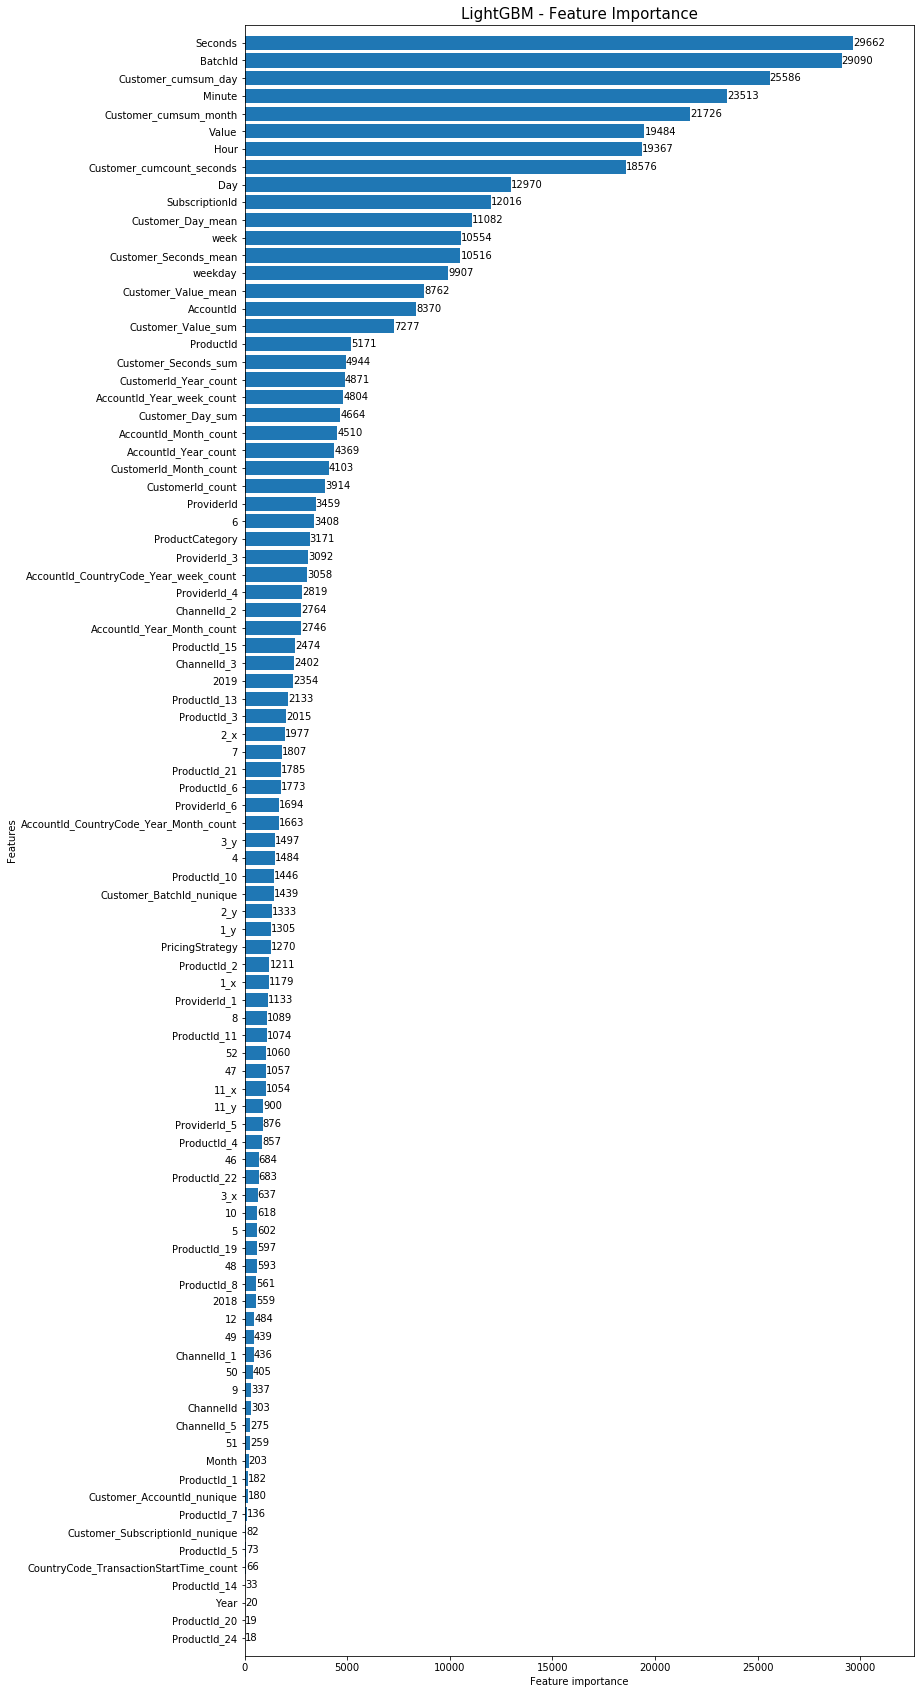

In [216]:
fig, ax = plt.subplots(figsize=(12,30))
lgb.plot_importance(model, max_num_features=100, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [56]:
sample_submission = pd.DataFrame(test['TransactionId'])
sample_submission['FraudResult'] = xgb_pred
#sample_submission.loc[sample_submission['FraudResult'] > 0.5, 'FraudResult'] = 1
#sample_submission.loc[sample_submission['FraudResult'] < 0.5, 'FraudResult'] = 0
#sample_submission['FraudResult'] = sample_submission['FraudResult'].astype('int')
sample_submission.to_csv('./Submissions/XGB_v4_.csv', index=False)

In [57]:
sample_submission['FraudResult'].value_counts()

0    44938
1       81
Name: FraudResult, dtype: int64